In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.1
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


In [2]:
# Example usage:
# This was the previous run


#This with new animals:
animals = ['PV_208']
block_lists = [[21]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)
for block in block_collection:
    print(f'working on {block}')
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    #block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    #load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

instantiated block number 021 at Path: Z:\Nimrod\experiments\PV_208\2025_12_14\block_021, new OE version
Found the sample rate for block 021 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 021
got it!
working on PV_208, block 021, on PV208_d5t4_2025-12-14_13-43-40
running parse_open_ephys_events...
block 021 has a parsed events file, reading...
Getting eye brightness values for block 021...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [3]:
    for block in block_collection:
        print('working on {}'.format(block))
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_corr_angles.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_corr_angles.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_xflipped.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_xflipped.csv')
        block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_3d_corr_verified.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_3d_corr_verified.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_rotated_verified.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_rotated_verified.csv')

    # calibrate pupil diameter:
    # if 'pupil_diameter' not in block.left_eye_data.columns:
    #     block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    #     block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    #     block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    #     block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

working on PV_208, block 021, on PV208_d5t4_2025-12-14_13-43-40


In [4]:
block_collection

[BlockSync object for animal PV_208 with 
 block_num 021 at date PV208_d5t4_2025-12-14_13-43-40]

In [5]:
for block in block_collection:
  if 'pupil_diameter' not in block.left_eye_data.columns:
        print(f'calculating pupil diameter for {block} ')
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

calculating pupil diameter for PV_208, block 021, on PV208_d5t4_2025-12-14_13-43-40 


In [6]:
# # uncomment to switch corrected values to k_phi / theta columns
# for block in block_collection:
#     block.left_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
#     block.right_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
#     # then rename in-place
#     block.left_eye_data = block.left_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})
#     block.right_eye_data = block.right_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})

In [7]:
# If you want to recenter the data (for span-related plots) against the median position, uncomment and run this:
import pandas as pd
import numpy as np
from typing import Tuple, Dict

def recenter_eye_angles_to_rest(
    eye_df: pd.DataFrame,
    phi_col: str = "k_phi",
    theta_col: str = "k_theta",
    inplace: bool = False,
    dropna: bool = True,
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """
    Recenter the eye's angular coordinates so that the median (resting position)
    of k_phi and k_theta becomes zero degrees.

    Parameters
    ----------
    eye_df : pd.DataFrame
        Eye dataframe containing k_phi and k_theta columns (can be *_eye_data_clean).
    phi_col, theta_col : str
        Column names for the vertical (phi) and horizontal (theta) gaze angles.
    inplace : bool
        If True, modifies the input DataFrame in place; otherwise returns a copy.
    dropna : bool
        Whether to ignore NaN values when computing medians (recommended True).

    Returns
    -------
    df_out : pd.DataFrame
        DataFrame with corrected columns (values centered around 0).
    offsets : dict
        {'phi_offset': float, 'theta_offset': float}
        The medians that were subtracted from the original data.

    Notes
    -----
    - New columns 'k_phi_recentered' and 'k_theta_recentered' are added
      (or the originals replaced if inplace=True).
    - This assumes your angular units are degrees.
    - The offsets correspond to the eye's resting orientation in the camera frame.
    """
    # --- validate ---
    for c in (phi_col, theta_col):
        if c not in eye_df.columns:
            raise ValueError(f"Column '{c}' not found in dataframe")

    # Select working DataFrame
    df = eye_df if inplace else eye_df.copy()

    # Convert to numeric, handle NaN
    phi_vals = pd.to_numeric(df[phi_col], errors="coerce")
    theta_vals = pd.to_numeric(df[theta_col], errors="coerce")

    # Compute medians (resting position)
    phi_med = float(np.nanmedian(phi_vals)) if dropna else float(np.median(phi_vals))
    theta_med = float(np.nanmedian(theta_vals)) if dropna else float(np.median(theta_vals))

    # Apply centering
    df[phi_col] = phi_vals - phi_med
    df[theta_col] = theta_vals - theta_med

    # Optionally store explicitly labeled recentered columns
    df[f"{phi_col}_recentered"] = df[phi_col]
    df[f"{theta_col}_recentered"] = df[theta_col]

    offsets = {"phi_offset": phi_med, "theta_offset": theta_med}
    return df, offsets

for block in block_collection:
    # Apply to the cleaned left eye data
    df_left_clean = block.left_eye_data
    df_left_centered, left_offsets = recenter_eye_angles_to_rest(df_left_clean)

    # Same for right
    df_right_clean = block.right_eye_data
    df_right_centered, right_offsets = recenter_eye_angles_to_rest(df_right_clean)

    # Store back on the block if desired
    block.left_eye_data_centered = df_left_centered
    block.right_eye_data_centered = df_right_centered

    print("Left eye offsets:", left_offsets)
    print("Right eye offsets:", right_offsets)


Left eye offsets: {'phi_offset': -16.756158913645468, 'theta_offset': -37.72325993840697}
Right eye offsets: {'phi_offset': -3.9156699633276, 'theta_offset': -31.38510797008845}


In [8]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df

In [9]:

for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.left_eye_data,
        0.8,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.right_eye_data,
        0.8,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_208, block 021, on PV208_d5t4_2025-12-14_13-43-40


In [10]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_208\2025_12_14\block_021\oe_files\PV208_d5t4_2025-12-14_13-43-40\Record Node 106\analysis\recNames=Block_021,Animal=PV_208\lizMov.mat
liz_mov_df created for PV_208, block 021, on PV208_d5t4_2025-12-14_13-43-40


In [11]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [12]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [13]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


1502it [00:00, 7536.34it/s]


742 1469


In [14]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [15]:
all_saccade_collection = pd.concat([synced_saccade_collection, non_synced_saccade_collection])

In [113]:
# =============================================================================
# Pupil-conditioned PSD (single electrode) — self-contained Jupyter cell
# =============================================================================
# HELP / USAGE
# -----------------------------------------------------------------------------
# Goal:
#   Compute and plot power spectral density (PSD) of an LFP/ephys channel during
#   epochs of different pupil size, defined from RAW 'pupil_diameter' in
#   block.left_eye_data and block.right_eye_data. The function computes z-scores
#   internally (per eye, per block), then selects windows for:
#
#     - Left pupil:  large vs (optional mid) vs small
#     - Right pupil: large vs (optional mid) vs small
#     - Both pupils: large vs (optional mid) vs small  (intersection of L and R)
#
# Inputs (key):
#   block:      your BlockSync block (must have block.oe_rec.get_data, and
#               block.left_eye_data / block.right_eye_data DataFrames)
#   electrode:  int electrode/channel number passed to oe_rec.get_data(channels=[...])
#
#   criterion:  "quantile" or "z"
#     - "quantile": thresholds defined by quantiles of z-scored pupil_diameter.
#                   Provide q_low/q_high for small/large, and optional q_mid band.
#     - "z":        thresholds defined by z-score cutoffs. Provide z_thresh for
#                   small/large (±z_thresh). Optional mid band can be defined
#                   as |z| <= z_mid (symmetric band around 0), or as (z0,z1).
#
#   window_s:   length of each ephys window used for PSD (seconds)
#   step_s:     spacing between window centers within stable pupil epochs (seconds)
#
# PSD params:
#   fs:         sampling rate for PSD. If None, inferred from block.sample_rate
#               or block.oe_rec.sample_rate.
#   nperseg_s:  Welch segment length in seconds (<= window_s). Frequency
#               resolution ~ 1/nperseg_s (conceptually), but computational load
#               scales with fs * nperseg_s.
#   noverlap_frac: Welch overlap fraction.
#
# Plot params:
#   fmax:       x-axis max frequency (Hz)
#   use_log_y:  plot PSD on log y-scale (still linear PSD, not dB)
#   plot_db:    if True, plot 10*log10(PSD) (dB). Otherwise plot linear PSD.
#   signal_unit: label for the amplitude unit returned by get_data(convert_to_mv=True)
#               If your get_data truly outputs mV, use "mV". If it outputs µV,
#               use "µV". PSD label becomes unit^2/Hz.
#
# Outputs:
#   results: dict with keys like "L_large", "L_small", optionally "L_mid", etc.
#            each entry: {'f','psd_mean','psd_sem','n_windows','df_hz'}
#   fig, axs:   matplotlib figure/axes for the 3-panel plot
#
# Example calls:
#   # Quantiles (20/80) + mid band (40/60)
#   results, fig, axs = pupil_psd_pipeline(
#       block, electrode=28,
#       criterion="quantile",
#       q_low=0.2, q_high=0.8,
#       include_mid=True, mid_band_limits=(0.4,0.6),
#       window_s=2.0, step_s=0.5,
#       fmax=100, use_log_y=True, plot_db=False,
#       signal_unit="mV"
#   )
#
#   # Z-thresholds (z>1.5 vs z<-1.5), optional mid band |z|<=0.5
#   results, fig, axs = pupil_psd_pipeline(
#       block, electrode=28,
#       criterion="z",
#       z_thresh=1.5,
#       include_mid=True, mid_band_limits=0.5,   # symmetric mid-band around 0
#       window_s=2.0, step_s=0.5,
#       fmax=100, use_log_y=True, plot_db=False,
#       signal_unit="mV"
#   )
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch


def pupil_psd_pipeline(
    block,
    electrode: int,

    # --- pupil classification ---
    criterion: str = "quantile",      # "quantile" or "z"
    q_low: float = 0.2,               # for small (quantile criterion)
    q_high: float = 0.8,              # for large (quantile criterion)
    z_thresh: float = 1.5,            # for small/large (z criterion): large > +z_thresh, small < -z_thresh
    include_mid: bool = False,
    mid_band_limits=None,             # quantile: (q0,q1), e.g. (0.4,0.6); z: either float (|z|<=val) or tuple (z0,z1)

    # --- data alignment ---
    ms_col: str = "ms_axis",          # time column in eye dataframes
    pupil_col: str = "pupil_diameter",
    merge_tol_ms: float = 2.0,

    # --- windowing in time ---
    window_s: float = 2.0,
    step_s: float = 0.5,

    # --- PSD (Welch) ---
    fs=None,                          # if None, inferred from block.sample_rate or block.oe_rec.sample_rate
    nperseg_s: float = 2.0,
    noverlap_frac: float = 0.5,
    detrend=False,                    # keep default False per your request

    # --- plot controls ---
    fmax: float = 100.0,
    use_log_y: bool = True,
    plot_db: bool = False,
    signal_unit: str = "mV",
    show_sem: bool = False,           # optional shading mean ± SEM
    verbose: bool = True,
):
    # -------------------------
    # Helpers
    # -------------------------
    def _require_cols(df, cols, df_name):
        missing = [c for c in cols if c not in df.columns]
        if missing:
            raise ValueError(f"{df_name} missing columns: {missing}. Available (first 30): {list(df.columns)[:30]}")

    def _zscore(x):
        x = np.asarray(x, dtype=float)
        mu = np.nanmean(x)
        sd = np.nanstd(x)
        if not np.isfinite(sd) or sd <= 0:
            raise ValueError("Cannot z-score pupil_diameter (std invalid). Check pupil_diameter values.")
        return (x - mu) / sd, float(mu), float(sd)

    def _contiguous_true_segments(mask, min_len):
        mask = np.asarray(mask, dtype=bool)
        if mask.size == 0:
            return []
        d = np.diff(mask.astype(int))
        starts = np.where(d == 1)[0] + 1
        ends   = np.where(d == -1)[0] + 1
        if mask[0]:
            starts = np.r_[0, starts]
        if mask[-1]:
            ends = np.r_[ends, mask.size]
        return [(int(s), int(e)) for s, e in zip(starts, ends) if (e - s) >= int(min_len)]

    def _infer_fs(block):
        oe = block.oe_rec
        val = getattr(block, "sample_rate", None)
        if val is None:
            val = getattr(oe, "sample_rate", None)
        if val is None:
            raise ValueError("fs not provided and could not infer from block.sample_rate or block.oe_rec.sample_rate")
        val = float(val)
        if not np.isfinite(val) or val <= 0:
            raise ValueError("Invalid sampling rate inferred.")
        return val

    # -------------------------
    # 1) Pull + align pupil diameter L/R on a shared ms axis
    # -------------------------
    Ldf = block.left_eye_data
    Rdf = block.right_eye_data
    _require_cols(Ldf, [ms_col, pupil_col], "block.left_eye_data")
    _require_cols(Rdf, [ms_col, pupil_col], "block.right_eye_data")

    base = (Ldf[[ms_col, pupil_col]]
            .copy()
            .rename(columns={ms_col: "ms", pupil_col: "Ldiam"})
            .sort_values("ms"))
    rtmp = (Rdf[[ms_col, pupil_col]]
            .copy()
            .rename(columns={ms_col: "ms", pupil_col: "Rdiam"})
            .sort_values("ms"))

    merged = pd.merge_asof(base, rtmp, on="ms", direction="nearest", tolerance=float(merge_tol_ms))
    merged = merged.dropna(subset=["Ldiam", "Rdiam"])
    if merged.empty:
        raise ValueError("No overlapping L/R pupil samples after merge_asof. Check ms_col and merge_tol_ms.")

    ms = merged["ms"].to_numpy(dtype=float)
    Ldiam = merged["Ldiam"].to_numpy(dtype=float)
    Rdiam = merged["Rdiam"].to_numpy(dtype=float)

    # -------------------------
    # 2) Compute z-scores internally (per eye, per block)
    # -------------------------
    Lz, Lmu, Lsd = _zscore(Ldiam)
    Rz, Rmu, Rsd = _zscore(Rdiam)

    # -------------------------
    # 3) Build large/small (and optional mid) masks
    # -------------------------
    criterion = str(criterion).lower().strip()
    if criterion not in ("quantile", "z"):
        raise ValueError("criterion must be 'quantile' or 'z'")

    # large/small
    if criterion == "quantile":
        L_lo, L_hi = np.nanquantile(Lz, [float(q_low), float(q_high)])
        R_lo, R_hi = np.nanquantile(Rz, [float(q_low), float(q_high)])
        L_large = Lz >= L_hi
        L_small = Lz <= L_lo
        R_large = Rz >= R_hi
        R_small = Rz <= R_lo

        # mid band: quantiles (q0,q1)
        if include_mid:
            if mid_band_limits is None:
                raise ValueError("For criterion='quantile' and include_mid=True, provide mid_band_limits=(q0,q1).")
            if not (isinstance(mid_band_limits, (tuple, list)) and len(mid_band_limits) == 2):
                raise ValueError("mid_band_limits must be a tuple/list (q0,q1) for criterion='quantile'.")
            q0, q1 = float(mid_band_limits[0]), float(mid_band_limits[1])
            if not (0.0 <= q0 < q1 <= 1.0):
                raise ValueError("mid_band_limits quantiles must satisfy 0 <= q0 < q1 <= 1.")
            L_m0, L_m1 = np.nanquantile(Lz, [q0, q1])
            R_m0, R_m1 = np.nanquantile(Rz, [q0, q1])
            L_mid = (Lz >= L_m0) & (Lz <= L_m1)
            R_mid = (Rz >= R_m0) & (Rz <= R_m1)
        else:
            L_mid = R_mid = None

    else:  # criterion == "z"
        zt = float(z_thresh)
        L_large = Lz > zt
        L_small = Lz < -zt
        R_large = Rz > zt
        R_small = Rz < -zt

        # mid band: either symmetric float (|z| <= val), or explicit (z0,z1)
        if include_mid:
            if mid_band_limits is None:
                raise ValueError("For criterion='z' and include_mid=True, provide mid_band_limits (float or (z0,z1)).")

            if isinstance(mid_band_limits, (int, float, np.floating)):
                zmid = float(mid_band_limits)
                if zmid < 0:
                    raise ValueError("mid_band_limits as float must be non-negative (interpreted as |z|<=zmid).")
                L_mid = (np.abs(Lz) <= zmid)
                R_mid = (np.abs(Rz) <= zmid)
            elif isinstance(mid_band_limits, (tuple, list)) and len(mid_band_limits) == 2:
                z0, z1 = float(mid_band_limits[0]), float(mid_band_limits[1])
                if z0 > z1:
                    z0, z1 = z1, z0
                L_mid = (Lz >= z0) & (Lz <= z1)
                R_mid = (Rz >= z0) & (Rz <= z1)
            else:
                raise ValueError("mid_band_limits for criterion='z' must be a float (|z|<=val) or tuple (z0,z1).")
        else:
            L_mid = R_mid = None

    masks = {
        "L_large": L_large,
        "L_small": L_small,
        "R_large": R_large,
        "R_small": R_small,
        "Both_large": L_large & R_large,
        "Both_small": L_small & R_small,
    }
    if include_mid:
        masks["L_mid"] = L_mid
        masks["R_mid"] = R_mid
        masks["Both_mid"] = L_mid & R_mid

    # -------------------------
    # 4) Define window centers within contiguous True epochs
    # -------------------------
    win_ms = float(window_s) * 1000.0
    step_ms = float(step_s) * 1000.0
    half = win_ms / 2.0

    dt_est = np.nanmedian(np.diff(ms))
    if not np.isfinite(dt_est) or dt_est <= 0:
        dt_est = 16.67
    min_len = int(np.ceil(win_ms / dt_est))

    # -------------------------
    # 5) Compute PSD per condition
    # -------------------------
    if fs is None:
        fs = _infer_fs(block)
    else:
        fs = float(fs)

    # Welch params
    nperseg = int(round(fs * min(float(nperseg_s), float(window_s))))
    if nperseg < 8:
        raise ValueError("nperseg too small; increase nperseg_s or fs.")
    noverlap = int(round(float(noverlap_frac) * nperseg))
    if noverlap >= nperseg:
        noverlap = nperseg // 2

    oe = block.oe_rec
    results = {}
    for name, mask in masks.items():
        if mask is None or not np.any(mask):
            results[name] = {"f": None, "psd_mean": None, "psd_sem": None, "n_windows": 0, "df_hz": None}
            continue

        segs = _contiguous_true_segments(mask, min_len=min_len)
        centers = []
        for s, e in segs:
            t0 = ms[s] + half
            t1 = ms[e - 1] - half
            if t1 <= t0:
                continue
            centers.append(np.arange(t0, t1 + 1e-6, step_ms))

        if len(centers) == 0:
            results[name] = {"f": None, "psd_mean": None, "psd_sem": None, "n_windows": 0, "df_hz": None}
            continue

        centers_ms = np.concatenate(centers).astype(float)
        start_times_ms = centers_ms - half

        # Retrieve ephys windows (shape [1, n_windows, n_samples])
        data = oe.get_data(
            channels=[int(electrode)],
            start_time_ms=start_times_ms,
            window_ms=float(win_ms),
            convert_to_mv=True,
            return_timestamps=False,
            repress_output=True
        )
        if data is None:
            results[name] = {"f": None, "psd_mean": None, "psd_sem": None, "n_windows": 0, "df_hz": None}
            continue

        x = np.asarray(data, dtype=float)[0]  # [n_windows, n_samp]
        n_win, n_samp = x.shape

        # Effective Welch params given actual samples available
        nperseg_eff = min(nperseg, n_samp)
        noverlap_eff = min(noverlap, max(0, nperseg_eff - 1))

        psds = []
        f = None
        for i in range(n_win):
            f, Pxx = welch(
                x[i],
                fs=fs,
                nperseg=nperseg_eff,
                noverlap=noverlap_eff,
                detrend=detrend
            )
            psds.append(Pxx)

        psds = np.vstack(psds)  # [n_win, n_freq]
        psd_mean = np.nanmean(psds, axis=0)
        psd_sem = (np.nanstd(psds, axis=0, ddof=1) / np.sqrt(n_win)) if n_win >= 2 else np.full_like(psd_mean, np.nan)
        df_hz = (f[1] - f[0]) if (f is not None and len(f) > 1) else None

        results[name] = {"f": f, "psd_mean": psd_mean, "psd_sem": psd_sem, "n_windows": int(n_win), "df_hz": df_hz}

    # -------------------------
    # 6) Plot split panels (Left / Right / Both)
    # -------------------------
    if include_mid:
        groups = [
            ("Left pupil",  ["L_large", "L_mid", "L_small"]),
            ("Right pupil", ["R_large", "R_mid", "R_small"]),
            ("Both pupils", ["Both_large", "Both_mid", "Both_small"]),
        ]
    else:
        groups = [
            ("Left pupil",  ["L_large", "L_small"]),
            ("Right pupil", ["R_large", "R_small"]),
            ("Both pupils", ["Both_large", "Both_small"]),
        ]

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.6), sharey=True)
    eps = 1e-30  # protects log / log10

    # Decide y-axis label
    if plot_db:
        ylab = f"PSD (dB re: {signal_unit}$^2$/Hz)"
    else:
        ylab = f"PSD ({signal_unit}$^2$/Hz)"

    for ax, (title, keys) in zip(axs, groups):
        for key in keys:
            out = results.get(key, None)
            if out is None or out["f"] is None:
                continue

            f = out["f"]
            y = out["psd_mean"]
            s = out["psd_sem"]

            sel = (f >= 0) & (f <= float(fmax))
            f_plot = f[sel]
            y_plot = y[sel]

            if plot_db:
                y_plot = 10.0 * np.log10(np.maximum(y_plot, eps))
                if show_sem and (s is not None):
                    s_plot = s[sel]
                    # convert SEM in linear to approx SEM in dB space (small-error approximation)
                    # d(10log10(y)) ≈ (10/ln(10)) * (dy / y)
                    s_db = (10.0 / np.log(10.0)) * (s_plot / np.maximum(y_plot, eps))
                    ax.fill_between(f_plot, y_plot - s_db, y_plot + s_db, alpha=0.2)
            else:
                if use_log_y:
                    y_plot = np.maximum(y_plot, eps)
                if show_sem and (s is not None):
                    s_plot = s[sel]
                    ax.fill_between(f_plot, y_plot - s_plot, y_plot + s_plot, alpha=0.2)

            ax.plot(f_plot, y_plot, lw=1.8, label=f"{key} (n={out['n_windows']})")

        ax.set_title(title)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_xlim(0, float(fmax))
        if use_log_y and (not plot_db):
            ax.set_yscale("log")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.legend(frameon=False, fontsize=8)

    axs[0].set_ylabel(ylab)

    # Title info line
    crit_str = f"criterion={criterion}"
    if criterion == "quantile":
        crit_str += f", small<=q{q_low:.2f}, large>=q{q_high:.2f}"
        if include_mid:
            crit_str += f", mid=q[{mid_band_limits[0]:.2f},{mid_band_limits[1]:.2f}]"
    else:
        crit_str += f", small<-{z_thresh:.2f}, large>{z_thresh:.2f}"
        if include_mid:
            crit_str += f", mid={mid_band_limits}"

    fig.suptitle(
        f"Electrode {electrode}: pupil-conditioned PSD (0–{int(fmax)} Hz) | {crit_str}",
        y=1.05
    )
    fig.tight_layout()

    # -------------------------
    # 7) Verbose summary
    # -------------------------
    if verbose:
        print(f"fs={fs:.2f} Hz | window={window_s:.2f}s | step={step_s:.2f}s | nperseg_s={nperseg_s:.2f}s | detrend={detrend}")
        print(f"Pupil z-score params (block-level): L(mu={Lmu:.4f}, sd={Lsd:.4f}) | R(mu={Rmu:.4f}, sd={Rsd:.4f})")
        for k in results:
            v = results[k]
            if v["n_windows"] > 0:
                print(f"  {k}: n_windows={v['n_windows']}, df≈{v['df_hz']:.3f} Hz")
            else:
                print(f"  {k}: n_windows=0")

    return results, fig, axs


# =============================================================================
# OPTIONAL: quick template call (edit values and run)
# =============================================================================
results, fig, axs = pupil_psd_pipeline(
    block=block,
    electrode=28,
    criterion="z",
    z_thresh=1,
    include_mid=False,
    mid_band_limits=0.5,   # symmetric mid band |z|<=0.5
    window_s=0.2,
    step_s=0.5,
    fs=None,               # infer
    nperseg_s=2.0,
    noverlap_frac=0.5,
    fmax=100,
    use_log_y=True,
    plot_db=False,
    signal_unit="microV",
    show_sem=False,
    verbose=True,
)
plt.show()


fs=20000.00 Hz | window=0.20s | step=0.50s | nperseg_s=2.00s | detrend=False
Pupil z-score params (block-level): L(mu=1.7048, sd=0.0656) | R(mu=1.4697, sd=0.0621)
  L_large: n_windows=502, df≈5.000 Hz
  L_small: n_windows=447, df≈5.000 Hz
  R_large: n_windows=248, df≈5.000 Hz
  R_small: n_windows=625, df≈5.000 Hz
  Both_large: n_windows=37, df≈5.000 Hz
  Both_small: n_windows=166, df≈5.000 Hz


fs=20000.00 Hz | window=2.00s | step=0.50s | nperseg_s=2.00s | detrend=False
Pupil z-score params (block-level): L(mu=1.7048, sd=0.0656) | R(mu=1.4697, sd=0.0621)
  L_large: n_windows=207, df≈0.500 Hz
  L_small: n_windows=157, df≈0.500 Hz
  R_large: n_windows=169, df≈0.500 Hz
  R_small: n_windows=233, df≈0.500 Hz
  Both_large: n_windows=1, df≈0.500 Hz
  Both_small: n_windows=21, df≈0.500 Hz


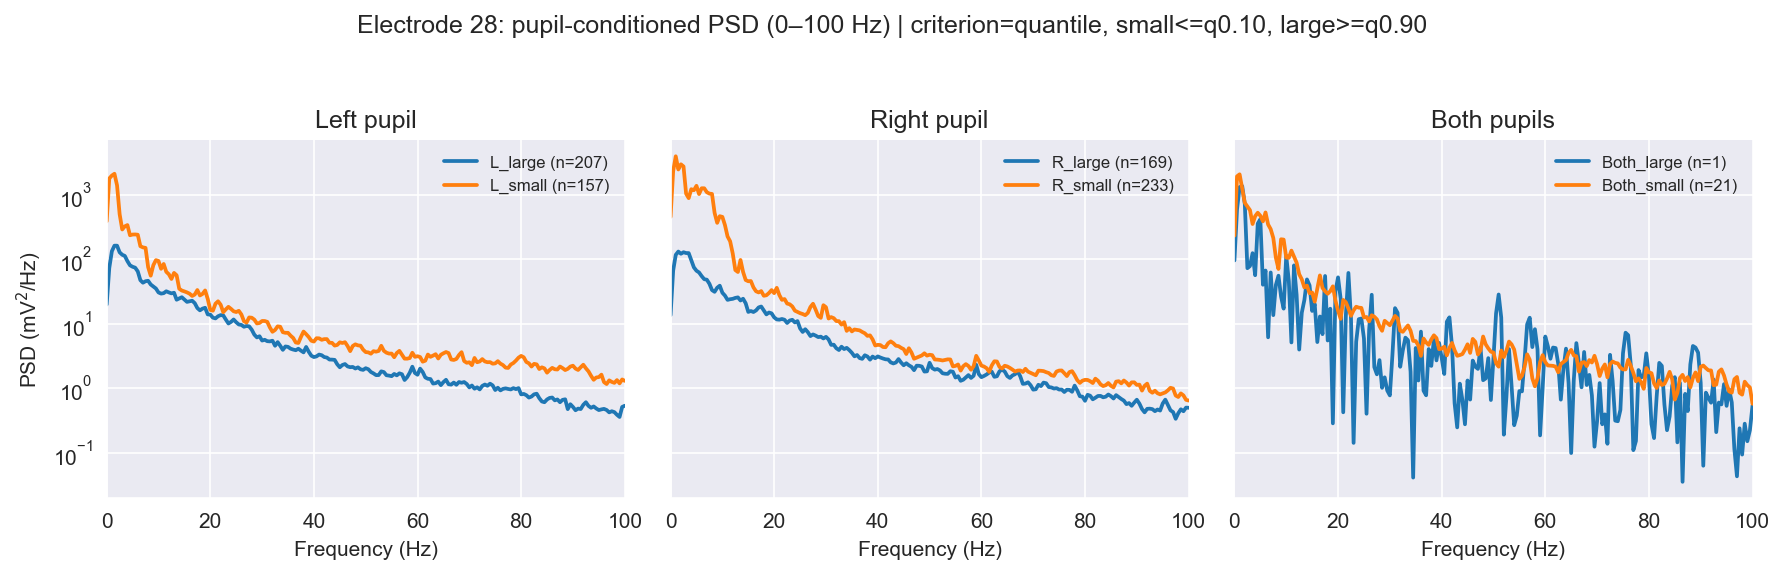

In [107]:
results, fig, axs = pupil_psd_pipeline(
    block=block,
    electrode=28,

    criterion="quantile",
    q_low=0.1,
    q_high=0.9,
    include_mid=False,
    mid_band_limits=(0.4, 0.6),   # mid = 40–60th percentile (per eye)

    window_s=2.0,
    step_s=0.5,
    nperseg_s=2.0,
    noverlap_frac=0.5,

    fmax=100,
    use_log_y=True,
    plot_db=False,
    signal_unit="mV",
    verbose=True
)
plt.show()


In [104]:
# pupil-derived PSD graphs
# ============================================================
# Pupil-diameter–conditioned PSD (single electrode, split panels)
# - Uses raw pupil_diameter (always) and computes z-scores here
# - NO detrending (detrend=False)
# - NO downsampling (uses raw ephys sampling rate, e.g., ~20 kHz)
# - Plots 0–100 Hz, split into Left / Right / Both pupil conditions
#
# Notes on units:
#   Welch PSD returns POWER SPECTRAL DENSITY in (signal_units^2 / Hz).
#   If oe_rec.get_data(convert_to_mv=True) returns millivolts, PSD is (mV^2/Hz).
#   If your get_data returns microvolts, PSD is (µV^2/Hz).
#   This is NOT dB unless you explicitly convert: 10*log10(PSD).
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch

# -------------------------
# User parameters (edit these)
# -------------------------
electrode = 28
window_s = 2.0            # window length for PSD (seconds)
step_s = 0.5              # sliding step (seconds) for choosing window centers within stable pupil epochs
criterion = "quantile"    # "quantile" or "z"
q_low, q_high = 0.2, 0.8  # used if criterion="quantile"
z_thresh = 1.5            # used if criterion="z"
merge_tol_ms = 2.0        # tolerance for aligning L/R pupil samples in ms

# Welch parameters
nperseg_s = 2.0           # segment length used by Welch in seconds (<= window_s). Bigger => finer df at low Hz.
noverlap_frac = 0.5       # overlap within Welch (not the sliding window step above)
use_log_y = True          # log-scale on PSD axis (not dB)
plot_db = False           # if True: plot 10*log10(PSD) instead of raw PSD

# Plot limits
fmax = 100                # show 0–100 Hz

# Y-axis label unit (set this to match your get_data scaling)
# If your OERecording.convert_to_mv truly yields mV, keep "mV".
# If you know it yields µV, set to "µV".
signal_unit = "mV"

# ------------------------------------------------------------
# Helper functions (kept inside the cell so it's self-contained)
# ------------------------------------------------------------
def _require_cols(df, cols, df_name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{df_name} missing columns: {missing}. Available (first 30): {list(df.columns)[:30]}")

def _zscore(x):
    x = np.asarray(x, dtype=float)
    mu = np.nanmean(x)
    sd = np.nanstd(x)
    if not np.isfinite(sd) or sd <= 0:
        raise ValueError("Cannot z-score pupil_diameter (std invalid). Check pupil_diameter values.")
    return (x - mu) / sd, float(mu), float(sd)

def _contiguous_true_segments(mask, min_len):
    """
    Return list of (start_idx, end_idx_exclusive) for contiguous True runs of at least min_len samples.
    """
    mask = np.asarray(mask, dtype=bool)
    if mask.size == 0:
        return []
    d = np.diff(mask.astype(int))
    starts = np.where(d == 1)[0] + 1
    ends   = np.where(d == -1)[0] + 1
    if mask[0]:
        starts = np.r_[0, starts]
    if mask[-1]:
        ends = np.r_[ends, mask.size]
    return [(int(s), int(e)) for s, e in zip(starts, ends) if (e - s) >= int(min_len)]

def compute_pupil_conditioned_psd_split(block):
    """
    Computes mean PSD for each condition:
      L_large / L_small, R_large / R_small, Both_large / Both_small

    Returns a dict:
      results[key] = {'f': f, 'psd_mean': mean, 'psd_sem': sem, 'n_windows': n, 'df_hz': df}
    """
    # -------------------------
    # 1) Pull and align pupil diameter time series (L and R)
    # -------------------------
    Ldf = block.left_eye_data
    Rdf = block.right_eye_data
    _require_cols(Ldf, ["pupil_diameter", "ms_axis"], "block.left_eye_data")
    _require_cols(Rdf, ["pupil_diameter", "ms_axis"], "block.right_eye_data")

    # Align R to L using ms_axis (nearest within tolerance)
    base = Ldf[["ms_axis", "pupil_diameter"]].copy().rename(columns={"ms_axis": "ms", "pupil_diameter": "Ldiam"}).sort_values("ms")
    rtmp = Rdf[["ms_axis", "pupil_diameter"]].copy().rename(columns={"ms_axis": "ms", "pupil_diameter": "Rdiam"}).sort_values("ms")

    merged = pd.merge_asof(base, rtmp, on="ms", direction="nearest", tolerance=float(merge_tol_ms))
    merged = merged.dropna(subset=["Ldiam", "Rdiam"])
    if merged.empty:
        raise ValueError("No overlapping L/R pupil samples after merge_asof. Check ms_axis alignment and merge_tol_ms.")

    ms = merged["ms"].to_numpy(dtype=float)
    Ldiam = merged["Ldiam"].to_numpy(dtype=float)
    Rdiam = merged["Rdiam"].to_numpy(dtype=float)

    # -------------------------
    # 2) Compute z-scores internally (per block, per eye)
    # -------------------------
    Lz, Lmu, Lsd = _zscore(Ldiam)
    Rz, Rmu, Rsd = _zscore(Rdiam)

    # -------------------------
    # 3) Define "large" / "small" using quantiles or z-thresholds
    # -------------------------
    if criterion == "quantile":
        L_lo, L_hi = np.nanquantile(Lz, [q_low, q_high])
        R_lo, R_hi = np.nanquantile(Rz, [q_low, q_high])
        L_large = Lz >= L_hi
        L_small = Lz <= L_lo
        R_large = Rz >= R_hi
        R_small = Rz <= R_lo
    elif criterion == "z":
        L_large = Lz > float(z_thresh)
        L_small = Lz < -float(z_thresh)
        R_large = Rz > float(z_thresh)
        R_small = Rz < -float(z_thresh)
    else:
        raise ValueError("criterion must be 'quantile' or 'z'")

    masks = {
        "L_large": L_large,
        "L_small": L_small,
        "R_large": R_large,
        "R_small": R_small,
        "Both_large": L_large & R_large,
        "Both_small": L_small & R_small,
    }

    # -------------------------
    # 4) Convert pupil masks into a list of ephys windows (centers) per condition
    #    We only take windows that fit entirely inside contiguous 'True' epochs.
    # -------------------------
    win_ms = float(window_s) * 1000.0
    step_ms = float(step_s) * 1000.0
    half = win_ms / 2.0

    # Estimate pupil sampling interval to decide what "min contiguous length" means in samples
    dt_est = np.nanmedian(np.diff(ms))
    if not np.isfinite(dt_est) or dt_est <= 0:
        dt_est = 16.67  # fallback ~60 Hz
    min_len = int(np.ceil(win_ms / dt_est))  # contiguous mask must last long enough to fit a full window

    # -------------------------
    # 5) Pull LFP windows for each condition using oe_rec.get_data
    #    and compute PSD per window with Welch (no detrending, no downsampling).
    # -------------------------
    oe = block.oe_rec
    fs = float(getattr(block, "sample_rate", None) or getattr(oe, "sample_rate", None))
    if not np.isfinite(fs) or fs <= 0:
        raise ValueError("Could not infer sampling rate from block.sample_rate or oe_rec.sample_rate.")

    # Welch params: if fs ~20kHz and nperseg_s=2.0 -> nperseg ~ 40,000 => df ~ 0.5 Hz (good low-freq resolution)
    # This is compute/heavy but conceptually clean.
    nperseg = int(round(fs * min(float(nperseg_s), float(window_s))))
    noverlap = int(round(float(noverlap_frac) * nperseg))
    if noverlap >= nperseg:
        noverlap = nperseg // 2

    results = {}
    for name, mask in masks.items():
        mask = np.asarray(mask, dtype=bool)
        if not np.any(mask):
            results[name] = {"f": None, "psd_mean": None, "psd_sem": None, "n_windows": 0, "df_hz": None}
            continue

        segs = _contiguous_true_segments(mask, min_len=min_len)
        centers = []
        for s, e in segs:
            # allowable center times that keep the whole window inside the segment
            t0 = ms[s] + half
            t1 = ms[e - 1] - half
            if t1 <= t0:
                continue
            centers.append(np.arange(t0, t1 + 1e-6, step_ms))

        if len(centers) == 0:
            results[name] = {"f": None, "psd_mean": None, "psd_sem": None, "n_windows": 0, "df_hz": None}
            continue

        centers_ms = np.concatenate(centers).astype(float)
        start_times_ms = centers_ms - half

        # Fetch ephys windows: returns array shaped [1, n_windows, n_samples]
        data = oe.get_data(
            channels=[int(electrode)],
            start_time_ms=start_times_ms,
            window_ms=float(win_ms),
            convert_to_mv=True,
            return_timestamps=False,
            repress_output=True
        )
        if data is None:
            results[name] = {"f": None, "psd_mean": None, "psd_sem": None, "n_windows": 0, "df_hz": None}
            continue

        x = np.asarray(data, dtype=float)[0]  # [n_windows, n_samp]
        n_win, n_samp = x.shape[0], x.shape[1]
        if n_win == 0:
            results[name] = {"f": None, "psd_mean": None, "psd_sem": None, "n_windows": 0, "df_hz": None}
            continue

        # Cap nperseg to available samples (Welch requirement)
        nperseg_eff = min(nperseg, n_samp)
        noverlap_eff = min(noverlap, max(0, nperseg_eff - 1))

        psds = []
        f = None
        for i in range(n_win):
            # detrend=False => NO mean-removal or linear detrending (ground-level, raw PSD)
            f, Pxx = welch(
                x[i],
                fs=fs,
                nperseg=nperseg_eff,
                noverlap=noverlap_eff,
                detrend=False
            )
            psds.append(Pxx)
        psds = np.vstack(psds)  # [n_win, n_freq]

        psd_mean = np.nanmean(psds, axis=0)
        psd_sem  = (np.nanstd(psds, axis=0, ddof=1) / np.sqrt(n_win)) if n_win >= 2 else np.full_like(psd_mean, np.nan)
        df_hz = (f[1] - f[0]) if (f is not None and len(f) > 1) else None

        results[name] = {"f": f, "psd_mean": psd_mean, "psd_sem": psd_sem, "n_windows": int(n_win), "df_hz": df_hz}

    # Print quick summary (optional)
    print(f"Electrode {electrode} | fs={fs:.1f} Hz | window={window_s:.2f}s | nperseg_s={nperseg_s:.2f}s | expected df≈{(fs/min(nperseg, int(fs*window_s))):.3f} Hz")
    print(f"Pupil z-score params (block-level): L(mu={Lmu:.3f}, sd={Lsd:.3f}) | R(mu={Rmu:.3f}, sd={Rsd:.3f})")
    for k, v in results.items():
        if v["n_windows"] > 0:
            print(f"  {k}: n_windows={v['n_windows']}, df≈{v['df_hz']:.3f} Hz")
        else:
            print(f"  {k}: n_windows=0")

    return results


def plot_psd_split(results, fmax=100, signal_unit="mV", use_log_y=True, plot_db=False):
    """
    3 panels: Left pupil, Right pupil, Both pupils.
    Each panel: large vs small.
    """
    groups = [
        ("Left pupil",  ["L_large", "L_small"]),
        ("Right pupil", ["R_large", "R_small"]),
        ("Both pupils", ["Both_large", "Both_small"]),
    ]

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.4), sharey=True)

    eps = 1e-30  # for log safety if needed
    for ax, (title, keys) in zip(axs, groups):
        for k in keys:
            out = results.get(k, None)
            if out is None or out["f"] is None:
                continue
            f = out["f"]
            m = out["psd_mean"]

            # Restrict to f <= fmax for plotting
            sel = (f >= 0) & (f <= float(fmax))
            f_plot = f[sel]
            y = m[sel]

            if plot_db:
                y_plot = 10.0 * np.log10(np.maximum(y, eps))
                ylab = "PSD (dB re: {}$^2$/Hz)".format(signal_unit)
            else:
                y_plot = np.maximum(y, eps) if use_log_y else y
                ylab = f"PSD ({signal_unit}$^2$/Hz)"

            ax.plot(f_plot, y_plot, lw=1.8, label=f"{k} (n={out['n_windows']})")

        ax.set_title(title)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_xlim(0, float(fmax))
        if use_log_y and (not plot_db):
            ax.set_yscale("log")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.legend(frameon=False, fontsize=8)

    axs[0].set_ylabel(ylab)
    fig.suptitle(f"Electrode {electrode}: pupil-conditioned PSD (0–{int(fmax)} Hz)", y=1.05)
    fig.tight_layout()
    return fig, axs
results = compute_pupil_conditioned_psd_split(
    block,
    criterion="z",
    z_thresh=1.5,
    include_mid=False
)

TypeError: compute_pupil_conditioned_psd_split() got an unexpected keyword argument 'criterion'

In [ ]:
# -------------------------
# Run (this produces the 3-panel plot)
# -------------------------
results = compute_pupil_conditioned_psd_split(block)
fig, axs = plot_psd_split(results, fmax=fmax, signal_unit=signal_unit, use_log_y=use_log_y, plot_db=plot_db)
#fig.savefig(block.analysis_path / "pupil_conditioned_psd_e28_0_100Hz_split.pdf")
plt.show()


In [58]:
#oldschoole approach
monocular_left = non_synced_saccade_collection.query('eye == "L"').saccade_on_ms.values
monocular_right = non_synced_saccade_collection.query('eye == "R"').saccade_on_ms.values
binocular = synced_saccade_collection.saccade_on_ms.values

electrode = 28

mono_l_data, mono_l_timestamps = block.oe_rec.get_data(channels=[electrode],
                 start_time_ms=monocular_left-50,
                 window_ms=100,
                 convert_to_mv=True,
                 return_timestamps=True,
                 repress_output=False)
mono_r_data, mono_r_timestamps = block.oe_rec.get_data(channels=[electrode],
                 start_time_ms=monocular_right -50,
                 window_ms=100,
                 convert_to_mv=True,
                 return_timestamps=True,
                 repress_output=False)

# binocular_data, synced_timestamps = block.oe_rec.get_data(channels=[electrode],
#                  start_time_ms=binocular,
#                  window_ms=100,
#                  convert_to_mv=True,
#                  return_timestamps=True,
#                  repress_output=False)

sample removed for window #24
sample removed for window #29
sample removed for window #33
sample removed for window #35
sample removed for window #45
sample removed for window #47
sample removed for window #50
sample removed for window #55
sample removed for window #61
sample removed for window #63
sample removed for window #68
sample removed for window #71
sample removed for window #84
sample removed for window #90
sample removed for window #99
sample removed for window #105
sample removed for window #112
sample removed for window #120
sample removed for window #155
sample removed for window #162
sample removed for window #189
sample removed for window #194
sample removed for window #210
sample removed for window #227
sample removed for window #241
sample removed for window #264
sample removed for window #267
sample removed for window #297
sample removed for window #310
sample removed for window #313
sample removed for window #318
sample removed for window #332
sample removed for wind

sample removed for window #24
sample removed for window #29
sample removed for window #33
sample removed for window #35
sample removed for window #45
sample removed for window #47
sample removed for window #50
sample removed for window #55
sample removed for window #61
sample removed for window #63
sample removed for window #68
sample removed for window #71
sample removed for window #84
sample removed for window #90
sample removed for window #99
sample removed for window #105
sample removed for window #112
sample removed for window #120
sample removed for window #155
sample removed for window #162
sample removed for window #189
sample removed for window #194
sample removed for window #210
sample removed for window #227
sample removed for window #241
sample removed for window #264
sample removed for window #267
sample removed for window #297
sample removed for window #310
sample removed for window #313
sample removed for window #318
sample removed for window #332
sample removed for wind

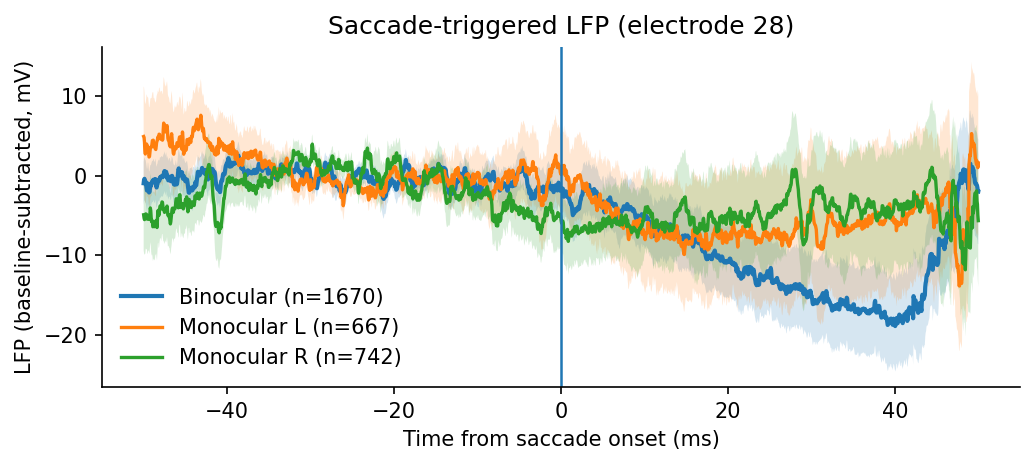

In [60]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

# ---- parameters ----
pre_ms = 50
window_ms = 100
baseline_ms = (-40, -10)  # pre-onset baseline

# electrode must already exist, e.g. electrode = 28

def mean_sem_over_events(data_3d):
    x = np.asarray(data_3d, dtype=float)
    if x.ndim != 3 or x.shape[0] != 1:
        raise ValueError(f"Expected data shape [1, n_events, n_samples], got {x.shape}")
    x = x[0]  # [n_events, n_samples]
    n = x.shape[0]
    mean = np.nanmean(x, axis=0)
    sem = (np.nanstd(x, axis=0, ddof=1) / np.sqrt(n)) if n >= 2 else np.full_like(mean, np.nan)
    return mean, sem, n

def baseline_correct(data_3d, t_rel, baseline_ms):
    b0, b1 = baseline_ms
    bmask = (t_rel >= b0) & (t_rel <= b1)
    if not np.any(bmask):
        raise ValueError("baseline_ms does not overlap extracted window.")
    return data_3d - np.nanmean(data_3d[:, :, bmask], axis=2, keepdims=True)

def extract_binocular_onsets_ms(synced_saccade_collection):
    """
    Returns 1D array of binocular event onsets (ms).
    Tries to use saccade_on_ms directly; otherwise groups by 'Main' and averages L/R.
    """
    # If it's already a DataFrame:
    if hasattr(synced_saccade_collection, "query") and hasattr(synced_saccade_collection, "columns"):
        df = synced_saccade_collection
    # Or an object holding a DataFrame:
    elif hasattr(synced_saccade_collection, "df"):
        df = synced_saccade_collection.df
    else:
        # fallback: treat as array-like
        arr = np.asarray(getattr(synced_saccade_collection, "saccade_on_ms"))
        arr = np.asarray(arr).reshape(-1)
        return arr[np.isfinite(arr)]

    # Try direct column first
    if "saccade_on_ms" in df.columns:
        arr = np.asarray(df["saccade_on_ms"].values)
        # If it’s clean 1D numeric, use it
        try:
            arr1 = np.asarray(arr, dtype=float).reshape(-1)
            if np.all(np.isfinite(arr1)) and arr1.size > 0:
                return arr1
        except Exception:
            pass

    # Otherwise, use Main-grouping to make one onset per binocular event
    if ("Main" in df.columns) and ("eye" in df.columns) and ("saccade_on_ms" in df.columns):
        out = []
        for _, g in df.groupby("Main"):
            if ("L" in set(g["eye"])) and ("R" in set(g["eye"])):
                l = float(g.loc[g["eye"] == "L", "saccade_on_ms"].iloc[0])
                r = float(g.loc[g["eye"] == "R", "saccade_on_ms"].iloc[0])
                out.append(0.5 * (l + r))
        return np.asarray(out, dtype=float)

    raise ValueError("Could not extract binocular onsets from synced_saccade_collection. "
                     "Need either a numeric saccade_on_ms vector, or columns: Main, eye, saccade_on_ms.")


# ---- Prepare onset vectors (as in your oldschool approach) ----
monocular_left  = non_synced_saccade_collection.query('eye == "L"').saccade_on_ms.values
monocular_right = non_synced_saccade_collection.query('eye == "R"').saccade_on_ms.values
binocular       = extract_binocular_onsets_ms(synced_saccade_collection)

# ---- Fetch data ----
mono_l_data, _ = block.oe_rec.get_data([electrode], monocular_left  - pre_ms, window_ms, True, True, False)
mono_r_data, _ = block.oe_rec.get_data([electrode], monocular_right - pre_ms, window_ms, True, True, False)
bino_data,  _  = block.oe_rec.get_data([electrode], binocular       - pre_ms, window_ms, True, True, False)

# ---- Time axis ----
sample_ms = float(getattr(block.oe_rec, "sample_ms"))
n_samp = mono_l_data.shape[2]
t_rel = np.arange(n_samp) * sample_ms - pre_ms

# ---- Baseline correct ----
mono_l = baseline_correct(np.asarray(mono_l_data, dtype=float), t_rel, baseline_ms)
mono_r = baseline_correct(np.asarray(mono_r_data, dtype=float), t_rel, baseline_ms)
bino   = baseline_correct(np.asarray(bino_data,  dtype=float), t_rel, baseline_ms)

# ---- Mean/SEM over events ----
l_mean, l_sem, nL = mean_sem_over_events(mono_l)
r_mean, r_sem, nR = mean_sem_over_events(mono_r)
b_mean, b_sem, nB = mean_sem_over_events(bino)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(7.0, 3.2))

ax.plot(t_rel, b_mean, linewidth=2.0, label=f"Binocular (n={nB})")
ax.fill_between(t_rel, b_mean - b_sem, b_mean + b_sem, alpha=0.18)

ax.plot(t_rel, l_mean, linewidth=1.6, label=f"Monocular L (n={nL})")
ax.fill_between(t_rel, l_mean - l_sem, l_mean + l_sem, alpha=0.18)

ax.plot(t_rel, r_mean, linewidth=1.6, label=f"Monocular R (n={nR})")
ax.fill_between(t_rel, r_mean - r_sem, r_mean + r_sem, alpha=0.18)

ax.axvline(0, linewidth=1.2)
ax.set_xlabel("Time from saccade onset (ms)")
ax.set_ylabel("LFP (baseline-subtracted, mV)")
ax.set_title(f"Saccade-triggered LFP (electrode {electrode})")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False)
fig.tight_layout()

# Optional PDF export
# fig.savefig(f"saccade_triggered_LFP_electrode_{electrode}_mono_vs_bino.pdf", bbox_inches="tight")

plt.show()


sample removed for window #24
sample removed for window #29
sample removed for window #33
sample removed for window #35
sample removed for window #45
sample removed for window #47
sample removed for window #50
sample removed for window #55
sample removed for window #61
sample removed for window #63
sample removed for window #68
sample removed for window #71
sample removed for window #84
sample removed for window #90
sample removed for window #99
sample removed for window #105
sample removed for window #112
sample removed for window #120
sample removed for window #155
sample removed for window #162
sample removed for window #189
sample removed for window #194
sample removed for window #210
sample removed for window #227
sample removed for window #241
sample removed for window #264
sample removed for window #267
sample removed for window #297
sample removed for window #310
sample removed for window #313
sample removed for window #318
sample removed for window #332
sample removed for wind

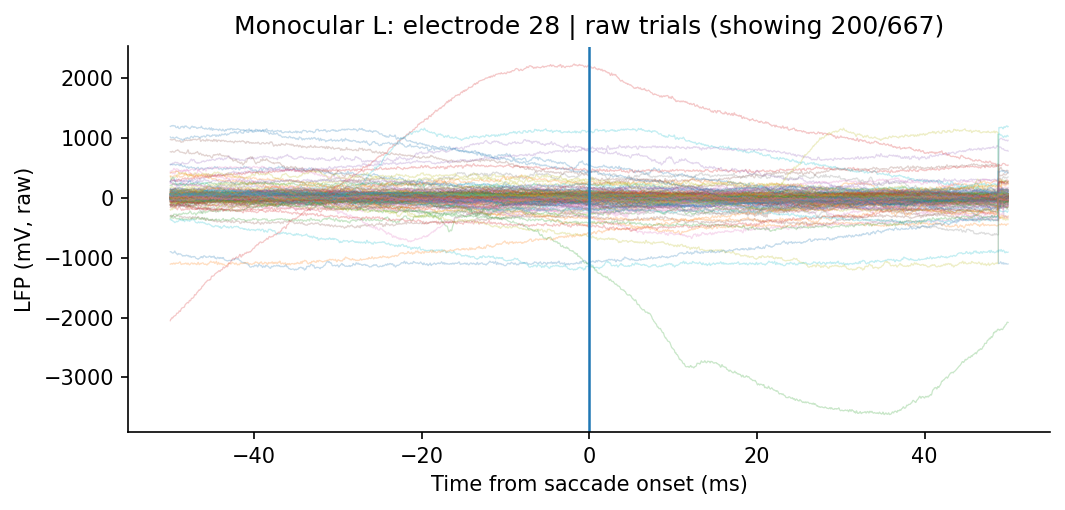

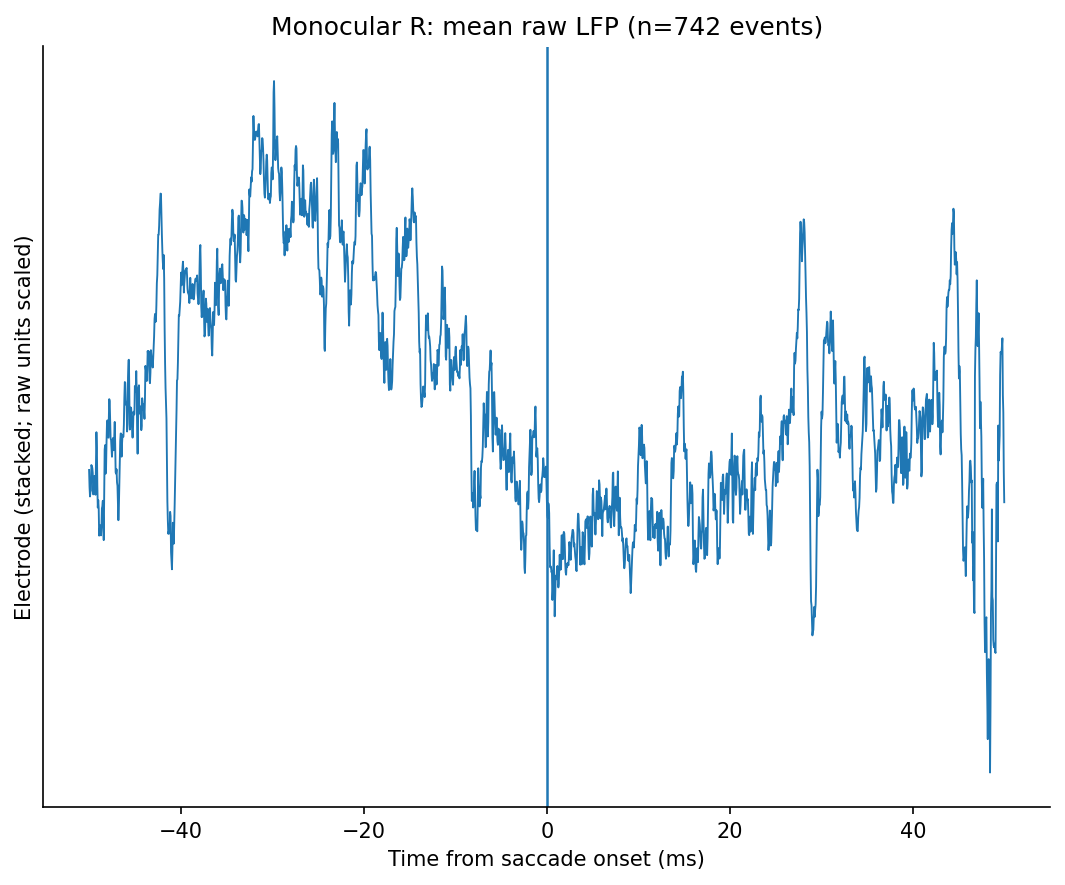

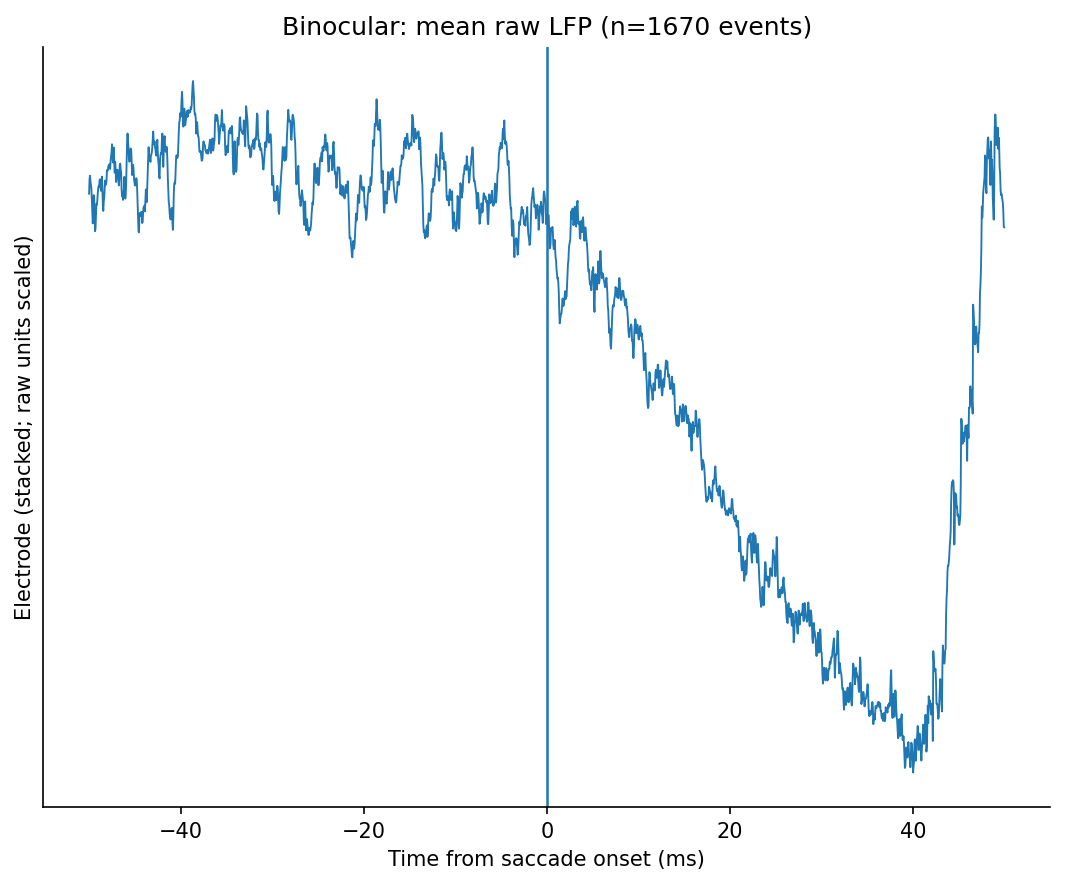

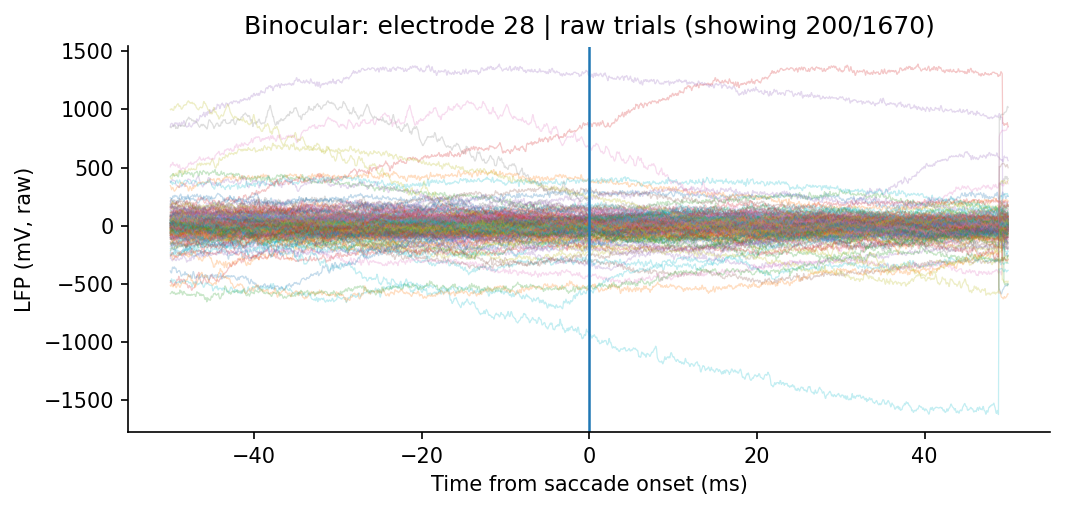

In [61]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

# ---------------- USER SETTINGS ----------------
pre_ms = 50
window_ms = 100

electrodes = [28]               # <-- can be a single int OR a list like [1,2,3,...]
plot_mean_stacked = True        # mean per electrode, stacked
plot_raw_trials_for = 28        # set to an electrode number to view raw trials, or None

# Conditions: assumes you already made these arrays exactly like your snippet:
# monocular_left, monocular_right, binocular
# (If you only have L/R right now, comment out binocular block below)
# ----------------------------------------------


def _ensure_list_of_ints(x):
    if isinstance(x, (int, np.integer)):
        return [int(x)]
    arr = np.asarray(x).reshape(-1)
    return [int(v) for v in arr]

def _rel_time_axis(block, n_samp, pre_ms):
    sample_ms = float(getattr(block.oe_rec, "sample_ms"))
    return np.arange(n_samp) * sample_ms - float(pre_ms)

def _get_raw(block, electrodes, onsets_ms, pre_ms, window_ms):
    """
    Returns data: [n_ch, n_events, n_samp]
    Uses get_data as-is (no reshaping tricks beyond what you already do).
    """
    start_ms = np.asarray(onsets_ms, dtype=float) - float(pre_ms)
    data, ts = block.oe_rec.get_data(
        channels=electrodes,
        start_time_ms=start_ms,      # oldschool: 1D vector
        window_ms=float(window_ms),
        convert_to_mv=True,
        return_timestamps=True,
        repress_output=False
    )
    return np.asarray(data, dtype=float), ts

def _mean_sem_over_events(data_3d):
    """
    data_3d: [n_ch, n_events, n_samp]
    """
    mean = np.nanmean(data_3d, axis=1)
    n = data_3d.shape[1]
    sem = (np.nanstd(data_3d, axis=1, ddof=1) / np.sqrt(n)) if n >= 2 else np.full_like(mean, np.nan)
    return mean, sem, n

def _plot_stacked_means(t_rel, mean_ch, labels, title):
    """
    mean_ch: [n_ch, n_samp]
    """
    n_ch = mean_ch.shape[0]
    # robust scaling for stacking
    scale = np.nanmedian(np.nanstd(mean_ch, axis=1))
    if not np.isfinite(scale) or scale == 0:
        scale = 1.0
    offset = 3.0  # in "scaled units"

    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    for i in range(n_ch):
        ax.plot(t_rel, (mean_ch[i] / scale) + i * offset, lw=0.9, label=labels[i] if i < len(labels) else None)

    ax.axvline(0, lw=1.2)
    ax.set_xlabel("Time from saccade onset (ms)")
    ax.set_ylabel("Electrode (stacked; raw units scaled)")
    ax.set_title(title)
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.tight_layout()
    return fig, ax

def _plot_raw_trials(t_rel, data_3d, ch_index, title, max_trials=200):
    """
    Plot raw event traces for one channel index within data_3d.
    data_3d: [n_ch, n_events, n_samp]
    """
    x = data_3d[ch_index]  # [n_events, n_samp]
    n = x.shape[0]
    nplot = min(n, max_trials)

    fig, ax = plt.subplots(figsize=(7.2, 3.5))
    for i in range(nplot):
        ax.plot(t_rel, x[i], lw=0.6, alpha=0.25)
    ax.axvline(0, lw=1.2)
    ax.set_xlabel("Time from saccade onset (ms)")
    ax.set_ylabel("LFP (mV, raw)")
    ax.set_title(f"{title} | raw trials (showing {nplot}/{n})")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.tight_layout()
    return fig, ax


# ---------------- RUN ----------------
electrodes = _ensure_list_of_ints(electrodes)

# Build condition dict (comment out binocular if you don’t have it yet)
conditions = {
    "Monocular L": monocular_left,
    "Monocular R": monocular_right,
    "Binocular":   binocular,
}

for cond_name, onsets in conditions.items():
    if onsets is None or len(onsets) == 0:
        print(f"Skipping {cond_name}: no events")
        continue

    data, _ = _get_raw(block, electrodes, onsets, pre_ms, window_ms)  # [n_ch, n_events, n_samp]
    t_rel = _rel_time_axis(block, data.shape[2], pre_ms)

    mean_ch, sem_ch, n_events = _mean_sem_over_events(data)

    if plot_mean_stacked:
        labels = [f"ch {e}" for e in electrodes]
        fig, ax = _plot_stacked_means(
            t_rel,
            mean_ch,
            labels,
            title=f"{cond_name}: mean raw LFP (n={n_events} events)"
        )
        # Optional save:
        # fig.savefig(f"{cond_name.replace(' ','_')}_mean_raw_LFP_stacked.pdf", bbox_inches="tight")

    # Raw trials view for a selected electrode
    if plot_raw_trials_for is not None and int(plot_raw_trials_for) in electrodes:
        ch_idx = electrodes.index(int(plot_raw_trials_for))
        fig, ax = _plot_raw_trials(
            t_rel,
            data,
            ch_index=ch_idx,
            title=f"{cond_name}: electrode {plot_raw_trials_for}"
        )
        # Optional save:
        # fig.savefig(f"{cond_name.replace(' ','_')}_raw_trials_ch{plot_raw_trials_for}.pdf", bbox_inches="tight")

plt.show()


In [16]:
#clean monocular saccade df from false detections (actually not monocular):
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Helper: find left/right per-frame eye trace dfs in a block
# ------------------------------------------------------------
def _get_eye_df_from_block(block, candidates):
    for attr in candidates:
        if hasattr(block, attr):
            df = getattr(block, attr)
            if isinstance(df, pd.DataFrame) and len(df) > 0:
                return df
    return None


def build_eye_trace_lookup_from_block_collection(
    block_collection,
    animal_attr="animal_call",
    block_attr="block_num",
    left_df_attrs=None,
    right_df_attrs=None,
):
    """
    Returns:
      eye_trace_lookup[(animal, block, 'L'/'R')] = per-frame eye dataframe

    Notes:
    - You may need to adjust left_df_attrs/right_df_attrs to match your BlockSync object fields.
    """
    if left_df_attrs is None:
        left_df_attrs = ["left_eye_data","l_eye_df", "left_eye_df", "l_df", "left_df", "l_eye_data_df", "left_eye_data_df"]
    if right_df_attrs is None:
        right_df_attrs = ["right_eye_data","r_eye_df", "right_eye_df", "r_df", "right_df", "r_eye_data_df", "right_eye_data_df"]

    lookup = {}
    for blk in block_collection:
        animal = getattr(blk, animal_attr, "unknown")
        bnum = getattr(blk, block_attr, "unknown")

        ldf = _get_eye_df_from_block(blk, left_df_attrs)
        rdf = _get_eye_df_from_block(blk, right_df_attrs)

        if ldf is not None:
            lookup[(animal, bnum, "L")] = ldf
        if rdf is not None:
            lookup[(animal, bnum, "R")] = rdf

    return lookup


# ------------------------------------------------------------
# Core: verify monocular by checking other-eye speed near onset
# ------------------------------------------------------------
def annotate_monocular_by_other_eye_speed(
    non_synced_df,
    eye_trace_lookup,
    t0_col="saccade_on_ms",
    eye_col="eye",
    animal_col="animal",
    block_col="block",
    ms_col="ms_axis",
    speed_col="angular_speed_r",
    window_ms=80,
    speed_thresh=5.0,
):
    """
    Adds:
      - other_eye_peak_speed
      - verified_monocular (True/False/NaN)
        True  = other-eye peak speed < speed_thresh in +/- window_ms
        False = other-eye peak speed >= speed_thresh
        NaN   = missing trace/cols/window

    Returns: annotated dataframe
    """
    d = non_synced_df.copy()

    # Support alternative eye labeling if needed (e.g., 'Sub' == 'L'/'R')
    if eye_col not in d.columns and "Sub" in d.columns:
        d[eye_col] = d["Sub"]

    peaks = []
    verified = []

    for _, r in d.iterrows():
        try:
            animal = r[animal_col]
            block = r[block_col]
            eye = r[eye_col]
            t0 = float(r[t0_col])
        except Exception:
            peaks.append(np.nan)
            verified.append(np.nan)
            continue

        if not np.isfinite(t0) or eye not in ("L", "R"):
            peaks.append(np.nan)
            verified.append(np.nan)
            continue

        other_eye = "R" if eye == "L" else "L"
        key = (animal, block, other_eye)

        if key not in eye_trace_lookup:
            peaks.append(np.nan)
            verified.append(np.nan)
            continue

        tr = eye_trace_lookup[key]
        if (ms_col not in tr.columns) or (speed_col not in tr.columns):
            peaks.append(np.nan)
            verified.append(np.nan)
            continue

        ms = tr[ms_col].astype(float).to_numpy()
        sp = tr[speed_col].astype(float).to_numpy()

        m = (ms >= (t0 - window_ms)) & (ms <= (t0 + window_ms)) & np.isfinite(sp)
        if not np.any(m):
            peaks.append(np.nan)
            verified.append(np.nan)
            continue

        peak = float(np.nanmax(sp[m]))
        peaks.append(peak)
        verified.append(bool(peak < float(speed_thresh)))

    d["other_eye_peak_speed"] = np.asarray(peaks, dtype=float)
    d["verified_monocular"] = verified
    return d


def create_verified_monocular_saccade_collection(
    non_synced_saccade_collection,
    block_collection,
    t0_col="saccade_on_ms",
    ms_col="ms_axis",
    speed_col="angular_speed_r",
    window_ms=80,
    speed_thresh=5.0,
    keep_unverifiable=False,
    verbose=True,
):
    """
    Pipeline entry-point:
      Input: non_synced_saccade_collection (your monocular candidates)
      Output:
        - verified_monocular_saccade_collection (subset)
        - annotated_non_synced_df (with other_eye_peak_speed + verified_monocular column)
        - diagnostics dict
    """
    eye_trace_lookup = build_eye_trace_lookup_from_block_collection(block_collection)

    annotated = annotate_monocular_by_other_eye_speed(
        non_synced_df=non_synced_saccade_collection,
        eye_trace_lookup=eye_trace_lookup,
        t0_col=t0_col,
        ms_col=ms_col,
        speed_col=speed_col,
        window_ms=window_ms,
        speed_thresh=speed_thresh,
    )

    vc = annotated["verified_monocular"].value_counts(dropna=False)
    n_true = int(vc.get(True, 0))
    n_false = int(vc.get(False, 0))
    n_nan = int(vc.get(np.nan, 0))
    n_total = len(annotated)

    if keep_unverifiable:
        # treat NaN as "not verified but keep"
        verified_df = annotated.loc[(annotated["verified_monocular"] == True) | (annotated["verified_monocular"].isna())].copy()
    else:
        verified_df = annotated.loc[annotated["verified_monocular"] == True].copy()

    diagnostics = {
        "lookup_entries": len(eye_trace_lookup),
        "n_total_non_synced": n_total,
        "n_verified_true": n_true,
        "n_verified_false": n_false,
        "n_verified_nan": n_nan,
        "verified_fraction_of_classifiable": (n_true / float(n_true + n_false)) if (n_true + n_false) > 0 else np.nan,
        "nan_fraction": (n_nan / float(n_total)) if n_total > 0 else np.nan,
        "speed_col": speed_col,
        "speed_thresh": speed_thresh,
        "window_ms": window_ms,
    }

    if verbose:
        print("Lookup entries:", diagnostics["lookup_entries"])
        print("verified_monocular counts:", vc.to_dict())
        print("Verified fraction (of classifiable True/False):", diagnostics["verified_fraction_of_classifiable"])

    return verified_df, annotated, diagnostics

verified_monocular_saccade_collection, non_synced_annotated, mono_diag = create_verified_monocular_saccade_collection(
    non_synced_saccade_collection=non_synced_saccade_collection,
    block_collection=block_collection,          # IMPORTANT: use the full/original one
    speed_col="angular_speed_r",                # or "speed_r" if that's what your eye dfs have
    ms_col="ms_axis",
    t0_col="saccade_on_ms",
    window_ms=80,
    speed_thresh=0.8,                   # use the threshold you just tuned
    keep_unverifiable=False,                    # strict
    verbose=True,
)


Lookup entries: 2
verified_monocular counts: {False: 812, True: 478, nan: 119}
Verified fraction (of classifiable True/False): 0.3705426356589147


In [17]:
import numpy as np
import pandas as pd
from typing import Tuple

def compute_event_stats_from_synced_tables(
    synced_saccade_collection: pd.DataFrame,
    non_synced_saccade_collection: pd.DataFrame,
    head_col: str = "head_movement",
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Uses your existing verified annotation:
      - synced_saccade_collection: paired L/R saccades, with columns ['Main','Sub', ...] after reset_index()
      - non_synced_saccade_collection: unpaired single-eye saccades

    Returns:
      per_animal_df, overall_df
    """

    # -----------------------
    # 1) Build event-level df
    # -----------------------
    events = []

    # Binocular events: group by (animal, block, Main) in synced collection
    if len(synced_saccade_collection) > 0:
        required = set(["animal", "block", "Main", head_col])
        missing = required - set(synced_saccade_collection.columns)
        if missing:
            raise ValueError("synced_saccade_collection missing columns: %s" % sorted(list(missing)))

        gcols = ["animal", "block", "Main"]
        for (animal, block, main), g in synced_saccade_collection.groupby(gcols, dropna=False):
            # event is binocular by definition
            # head movement at event-level: OR across the two eyes (robust)
            head_m = bool(np.any(g[head_col].astype(bool).to_numpy()))
            events.append(dict(
                animal=animal,
                block=block,
                event_type="binocular",
                head_movement=head_m,
            ))

    # Monocular events: each row is one event
    if len(non_synced_saccade_collection) > 0:
        required = set(["animal", "block", head_col])
        missing = required - set(non_synced_saccade_collection.columns)
        if missing:
            raise ValueError("non_synced_saccade_collection missing columns: %s" % sorted(list(missing)))

        for _, r in non_synced_saccade_collection.iterrows():
            events.append(dict(
                animal=r["animal"],
                block=r["block"],
                event_type="monocular",
                head_movement=bool(r[head_col]),
            ))

    events = pd.DataFrame(events)
    if events.empty:
        raise RuntimeError("No events created. Check that synced/non-synced tables are non-empty.")

    # -----------------------
    # 2) Per-animal summary
    # -----------------------
    out = []
    for animal, aev in events.groupby("animal"):
        total = len(aev)
        still = aev.loc[~aev["head_movement"].astype(bool)]
        moving = aev.loc[aev["head_movement"].astype(bool)]

        def pct_monocular(df):
            if len(df) == 0:
                return np.nan
            return 100.0 * np.mean(df["event_type"].to_numpy() == "monocular")

        out.append(dict(
            animal=animal,
            n_events=total,
            pct_events_head_still=100.0 * len(still) / total if total else np.nan,
            pct_events_head_moving=100.0 * len(moving) / total if total else np.nan,
            pct_monocular_when_head_still=pct_monocular(still),
            pct_monocular_when_head_moving=pct_monocular(moving),
            n_head_still=len(still),
            n_head_moving=len(moving),
        ))

    per_animal = pd.DataFrame(out).sort_values("animal").reset_index(drop=True)

    # -----------------------
    # 3) Overall summary
    # -----------------------
    def mean_sem(x):
        x = np.asarray(x, dtype=float)
        x = x[np.isfinite(x)]
        if x.size == 0:
            return np.nan, np.nan
        mean = float(np.mean(x))
        sem = float(np.std(x, ddof=1) / np.sqrt(x.size)) if x.size > 1 else np.nan
        return mean, sem

    pooled_pct_head_still = 100.0 * np.mean(~events["head_movement"].astype(bool))
    pooled_pct_mono_still = (
        100.0 * np.mean(events.loc[~events["head_movement"].astype(bool), "event_type"].to_numpy() == "monocular")
        if np.any(~events["head_movement"].astype(bool)) else np.nan
    )
    pooled_pct_mono_moving = (
        100.0 * np.mean(events.loc[events["head_movement"].astype(bool), "event_type"].to_numpy() == "monocular")
        if np.any(events["head_movement"].astype(bool)) else np.nan
    )

    m1, s1 = mean_sem(per_animal["pct_events_head_still"])
    m2, s2 = mean_sem(per_animal["pct_monocular_when_head_still"])
    m3, s3 = mean_sem(per_animal["pct_monocular_when_head_moving"])

    overall = pd.DataFrame([
        dict(metric="pct_events_head_still",
             mean_across_animals=m1, sem_across_animals=s1,
             pooled_value=pooled_pct_head_still, pooled_n_events=len(events)),
        dict(metric="pct_monocular_when_head_still",
             mean_across_animals=m2, sem_across_animals=s2,
             pooled_value=pooled_pct_mono_still, pooled_n_events=len(events)),
        dict(metric="pct_monocular_when_head_moving",
             mean_across_animals=m3, sem_across_animals=s3,
             pooled_value=pooled_pct_mono_moving, pooled_n_events=len(events)),
    ])

    return per_animal, overall
compute_event_stats_from_synced_tables(synced_saccade_collection,verified_monocular_saccade_collection)

(   animal  n_events  pct_events_head_still  pct_events_head_moving  \
 0  PV_208      1313              89.946687               10.053313   
 
    pct_monocular_when_head_still  pct_monocular_when_head_moving  \
 0                      39.373412                        9.848485   
 
    n_head_still  n_head_moving  
 0          1181            132  ,
                            metric  mean_across_animals  sem_across_animals  \
 0           pct_events_head_still            89.946687                 NaN   
 1   pct_monocular_when_head_still            39.373412                 NaN   
 2  pct_monocular_when_head_moving             9.848485                 NaN   
 
    pooled_value  pooled_n_events  
 0     89.946687             1313  
 1     39.373412             1313  
 2      9.848485             1313  )

In [18]:
# verify the numerousity of monocular events here:
import numpy as np
import pandas as pd

def relabel_pairs_by_window_overlap(
    synced_saccade_collection: pd.DataFrame,
    non_synced_saccade_collection: pd.DataFrame,
    all_saccade_collection: pd.DataFrame,
    on_col: str = "saccade_on_ms",
    off_col: str = "saccade_off_ms",
    eye_col: str = "eye",
    animal_col: str = "animal",
    block_col: str = "block",
    max_onset_dt_ms: float = 40.0,
    min_overlap_ms: float = 0.0,
):
    """
    Re-check each 'non_synced' event: does the other eye have a saccade whose window overlaps?
    If yes -> reclassify as binocular (was "missed pair").
    Requires all_saccade_collection to include BOTH eyes' saccade windows (L+R) with on/off times.
    """

    # Start by treating current synced as binocular events; non_synced as monocular candidates
    non = non_synced_saccade_collection.copy()

    # Make sure we know which eye each non-synced event belongs to
    if eye_col not in non.columns:
        raise ValueError("non_synced_saccade_collection must include an 'eye' column (L/R).")

    # We'll look up candidate matches in the opposite eye within each animal+block
    all_df = all_saccade_collection.copy()

    # Basic guards
    for c in [animal_col, block_col, eye_col, on_col, off_col]:
        if c not in all_df.columns:
            raise ValueError(f"all_saccade_collection missing required column: {c}")

    # Index all events by animal+block for fast filtering
    grouped = dict(tuple(all_df.groupby([animal_col, block_col], dropna=False)))

    reclassified = np.zeros(len(non), dtype=bool)

    for i, r in non.iterrows():
        key = (r[animal_col], r[block_col])
        if key not in grouped:
            continue

        eye = r[eye_col]
        other_eye = "R" if eye == "L" else "L"
        s0 = float(r[on_col])
        s1 = float(r[off_col])
        if not (np.isfinite(s0) and np.isfinite(s1)):
            continue

        cand = grouped[key]
        cand = cand[cand[eye_col] == other_eye]

        if cand.empty:
            continue

        # onset proximity constraint (optional but helps avoid nonsense matches)
        cand_on = cand[on_col].astype(float).to_numpy()
        onset_dt = np.abs(cand_on - s0)
        cand = cand.loc[onset_dt <= max_onset_dt_ms]
        if cand.empty:
            continue

        # overlap condition
        c0 = cand[on_col].astype(float).to_numpy()
        c1 = cand[off_col].astype(float).to_numpy()
        overlap = np.minimum(s1, c1) - np.maximum(s0, c0)  # positive => overlap in ms

        if np.any(overlap >= min_overlap_ms):
            reclassified[i] = True

    # Build adjusted event tables
    non["reclassified_as_binocular"] = reclassified
    adj_non_synced = non.loc[~non["reclassified_as_binocular"]].copy()

    # Return updated non-synced + a count
    return adj_non_synced, int(np.sum(reclassified))

adj_non, n_repaired = relabel_pairs_by_window_overlap(
    synced_saccade_collection,
    non_synced_saccade_collection,
    all_saccade_collection,
    max_onset_dt_ms=40,     # start with 20–60 ms
    min_overlap_ms=0,       # or try 5–10 ms
)
print("Repaired (formerly 'monocular' but window-overlap matched):", n_repaired)


IndexError: index 1415 is out of bounds for axis 0 with size 1409

In [25]:
def confirm_monocular_by_other_eye_speed(
    non_synced_df: pd.DataFrame,
    eye_trace_lookup: dict,
    # eye_trace_lookup[(animal, block, eye)] -> dataframe with ms_axis and speed column
    t0_col="saccade_on_ms",
    eye_col="eye",
    animal_col="animal",
    block_col="block",
    ms_col="ms_axis",
    speed_col="angular_speed_r",
    window_ms=80,
    speed_thresh=150,  # set based on your speed units/distribution
):
    """
    Labels each non-synced event as 'confirmed_monocular' if the other eye has NO speed peak
    above speed_thresh in +/- window_ms around event onset.
    """
    d = non_synced_df.copy()
    confirmed = []

    for _, r in d.iterrows():
        animal, block, eye = r[animal_col], r[block_col], r[eye_col]
        other_eye = "R" if eye == "L" else "L"
        t0 = float(r[t0_col])

        key = (animal, block, other_eye)
        if key not in eye_trace_lookup:
            confirmed.append(np.nan)
            continue

        tr = eye_trace_lookup[key]
        if ms_col not in tr.columns or speed_col not in tr.columns:
            confirmed.append(np.nan)
            continue

        ms = tr[ms_col].astype(float).to_numpy()
        sp = tr[speed_col].astype(float).to_numpy()

        m = (ms >= t0 - window_ms) & (ms <= t0 + window_ms) & np.isfinite(sp)
        if not np.any(m):
            confirmed.append(np.nan)
            continue

        peak = np.nanmax(sp[m])
        confirmed.append(bool(peak < speed_thresh))

    d["confirmed_monocular_by_speed"] = confirmed
    return d

import numpy as np
import pandas as pd

# --- paste/keep your function definition somewhere above this cell ---
# def confirm_monocular_by_other_eye_speed(...): ...


def build_eye_trace_lookup_from_block_collection(
    block_collection,
    eye_df_attr_left="left_eye_data",
    eye_df_attr_right="right_eye_data",
    animal_attr="animal_call",
    block_attr="block_num",
):
    """
    Returns:
      eye_trace_lookup[(animal, block, 'L'/'R')] = per-frame dataframe
    """
    eye_trace_lookup = {}

    for blk in block_collection:
        animal = getattr(blk, animal_attr, "unknown")
        bnum = getattr(blk, block_attr, "unknown")

        ldf = getattr(blk, eye_df_attr_left, None)
        rdf = getattr(blk, eye_df_attr_right, None)

        if isinstance(ldf, pd.DataFrame) and len(ldf) > 0:
            eye_trace_lookup[(animal, bnum, "L")] = ldf

        if isinstance(rdf, pd.DataFrame) and len(rdf) > 0:
            eye_trace_lookup[(animal, bnum, "R")] = rdf

    return eye_trace_lookup


# ------------------------
# 1) Build lookup table
# ------------------------
eye_trace_lookup = build_eye_trace_lookup_from_block_collection(block_collection)

print("Lookup entries:", len(eye_trace_lookup))
# Example keys: next(iter(eye_trace_lookup.keys()))


# ------------------------
# 2) Run confirmation test
# ------------------------
# IMPORTANT:
# - t0_col should match what you want to anchor on (onset is usually best): 'saccade_on_ms'
# - ms_col must exist in eye dfs: usually 'ms_axis'
# - speed_col must exist: try 'angular_speed_r' first, else maybe 'speed_r'
# - speed_thresh must be in the same units as speed_col

non_confirmed = confirm_monocular_by_other_eye_speed(
    non_synced_df=non_synced_saccade_collection,
    eye_trace_lookup=eye_trace_lookup,
    t0_col="saccade_on_ms",
    eye_col="eye",
    animal_col="animal",
    block_col="block",
    ms_col="ms_axis",
    speed_col="angular_speed_r",
    window_ms=80,          # start with ±80 ms; also try 50/100
    speed_thresh=0.8,
)

# ------------------------
# 3) Summarize results
# ------------------------
# confirmed_monocular_by_speed == True  -> other eye stayed below threshold (confirmed monocular)
# confirmed_monocular_by_speed == False -> other eye had a speed peak (likely "missed binocular")
# confirmed_monocular_by_speed == NaN   -> missing trace / columns / window

print(non_confirmed["confirmed_monocular_by_speed"].value_counts(dropna=False))

# Optional: confirm rates by head condition (if head_movement exists in non_synced df)
if "head_movement" in non_confirmed.columns:
    tmp = non_confirmed.copy()
    tmp["head_state"] = np.where(tmp["head_movement"].astype(bool), "moving", "still")
    print(
        tmp.groupby("head_state")["confirmed_monocular_by_speed"]
           .value_counts(normalize=True, dropna=False)
    )


# ------------------------
# 4) (Recommended) Tune speed_thresh empirically
# ------------------------
# Look at the distribution of the OTHER-eye peak speeds around non-synced events
# by temporarily modifying the function to store peak, or do a quick estimate here:

def compute_other_eye_peak_speeds(
    non_synced_df, eye_trace_lookup,
    t0_col="saccade_on_ms", eye_col="eye", animal_col="animal", block_col="block",
    ms_col="ms_axis", speed_col="angular_speed_r",
    window_ms=80
):
    peaks = []
    for _, r in non_synced_df.iterrows():
        animal, block, eye = r[animal_col], r[block_col], r[eye_col]
        other_eye = "R" if eye == "L" else "L"
        t0 = float(r[t0_col])
        key = (animal, block, other_eye)
        if key not in eye_trace_lookup:
            peaks.append(np.nan)
            continue
        tr = eye_trace_lookup[key]
        if ms_col not in tr.columns or speed_col not in tr.columns:
            peaks.append(np.nan)
            continue
        ms = tr[ms_col].astype(float).to_numpy()
        sp = tr[speed_col].astype(float).to_numpy()
        m = (ms >= t0 - window_ms) & (ms <= t0 + window_ms) & np.isfinite(sp)
        if not np.any(m):
            peaks.append(np.nan)
        else:
            peaks.append(float(np.nanmax(sp[m])))
    return np.asarray(peaks, dtype=float)

peaks = compute_other_eye_peak_speeds(
    non_synced_saccade_collection, eye_trace_lookup,
    speed_col="angular_speed_r", window_ms=80
)

print("Other-eye peak speed percentiles (non-synced events):",
      np.nanpercentile(peaks, [50, 75, 90, 95, 99]))


Lookup entries: 46
False    6561
True     6052
NaN      1679
Name: confirmed_monocular_by_speed, dtype: int64
head_state  confirmed_monocular_by_speed
moving      False                           0.520108
            True                            0.393548
            NaN                             0.086344
still       True                            0.479167
            False                           0.345353
            NaN                             0.175481
Name: confirmed_monocular_by_speed, dtype: float64
Other-eye peak speed percentiles (non-synced events): [ 1.06764261  2.8285699   5.01649533  6.59673655 11.82123613]


In [19]:
print(synced_saccade_collection.groupby(["animal","block","Main"]).size().value_counts())


2    835
dtype: int64


In [33]:
def get_zscored_column(df,column_to_zscore):
    mean = df[column_to_zscore].mean(skipna=True)
    std = df[column_to_zscore].std(skipna=True)
    zscore_column = (df[column_to_zscore] - mean) / std
    df[column_to_zscore + '_zscore'] = zscore_column
    return df

def calculate_average_psd(block, windows_start_ms, windows_length_ms, nperseg=20000, noverlap=10000, electrode_to_use=[15]):
    """
    This function expects a segments variable that looks like this:
    [(segment1_start_ms,segment1_length_ms), (segment2_start_ms,segment2_length_ms), ... ect.]
    and will return the average PSD for the time segments in question
    :param segments:
    :return:
    """
    neuro_data_list = []
    neuro_timestamp_list = []
    overall_length = 0
    overall_used = 0
    for i, (window_start, window_length) in enumerate(zip(windows_start_ms,windows_length_ms)):

        try:
            neuro_data, neuro_timestamps = block.oe_rec.get_data(channels= electrode_to_use,
                                                                 start_time_ms=[window_start],
                                                                 window_ms = [window_length],
                                                                 convert_to_mv=True,
                                                                 return_timestamps=True, repress_output=True)
        except TypeError:
            neuro_data = None
            neuro_timestamps = None

        if neuro_data is not None:
            neuro_data_list.append(neuro_data)
            neuro_timestamp_list.append(neuro_timestamps)
            overall_length += window_length
            overall_used += 1
        else:
            print(f'had problem with block {block.block_num} segment {i} of length = {window_length}')
    all_psds = []

    for array in neuro_data_list:
        a = np.squeeze(array)
        f, pxx = signal.welch(a, fs=block.sample_rate, nperseg=nperseg, noverlap=noverlap)
        all_psds.append(pxx)
    average_psd = np.mean(all_psds, axis=0)

    return f, average_psd, overall_length, overall_used

def chunk_times_old(times, min_gap=17.5, min_length=1000):
    """Chunks a list of times into consecutive and non-consecutive samples.

    Args:
        times: A list of time values (in milliseconds).
        min_gap: The minimum time gap in milliseconds to consider samples non-consecutive.
        min_length: The minimum chunk length in milliseconds to keep (default: 1000).

    Returns:
        list: A list of tuples (start_time, length) for each chunk meeting the criteria.
    """
    chunks = []
    current_chunk_start = times[0]

    for i in range(1, len(times)):
        time_diff = times[i] - times[i - 1]

        if time_diff > min_gap:
            # End the current chunk and start a new one
            chunk_length = times[i - 1] - current_chunk_start
            if chunk_length >= min_length:  # Filter by minimum length
                chunks.append((current_chunk_start, chunk_length))
            current_chunk_start = times[i]

    # Handle the last chunk
    chunk_length = times[-1] - current_chunk_start
    if chunk_length >= min_length:
        chunks.append((current_chunk_start, chunk_length))

    return chunks

def chunk_times(times, chunk_threshold=170, min_chunk_length=1000):

    diff_arr = np.diff(times)
    gaps = diff_arr > chunk_threshold
    chunks_end_inds = np.where(gaps == True)[0]
    chunks_start_inds = chunks_end_inds + 1
    chunks_start_inds = np.insert(chunks_start_inds,0,0)
    chunks_start = times[chunks_start_inds]
    chunks_end_inds = np.insert(chunks_end_inds,len(chunks_end_inds),len(times)-1)
    chunks_end = times[chunks_end_inds]

    chunks_length = chunks_end - chunks_start
    length_filter = chunks_length > min_chunk_length
    chunks_length = chunks_length[length_filter]
    chunks_start = chunks_start[length_filter]


    return chunks_start, chunks_length

def analyze_pupil_psds(blocks, thresholds, nperseg=20000, noverlap=10000, eye='Left', plot_normalized=True, export_path=False, log_scale=False):
    """Analyzes and plots PSDs for different pupil diameter thresholds across multiple blocks.

    Args:
        blocks: A list of block objects.
        thresholds: A list of z-score thresholds for pupil diameter.
        nperseg: Length of each segment for Welch's method (default: 20000).
        noverlap: Number of points to overlap between segments (default: 10000).
    """
    fig, axs = plt.subplots(len(thresholds), figsize=(10, 6 * len(thresholds)), dpi=100)

    for i, threshold in enumerate(thresholds):
        ax = axs[i] if len(thresholds) > 1 else axs  # Handle single subplot case
        all_psds = []
        all_large_pupil_psds = []
        all_small_pupil_psds = []
        all_large_pupil_durations = []
        all_small_pupil_durations = []

        for block in blocks:
            if eye == 'left':
                eye_df = block.left_eye_data
            elif eye == 'right':
                eye_df = block.right_eye_data

            df = get_zscored_column(eye_df.copy(), 'pupil_diameter')

            large_timestamps = df.query(f'pupil_diameter_zscore > {threshold}').ms_axis
            small_timestamps = df.query(f'pupil_diameter_zscore < -{threshold}').ms_axis

            large_chunks = chunk_times(large_timestamps.values, chunk_threshold=1000, min_chunk_length=2000)
            small_chunks = chunk_times(small_timestamps.values, chunk_threshold=1000, min_chunk_length=2000)

            try:
                _, large_pupil_psd = calculate_average_psd(block, large_chunks, nperseg, noverlap)
                _, small_pupil_psd = calculate_average_psd(block, small_chunks, nperseg, noverlap)

                all_psds.append(large_pupil_psd)
                all_psds.append(small_pupil_psd)
                all_large_pupil_psds.append(large_pupil_psd)
                all_small_pupil_psds.append(small_pupil_psd)


                # Calculate and store durations in seconds
                large_pupil_duration = sum(chunk[1] for chunk in large_chunks) / 1000
                small_pupil_duration = sum(chunk[1] for chunk in small_chunks) / 1000

                all_large_pupil_durations.append(large_pupil_duration)
                all_small_pupil_durations.append(small_pupil_duration)
            except TypeError:
                print(f'block {block} has a  problem at this threshold')
        # Calculate averages
        avg_large_pupil_psd = np.mean(all_large_pupil_psds, axis=0)
        avg_small_pupil_psd = np.mean(all_small_pupil_psds, axis=0)
        avg_psd = np.mean(all_psds, axis=0)
        normalized_large_pupil_psd = avg_large_pupil_psd / avg_psd
        normalized_small_pupil_psd = avg_small_pupil_psd / avg_psd

        total_large_pupil_duration = np.sum(all_large_pupil_durations)
        total_small_pupil_duration = np.sum(all_small_pupil_durations)

        # Plot
        f = calculate_average_psd(block, large_chunks, nperseg, noverlap)[0]  # Get frequency values
        if plot_normalized:
            ax.plot(f, normalized_large_pupil_psd, label=f'Normalized Large Pupil (Total Duration: {total_large_pupil_duration:.1f} s)')
            ax.plot(f, normalized_small_pupil_psd, label=f'Nomrlaized Small Pupil (Total Duration: {total_small_pupil_duration:.1f} s)')
        else:
            ax.plot(f, avg_large_pupil_psd, label=f'Average Large Pupil (Total Duration: {total_large_pupil_duration:.1f} s)')
            ax.plot(f, avg_small_pupil_psd, label=f'Average Small Pupil (Total Duration: {total_small_pupil_duration:.1f} s)')
        ax.set_xlim(0, 30)
        #ax.set_ylim(0, 400)
        ax.set_xlabel('Frequency [Hz]', fontsize=12)
        ax.set_ylabel('Power', fontsize=12)
        ax.set_title(f'PSD for Pupil Diameter Threshold: {threshold}, eye: {eye}', fontsize=14)
        ax.legend(fontsize=10)
        if log_scale:
            ax.set_yscale('log')

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=8)

    plt.tight_layout()
    if export_path:
        if not isinstance(export_path, pathlib.Path):
            raise TypeError("export_path must be a pathlib.Path object or False.")
        plt.savefig(export_path, format='pdf')
        print(f"Figure saved to {export_path}")

    plt.show()

    return large_chunks, small_chunks

def analyze_pupil_psds_bands(blocks,
                             thresholds,
                             nperseg=20000,
                             noverlap=10000,
                             eye='Left',
                             plot_normalized=True,
                             export_path=False,
                             log_scale=False,
                             electrode_to_use=[15]):
    """Analyzes and plots PSDs for different pupil diameter thresholds across multiple blocks.

    Args:
        blocks: A list of block objects.
        thresholds: A list of z-score thresholds for pupil diameter.
        nperseg: Length of each segment for Welch's method (default: 20000).
        noverlap: Number of points to overlap between segments (default: 10000).
    """
    fig, axs = plt.subplots(len(thresholds), figsize=(10, 6 * len(thresholds)), dpi=100)

    for i, threshold in enumerate(thresholds):
        ax = axs[i] if len(thresholds) > 1 else axs  # Handle single subplot case
        all_psds = []
        all_large_pupil_psds = []
        all_small_pupil_psds = []
        large_chunks_count = 0
        small_chunks_count = 0
        overall_large_length = 0
        overall_small_length = 0

        for block in blocks:
            if eye == 'left':
                eye_df = block.left_eye_data
            elif eye == 'right':
                eye_df = block.right_eye_data

            df = get_zscored_column(eye_df.copy(), 'pupil_diameter')

            large_timestamps = df.query(f'pupil_diameter_zscore > {threshold[0]} and pupil_diameter_zscore < {threshold[1]}').ms_axis
            small_timestamps = df.query(f'pupil_diameter_zscore < -{threshold[0]} and pupil_diameter_zscore > -{threshold[1]} ').ms_axis

            large_chunks_start, large_chunks_length = chunk_times(large_timestamps.values)
            small_chunks_start, small_chunks_length = chunk_times(small_timestamps.values)
            if len(large_chunks_start) == 0:
                print(block, 'problem')
            f, large_pupil_psd, chunks_length, chunks_used = calculate_average_psd(block,
                                                                                   large_chunks_start,
                                                                                   large_chunks_length,
                                                                                   nperseg,
                                                                                   noverlap)

            large_chunks_count += chunks_used
            overall_large_length += chunks_length

            _, small_pupil_psd, chunks_length, chunks_used = calculate_average_psd(block,
                                                                                   small_chunks_start,
                                                                                   small_chunks_length,
                                                                                   nperseg,
                                                                                   noverlap)
            small_chunks_count += chunks_used
            overall_small_length += chunks_length

            all_psds.append(large_pupil_psd)
            all_psds.append(small_pupil_psd)
            all_large_pupil_psds.append(large_pupil_psd)
            all_small_pupil_psds.append(small_pupil_psd)


        # Calculate averages
        avg_large_pupil_psd = np.mean(all_large_pupil_psds, axis=0)
        avg_small_pupil_psd = np.mean(all_small_pupil_psds, axis=0)
        avg_psd = np.mean(all_psds, axis=0)
        normalized_large_pupil_psd = avg_large_pupil_psd / avg_psd
        normalized_small_pupil_psd = avg_small_pupil_psd / avg_psd

        total_large_pupil_duration = overall_large_length / 1000
        total_small_pupil_duration = overall_small_length / 1000

        # Plot
        if plot_normalized:
            ax.plot(f, normalized_large_pupil_psd, label=f'Normalized Large Pupil (Total Duration: {total_large_pupil_duration:.1f} s) '
                                                         f'\n event count= {large_chunks_count}')
            ax.plot(f, normalized_small_pupil_psd, label=f'Nomrlaized Small Pupil (Total Duration: {total_small_pupil_duration:.1f} s)'
                                                         f'\n event count = {small_chunks_count}')
        else:
            ax.plot(f, avg_large_pupil_psd, label=f'Average Large Pupil (Total Duration: {total_large_pupil_duration:.1f} s)'
                                                  f'\n event count= {large_chunks_count}')
            ax.plot(f, avg_small_pupil_psd, label=f'Average Small Pupil (Total Duration: {total_small_pupil_duration:.1f} s)'
                                                  f'\n event count = {small_chunks_count}')
        ax.set_xlim(0, 30)
        #ax.set_ylim(0, 400)
        ax.set_xlabel('Frequency [Hz]', fontsize=12)
        ax.set_ylabel('Power', fontsize=12)
        ax.set_title(f'PSD for Pupil Diameter Threshold: {threshold}, eye: {eye}', fontsize=14)
        ax.legend(fontsize=10)
        if log_scale:
            ax.set_yscale('log')

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=8)

    plt.tight_layout()
    if export_path:
        if not isinstance(export_path, pathlib.Path):
            raise TypeError("export_path must be a pathlib.Path object or False.")
        plt.savefig(export_path, format='pdf')
        print(f"Figure saved to {export_path}")

    plt.show()

    return
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = pathlib.Path(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_pupil_diameter_psds_left_eye.pdf')
thresholds = [(0,0.5),(0.5,1.0),(1.0,1.5), (1.5,2.0), (1,np.inf)]  # Example list of thresholds
#blocks = [block_dict['039'],block_dict['040'], block_dict['041'], block_dict['057']]  # Example list of block objects
blocks = block_collection  # Example list of block objects
# l_large_chunks, l_small_chunks = analyze_pupil_psds(blocks,
#                                                     thresholds,
#                                                     eye='left',
#                                                     plot_normalized=False,
#                                                     export_path=False,
#                                                     log_scale=False)
analyze_pupil_psds_bands(blocks, thresholds, eye='left', plot_normalized=False, export_path=False, log_scale=False, electrode_to_use=[1])

In [21]:
# take 2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Union

# ---- PDF export settings for editability (Illustrator/Inkscape) ----
mpl.rcParams["pdf.fonttype"] = 42  # TrueType
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["svg.fonttype"] = "none"


def get_saccade_times_ms(all_saccade_collection,
                         eye=None,
                         t0_col="saccade_on_ms"):
    """
    Returns sorted saccade onset times in ms from your all_saccade_collection.
    eye: None / "L" / "R" (only works if a column named 'eye' exists)
    """
    d = all_saccade_collection.copy()
    if eye is not None and ("eye" in d.columns):
        d = d.query("eye == @eye").copy()

    t = pd.to_numeric(d[t0_col], errors="coerce").dropna().to_numpy(dtype=float)
    t = np.sort(t)
    return t


# Example:
saccade_times_ms = get_saccade_times_ms(all_saccade_collection, eye=None)

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def sanitize_channels(channels):
    """
    Ensure channels is a 1D python list of scalar ints (1-indexed),
    suitable for OERecording.get_data() which does channels[i]-1 indexing.
    """
    if channels is None:
        return None
    arr = np.asarray(channels)

    # Flatten MATLAB-ish shapes like (1, N) or (N, 1)
    arr = arr.reshape(-1)

    # Convert each entry to a plain python int (guards against array([x]) entries)
    out = []
    for x in arr:
        # x might be numpy scalar, python int, or array([int])
        x_arr = np.asarray(x).reshape(-1)
        if x_arr.size != 1:
            raise ValueError(f"Channel entries must be scalar; got {x} (shape {np.asarray(x).shape})")
        out.append(int(x_arr[0]))
    return out


def as_row_vector_ms(times_ms):
    """
    Force timestamps into shape (1, N) because OERecording.get_data()
    uses start_time_ms[0][i].
    """
    arr = np.asarray(times_ms, dtype=float).reshape(1, -1)
    return arr

# PDF editability: embed TrueType fonts (Illustrator-friendly)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["figure.dpi"] = 150

def get_saccade_onsets_ms(all_saccade_collection):
    """
    Returns 1D np.array of saccade onset times (ms).
    Accepts:
      - pandas DataFrame
      - object with `.df` or `.data` that is a DataFrame
    Tries common column names used in your pipeline.
    """
    df = None
    if isinstance(all_saccade_collection, pd.DataFrame):
        df = all_saccade_collection
    else:
        for attr in ("df", "data", "saccades_df"):
            if hasattr(all_saccade_collection, attr):
                cand = getattr(all_saccade_collection, attr)
                if isinstance(cand, pd.DataFrame):
                    df = cand
                    break

    if df is None:
        raise TypeError("Could not find a DataFrame inside all_saccade_collection.")

    # Common onset columns seen across your code
    candidates = ["saccade_on_ms", "saccade_start_ms", "saccade_start", "on_ms"]
    col = next((c for c in candidates if c in df.columns), None)
    if col is None:
        raise ValueError(f"Couldn't find onset column. Tried: {candidates}. Found: {list(df.columns)[:30]} ...")

    sacc_ms = df[col].astype(float).to_numpy()
    sacc_ms = sacc_ms[np.isfinite(sacc_ms)]
    return np.sort(sacc_ms)


def infer_all_channels_from_oe_rec(oe_rec):
    """
    Best-effort channel inference without touching oe_rec internals.
    Your get_data() doc indicates `self.channelNumbers` is the default when channels is empty/None.:contentReference[oaicite:2]{index=2}
    """
    for name in ("channelNumbers", "analogChannelNumbers", "accelChannelNumbers"):
        if hasattr(oe_rec, name):
            ch = getattr(oe_rec, name)
            try:
                ch = list(ch)
                if len(ch) > 0:
                    return ch
            except Exception:
                pass
    return None


def call_get_data_windows(oe_rec, channels, start_time_ms_1d, window_ms, convert_to_mv=True, return_timestamps=True):
    """
    Calls oe_rec.get_data(...) as-is.
    We try a few shape conventions for `start_time_ms` because implementations often differ
    (some expect 1D, some expect a 1xN "row vector", etc.).
    Your API states "a vector of window start times [1XN]"【user-provided docstring】,
    so we attempt 1D first, then 1xN.
    """
    st = np.asarray(start_time_ms_1d, dtype=float)

    # Try 1D
    try:
        out = oe_rec.get_data(
            channels=channels,
            start_time_ms=st,
            window_ms=float(window_ms),
            convert_to_mv=convert_to_mv,
            return_timestamps=return_timestamps,
            repress_output=True
        )
        return out
    except Exception as e1:
        # Try 1xN (row vector)
        try:
            st_row = st.reshape(1, -1)
            out = oe_rec.get_data(
                channels=channels,
                start_time_ms=st_row,
                window_ms=float(window_ms),
                convert_to_mv=convert_to_mv,
                return_timestamps=return_timestamps,
                repress_output=True
            )
            return out
        except Exception as e2:
            raise RuntimeError(
                "oe_rec.get_data failed for both 1D and 1xN start_time_ms.\n"
                f"1D error: {repr(e1)}\n"
                f"1xN error: {repr(e2)}"
            )



In [30]:
def saccade_triggered_lfp_all_channels(block, saccade_times_ms,
                                       window_ms=500, pre_ms=200,
                                       baseline_ms=(-150, -50),
                                       channels=None,
                                       convert_to_mv=True,
                                       verbose=True):
    oe = block.oe_rec  # OERecording

    # --- channels: default to ALL channels in the recording ---
    if channels is None:
        channels = sanitize_channels(oe.channelNumbers)
    else:
        channels = sanitize_channels(channels)

    # --- window starts must be (1, N) for get_data() ---
    saccade_times_ms = np.asarray(saccade_times_ms, dtype=float).reshape(-1)
    start_times_ms = saccade_times_ms - float(pre_ms)
    start_times_ms = as_row_vector_ms(start_times_ms)

    # --- pull data: data_matrix shape should be [n_channels, n_windows, n_samples] ---
    data_matrix, ts_matrix = oe.get_data(
        channels=channels,
        start_time_ms=start_times_ms,
        window_ms=window_ms,
        convert_to_mv=convert_to_mv,
        return_timestamps=True,
        repress_output=(not verbose),
    )

    # Build a clean relative time axis (ms) using the sampling step used by OERecording
    sample_ms = float(oe.sample_ms)
    n_samp = data_matrix.shape[2]
    pre_ms_used = round(pre_ms / sample_ms) * sample_ms
    t_rel_ms = np.arange(n_samp) * sample_ms - pre_ms_used

    # Baseline subtract per (channel, window)
    b0, b1 = baseline_ms
    bmask = (t_rel_ms >= b0) & (t_rel_ms <= b1)
    baseline = np.nanmean(data_matrix[:, :, bmask], axis=2, keepdims=True)
    data_bs = data_matrix - baseline

    mean_lfp = np.nanmean(data_bs, axis=1)  # (n_channels, n_samples)
    sem_lfp  = np.nanstd(data_bs, axis=1, ddof=1) / np.sqrt(data_bs.shape[1])

    return t_rel_ms, mean_lfp, sem_lfp



In [31]:
def plot_stacked_channel_traces(t_ms, mean_ch, sem_ch=None, title=None, ylabel="Channel (offset)", scalebar=None):
    """
    Vector-friendly stacked traces (each channel offset by its index).
    """
    n_ch, n_samp = mean_ch.shape

    # robust scale for nicer stacking
    # (avoid a single noisy channel dominating)
    scale = np.nanmedian(np.nanstd(mean_ch, axis=1))
    if not np.isfinite(scale) or scale == 0:
        scale = 1.0

    fig, ax = plt.subplots(figsize=(7.5, 6.5))
    for i in range(n_ch):
        y = mean_ch[i] / scale + i
        ax.plot(t_ms, y, linewidth=0.8)

    ax.axvline(0, linewidth=1.0)
    ax.set_xlabel("Time from saccade onset (ms)")
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    # Optional vertical scalebar in raw units (mV) if you want one:
    # provide scalebar=dict(x=..., y=..., height_mV=..., label="0.1 mV")
    if scalebar:
        x = scalebar.get("x", t_ms[0] + 0.05 * (t_ms[-1] - t_ms[0]))
        y = scalebar.get("y", n_ch * 0.05)
        h = scalebar["height_mV"]
        ax.plot([x, x], [y, y + (h / scale)], linewidth=2.0)
        ax.text(x, y + (h / scale), scalebar.get("label", f"{h} mV"), va="bottom", ha="left")

    ax.set_ylim(-1, n_ch + 1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.tight_layout()
    return fig, ax


def plot_population_mean(t_ms, mean_ch, sem_ch=None, title=None):
    """
    Also useful as a clean single-trace panel.
    """
    pop = np.nanmean(mean_ch, axis=0)
    fig, ax = plt.subplots(figsize=(7.5, 2.5))
    ax.plot(t_ms, pop, linewidth=1.5)
    ax.axvline(0, linewidth=1.0)
    ax.set_xlabel("Time from saccade onset (ms)")
    ax.set_ylabel("Mean LFP (mV)")
    if title:
        ax.set_title(title)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.tight_layout()
    return fig, ax


In [32]:
def load_kilosort_spikes_ms(ks_dir, block, use_zeroth_sample_number=True, keep_labels=("good", "mua")):
    """
    Loads Kilosort outputs and returns:
      spikes_ms: 1D array of spike times in ms (your ms timebase)
      spike_clusters: 1D array of cluster IDs
      cluster_label: dict {cluster_id: label} (if available)
    """
    ks_dir = Path(ks_dir)

    spike_times = np.load(ks_dir / "spike_times.npy")          # samples
    spike_clusters = np.load(ks_dir / "spike_clusters.npy")    # cluster id per spike

    # infer fs
    fs = getattr(block, "sample_rate", None)
    if fs is None:
        fs = getattr(block.oe_rec, "sample_rate", None)
    if fs is None:
        raise ValueError("Can't infer sample_rate from block or oe_rec.")
    fs = float(fs)

    # optional sample offset correction
    offset = 0
    if use_zeroth_sample_number and hasattr(block, "zeroth_sample_number") and block.zeroth_sample_number is not None:
        offset = int(block.zeroth_sample_number)

    spikes_ms = (spike_times.astype(np.float64) - offset) * (1000.0 / fs)

    # load labels if present
    cluster_label = {}
    label_file_candidates = ["cluster_group.tsv", "cluster_KSLabel.tsv", "cluster_groups.csv"]
    label_path = next((ks_dir / f for f in label_file_candidates if (ks_dir / f).exists()), None)

    if label_path is not None:
        # Try TSV first (typical for phy / ks4 exports)
        if label_path.suffix.lower() == ".tsv":
            lab = pd.read_csv(label_path, sep="\t")
        else:
            lab = pd.read_csv(label_path)

        # normalize possible column names
        # common: cluster_id + group OR cluster_id + KSLabel
        cid_col = next((c for c in lab.columns if c.lower() in ("cluster_id", "clusterid", "id")), None)
        grp_col = next((c for c in lab.columns if c.lower() in ("group", "kslabel", "label")), None)

        if cid_col is not None and grp_col is not None:
            for cid, g in zip(lab[cid_col].to_numpy(), lab[grp_col].astype(str).to_numpy()):
                cluster_label[int(cid)] = g.strip().lower()

    # optionally filter spikes to labeled clusters
    if cluster_label and keep_labels is not None:
        keep = np.zeros_like(spike_clusters, dtype=bool)
        for i, cid in enumerate(spike_clusters):
            lab = cluster_label.get(int(cid), None)
            if lab in keep_labels:
                keep[i] = True
        spikes_ms = spikes_ms[keep]
        spike_clusters = spike_clusters[keep]

    return spikes_ms, spike_clusters, cluster_label


def saccade_triggered_psth(spikes_ms, saccade_onsets_ms, pre_ms=200, post_ms=500, bin_ms=10.0):
    """
    Population PSTH: rate in Hz, averaged across saccades.
    """
    spikes_ms = np.asarray(spikes_ms, dtype=float)
    spikes_ms = spikes_ms[np.isfinite(spikes_ms)]
    spikes_ms.sort()

    sacc = np.asarray(saccade_onsets_ms, dtype=float)
    sacc = sacc[np.isfinite(sacc)]

    edges = np.arange(-pre_ms, post_ms + bin_ms, bin_ms, dtype=float)
    centers = edges[:-1] + 0.5 * bin_ms

    counts = np.zeros(len(edges) - 1, dtype=float)

    # Efficient-ish: window each saccade with searchsorted
    for t0 in sacc:
        lo = t0 - pre_ms
        hi = t0 + post_ms
        i0 = np.searchsorted(spikes_ms, lo, side="left")
        i1 = np.searchsorted(spikes_ms, hi, side="right")
        rel = spikes_ms[i0:i1] - t0
        h, _ = np.histogram(rel, bins=edges)
        counts += h

    # convert to Hz: (spikes/bin) / (n_saccades * bin_seconds)
    bin_s = bin_ms / 1000.0
    rate_hz = counts / (len(sacc) * bin_s) if len(sacc) > 0 else np.full_like(counts, np.nan)

    return centers, rate_hz


In [33]:
print("channelNumbers shape:", np.asarray(block.oe_rec.channelNumbers).shape)
ch = sanitize_channels(block.oe_rec.channelNumbers)
print("first 5 channels:", ch[:5], "types:", [type(x) for x in ch[:5]])


channelNumbers shape: (32, 1)
first 5 channels: [1, 2, 3, 4, 5] types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]


C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Saved to: Z:\Nimrod\experiments\PV_208\2025_12_14\block_021\analysis


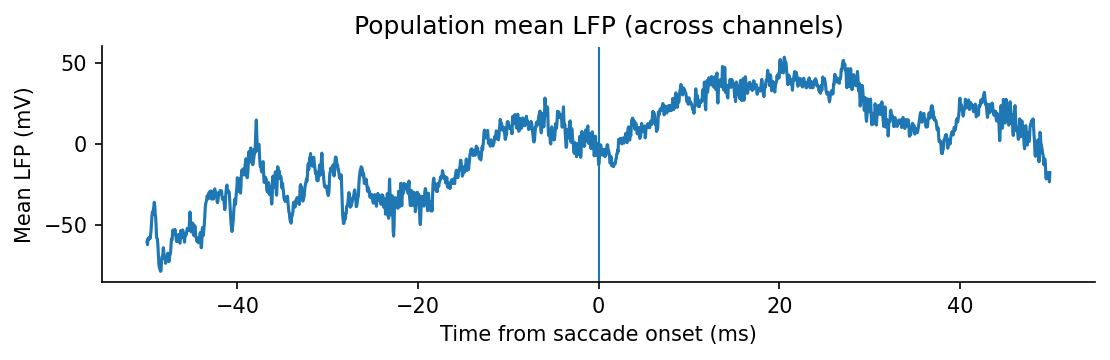

In [38]:
# ---- Inputs you already have ----
# block = <your single BlockSync block>
# all_saccade_collection = <your object / df>
ks_dir = r"Z:\Nimrod\experiments\PV_208\2025_12_14\block_021\oe_files\PV208_d5t4_2025-12-14_13-43-40\Record Node 106\spikeSorting\kilosort4"  # folder containing spike_times.npy etc.

sacc_ms = get_saccade_onsets_ms(all_saccade_collection)

# ---- LFP triggered average ----
t_ms, mean_ch, sem_ch = saccade_triggered_lfp_all_channels(
    block,
    sacc_ms,
    window_ms=100,
    pre_ms=50,
    baseline_ms=(-50, 50),
    channels=None,
    convert_to_mv=True,# or provide explicit list, e.g. channels=list(range(1, 65))
    verbose=True,
)

fig1, ax1 = plot_stacked_channel_traces(
    t_ms, mean_ch, sem_ch,
    title=f"Saccade-triggered LFP ch)"
)

fig2, ax2 = plot_population_mean(
    t_ms, mean_ch, sem_ch,
    title="Population mean LFP (across channels)"
)

# ---- Spikes (Kilosort) -> PSTH ----
spikes_ms, spike_clusters, cluster_label = load_kilosort_spikes_ms(
    ks_dir=ks_dir,
    block=block,
    use_zeroth_sample_number=True,   # aligns to your BlockSync ms timebase when applicable:contentReference[oaicite:6]{index=6}
    keep_labels=("good", "mua")       # adjust or set to None to keep all
)

psth_t, psth_hz = saccade_triggered_psth(
    spikes_ms=spikes_ms,
    saccade_onsets_ms=sacc_ms,
    pre_ms=200,
    post_ms=500,
    bin_ms=10.0
)

fig3, ax3 = plt.subplots(figsize=(7.5, 2.5))
ax3.plot(psth_t, psth_hz, linewidth=1.5)
ax3.axvline(0, linewidth=1.0)
ax3.set_xlabel("Time from saccade onset (ms)")
ax3.set_ylabel("Population rate (Hz)")
ax3.set_title("Saccade-triggered spike-rate histogram (population)")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
fig3.tight_layout()

# ---- Export PDFs (vector-friendly) ----
out_dir = Path(getattr(block, "analysis_path", Path.cwd()))
out_dir.mkdir(parents=True, exist_ok=True)

fig1.savefig(out_dir / "saccade_triggered_LFP_stacked.pdf")
fig2.savefig(out_dir / "saccade_triggered_LFP_population_mean.pdf")
fig3.savefig(out_dir / "saccade_triggered_spike_PSTH.pdf")

print("Saved to:", out_dir)


In [42]:
import numpy as np
import pandas as pd

def _ensure_df(obj):
    if isinstance(obj, pd.DataFrame):
        return obj
    for attr in ("df", "data", "saccades_df"):
        if hasattr(obj, attr) and isinstance(getattr(obj, attr), pd.DataFrame):
            return getattr(obj, attr)
    raise TypeError("Couldn't find a DataFrame inside all_saccade_collection.")

def get_condition_onsets_ms(all_saccade_collection,
                            block_num=None,
                            animal=None,
                            on_col="saccade_on_ms",
                            eye_col="eye",
                            onset_policy="mean"):
    """
    Returns dict with:
      - 'synced' : 1D array of binocular event onsets (one per event)
      - 'mono_L' : 1D array of monocular left onsets
      - 'mono_R' : 1D array of monocular right onsets

    onset_policy for synced events:
      - 'mean' : mean(L_on, R_on)
      - 'min'  : min(L_on, R_on)
      - 'L'    : use left onset
      - 'R'    : use right onset
    """
    df = _ensure_df(all_saccade_collection).copy()

    # Optional single-block filtering (your tables include 'block' and 'animal'):contentReference[oaicite:5]{index=5}
    if block_num is not None and "block" in df.columns:
        df = df[df["block"] == block_num]
    if animal is not None and "animal" in df.columns:
        df = df[df["animal"] == animal]

    # Basic guards
    for c in (on_col, eye_col):
        if c not in df.columns:
            raise ValueError(f"Missing required column '{c}'. Available: {list(df.columns)[:30]} ...")

    df[on_col] = pd.to_numeric(df[on_col], errors="coerce")

    # --- Identify synced/binocular rows if 'Main' exists (from your combine_synced_dataframes/reset_index):contentReference[oaicite:6]{index=6}
    synced_onsets = []
    synced_row_mask = np.zeros(len(df), dtype=bool)

    if "Main" in df.columns:
        group_cols = ["Main"]
        if "block" in df.columns: group_cols = ["block"] + group_cols
        if "animal" in df.columns: group_cols = ["animal"] + group_cols

        for _, g in df.groupby(group_cols, dropna=False):
            eyes = set(g[eye_col].astype(str).tolist())
            if ("L" in eyes) and ("R" in eyes) and len(g) >= 2:
                # treat as binocular event
                l_on = float(g.loc[g[eye_col] == "L", on_col].dropna().iloc[0])
                r_on = float(g.loc[g[eye_col] == "R", on_col].dropna().iloc[0])

                if onset_policy == "mean":
                    t0 = 0.5 * (l_on + r_on)
                elif onset_policy == "min":
                    t0 = min(l_on, r_on)
                elif onset_policy == "L":
                    t0 = l_on
                elif onset_policy == "R":
                    t0 = r_on
                else:
                    raise ValueError("onset_policy must be one of: 'mean','min','L','R'")

                synced_onsets.append(t0)
                synced_row_mask[g.index.values] = True

    synced_onsets = np.asarray(synced_onsets, dtype=float)
    synced_onsets = synced_onsets[np.isfinite(synced_onsets)]

    # --- Monocular events: anything not part of a binocular group
    mono = df.loc[~synced_row_mask].copy()
    mono_L = mono.loc[mono[eye_col] == "L", on_col].dropna().astype(float).to_numpy()
    mono_R = mono.loc[mono[eye_col] == "R", on_col].dropna().astype(float).to_numpy()

    return {
        "synced": np.sort(synced_onsets),
        "mono_L": np.sort(mono_L),
        "mono_R": np.sort(mono_R),
    }

def saccade_triggered_lfp_single_channel(block, saccade_onsets_ms,
                                        channel,
                                        window_ms=500.0,
                                        pre_ms=200.0,
                                        baseline_ms=(-150.0, -50.0),
                                        convert_to_mv=True,
                                        verbose=True):
    oe = block.oe_rec

    sacc = np.asarray(saccade_onsets_ms, dtype=float).reshape(-1)
    sacc = sacc[np.isfinite(sacc)]
    if sacc.size == 0:
        raise ValueError("No saccades provided for this condition.")

    # window start times
    start_ms = sacc - float(pre_ms)

    # Use your get_data API directly. If your implementation internally expects a row vector, keep this:
    start_ms = start_ms.reshape(1, -1)

    data, ts = oe.get_data(
        channels=[int(channel)],
        start_time_ms=start_ms,
        window_ms=float(window_ms),
        convert_to_mv=convert_to_mv,
        return_timestamps=True,
        repress_output=(not verbose),
    )

    data = np.asarray(data, dtype=float)  # [1, n_win, n_samp]
    if data.ndim != 3 or data.shape[0] != 1:
        raise ValueError("Unexpected data shape returned by get_data for single channel.")

    n_win = data.shape[1]
    n_samp = data.shape[2]

    # time axis (ms)
    sample_ms = float(getattr(oe, "sample_ms"))
    pre_ms_used = round(float(pre_ms) / sample_ms) * sample_ms
    t_ms = np.arange(n_samp) * sample_ms - pre_ms_used

    # baseline correction per window
    b0, b1 = baseline_ms
    bmask = (t_ms >= float(b0)) & (t_ms <= float(b1))
    if not np.any(bmask):
        raise ValueError("baseline_ms does not overlap the extracted window. Use a pre-onset baseline (e.g., -150 to -50).")

    x = data[0]  # [n_win, n_samp]
    base = np.mean(x[:, bmask], axis=1, keepdims=True)
    x = x - base

    mean = np.mean(x, axis=0)
    sem = (np.std(x, axis=0, ddof=1) / np.sqrt(n_win)) if n_win >= 2 else np.full_like(mean, np.nan)

    meta = dict(n_events=int(n_win), channel=int(channel))
    return t_ms, mean, sem, meta

import matplotlib.pyplot as plt

def plot_three_conditions(t_ms, traces, title=None):
    """
    traces: dict name -> (mean, sem, n_events)
    """
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42

    fig, ax = plt.subplots(figsize=(7.5, 3.0))
    for name, (m, s, n) in traces.items():
        ax.plot(t_ms, m, linewidth=1.5, label=f"{name} (n={n})")
        if s is not None and np.all(np.isfinite(s)):
            ax.fill_between(t_ms, m - s, m + s, alpha=0.2)

    ax.axvline(0, linewidth=1.0)
    ax.set_xlabel("Time from saccade onset (ms)")
    ax.set_ylabel("LFP (baseline-subtracted)")
    ax.set_title(title or "Saccade-triggered single-electrode LFP")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(frameon=False)
    fig.tight_layout()
    return fig, ax


In [45]:
all_saccade_collection.columns

Index(['Main', 'Sub', 'saccade_start_ind', 'saccade_end_ind',
       'saccade_start_timestamp', 'saccade_end_timestamp', 'saccade_on_ms',
       'saccade_off_ms', 'length', 'magnitude_raw_pixel', 'magnitude_pixel',
       'magnitude_raw_angular', 'overall_angle_deg', 'net_angular_disp',
       'speed_profile_pixel', 'speed_profile_pixel_calib',
       'speed_profile_angular', 'diameter_profile', 'theta_init_pos',
       'theta_end_pos', 'phi_init_pos', 'phi_end_pos', 'delta_theta',
       'delta_phi', 'head_movement', 'eye', 'block', 'animal'],
      dtype='object')

In [50]:
non_synced_saccade_collection.query('eye=="L"')

saccade_start_ind  saccade_end_ind  saccade_start_timestamp  \
5                  1102             1104                 822117.0   
8                  1126             1127                 830109.0   
13                 1244             1245                 869403.0   
16                 2005             2006                1122816.0   
25                 2663             2664                1341930.0   
...                 ...              ...                      ...   
1570             160988           160989               54064155.0   
1571             160989           160990               54064488.0   
1572             161090           161091               54098121.0   
1575             161160           161169               54121431.0   
1580             161291           161293               54165054.0   

      saccade_end_timestamp  saccade_on_ms  saccade_off_ms  length  \
5                  822783.0       41105.85        41139.15       2   
8                  830442.0       41505.45        41522.10       1   
13                 869736.0       43470.15        43486.80       1   
16                1123149.0       56140.80        56157.45       1   
25                1342263.0       67096.50        67113.15       1   
...                     ...            ...             ...     ...   
1570             54064488.0     2703207.75      2703224.40       1   
1571             54064821.0     2703224.40      2703241.05       1   
1572             54098454.0     2704906.05      2704922.70       1   
1575             54124428.0     2706071.55      2706221.40       9   
1580             54165720.0     2708252.70      2708286.00       2   

      magnitude_raw_pixel  magnitude_pixel  magnitude_raw_angular  ...  \
5                3.935176         3.935176               2.344746  ...   
8                8.426082         8.426082               5.241693  ...   
13               2.766489         2.766489               2.532428  ...   
16               2.373504         2.373504               1.546493  ...   
25               2.264000         2.264000               1.499346  ...   
...                   ...              ...                    ...  ...   
1570             2.205953         2.205953               1.720661  ...   
1571             2.295423         2.295423               1.763848  ...   
1572             2.123068         2.123068               1.703598  ...   
1575            22.944350        22.944350              17.159497  ...   
1580             3.296433         3.296433               2.429111  ...   

      theta_init_pos  theta_end_pos phi_init_pos phi_end_pos delta_theta  \
5         -25.406934     -25.742265    -5.157186   -6.564006   -0.335332   
8         -27.488928     -26.613084     1.282828    3.251974    0.875844   
13        -48.227589     -49.572628    23.985073   23.804090   -1.345038   
16        -54.098123     -54.246430    20.040049   20.665347   -0.148308   
25        -33.602061     -34.102860     1.138972    1.445489   -0.500799   
...              ...            ...          ...         ...         ...   
1570      -39.255007     -38.434877   -22.092097  -22.244545    0.820129   
1571      -38.434877     -39.356198   -22.244545  -22.120222   -0.921320   
1572      -38.653122     -39.422973   -21.985819  -21.963949   -0.769851   
1575      -44.591419     -38.935112   -40.244261  -25.782985    5.656308   
1580      -32.435442     -34.007957   -24.280784  -23.880150   -1.572515   

      delta_phi  head_movement  eye  block  animal  
5     -1.406820           True    L    021  PV_208  
8      1.969146          False    L    021  PV_208  
13    -0.180983          False    L    021  PV_208  
16     0.625298          False    L    021  PV_208  
25     0.306517          False    L    021  PV_208  
...         ...            ...  ...    ...     ...  
1570  -0.152448          False    L    021  PV_208  
1571   0.124323          False    L    021  PV_208  
1572   0.021870          False    L    021  PV_208  
1575

sample removed for window #0
Saved: Z:\Nimrod\experiments\PV_208\2025_12_14\block_021\analysis\saccade_triggered_LFP_ch17_by_condition.pdf


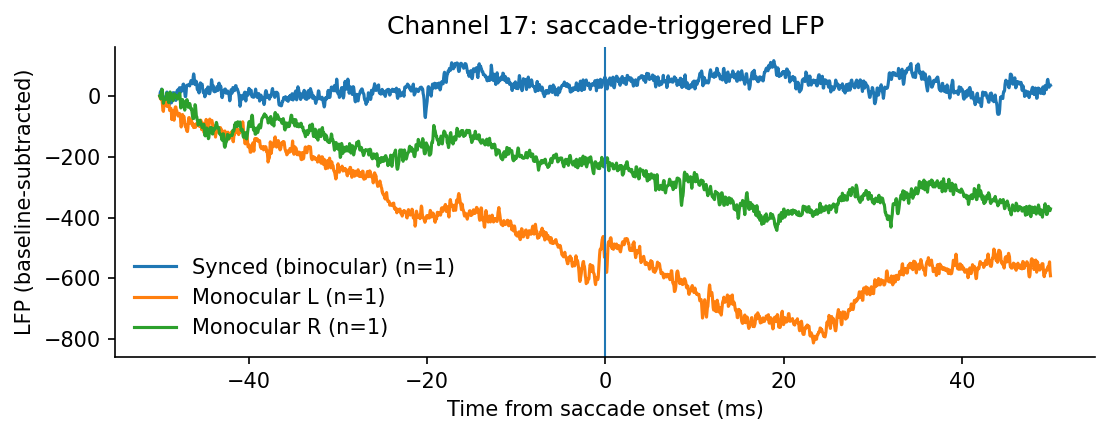

In [53]:
# Choose your electrode:
chan = 17  # <-- change

# Pull condition-specific saccade lists for THIS block
conds = get_condition_onsets_ms(
    all_saccade_collection,
    block_num=block.block_num,
    animal=getattr(block, "animal_call", None),
    onset_policy="mean"   # for synced binocular events
)

# Compute traces
t0, m_sync, s_sync, meta_sync = saccade_triggered_lfp_single_channel(
    block, conds["synced"], channel=chan, window_ms=100, pre_ms=50, baseline_ms=(-150, -50)
)
t1, m_L, s_L, meta_L = saccade_triggered_lfp_single_channel(
    block, non_synced_saccade_collection.query('eye=="L"').saccade_on_ms.values, channel=chan, window_ms=100, pre_ms=50, baseline_ms=(-150, -50)
)
t2, m_R, s_R, meta_R = saccade_triggered_lfp_single_channel(
    block, non_synced_saccade_collection.query('eye=="R"').saccade_on_ms.values, channel=chan, window_ms=100, pre_ms=50, baseline_ms=(-150, -50)
)

# Sanity: time axes should match
assert np.allclose(t0, t1) and np.allclose(t0, t2)

fig, ax = plot_three_conditions(
    t0,
    {
        "Synced (binocular)": (m_sync, s_sync, meta_sync["n_events"]),
        "Monocular L":        (m_L,   s_L,   meta_L["n_events"]),
        "Monocular R":        (m_R,   s_R,   meta_R["n_events"]),
    },
    title=f"Channel {chan}: saccade-triggered LFP"
)

# Export PDF (editable)
from pathlib import Path
out_dir = Path(getattr(block, "analysis_path", Path.cwd()))
out_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / f"saccade_triggered_LFP_ch{chan}_by_condition.pdf")
print("Saved:", out_dir / f"saccade_triggered_LFP_ch{chan}_by_condition.pdf")


In [27]:
import numpy as np

def saccade_triggered_lfp_all_channels(block,
                                      saccade_onsets_ms,
                                      pre_ms=200,
                                      post_ms=500,
                                      baseline_ms=(-150.0, -50.0),
                                      channels=None,
                                      convert_to_mv=True,
                                      verbose=True):
    """
    Uses oe_rec.get_data as-is (assumes it works per its API).
    Returns: t_rel_ms, mean_ch, sem_ch
    """
    oe = block.oe_rec

    # channels: use all if not provided
    if channels is None:
        channels = sanitize_channels(getattr(oe, "channelNumbers"))

    # start times: enforce (1, N) row vector to satisfy implementations that index start_time_ms[0][i]
    saccade_onsets_ms = np.asarray(saccade_onsets_ms, dtype=float).reshape(-1)
    start_ms = as_row_vector_ms(saccade_onsets_ms - float(pre_ms))

    window_ms = float(pre_ms + post_ms)

    data_matrix, ts_matrix = oe.get_data(
        channels=channels,
        start_time_ms=start_ms,
        window_ms=window_ms,
        convert_to_mv=convert_to_mv,
        return_timestamps=True,
        repress_output=(not verbose),
    )

    data_matrix = np.asarray(data_matrix, dtype=float)  # [ch, win, samp]
    n_ch, n_win, n_samp = data_matrix.shape

    # relative time axis
    sample_ms = float(getattr(oe, "sample_ms"))
    pre_ms_used = round(float(pre_ms) / sample_ms) * sample_ms
    t_rel_ms = np.arange(n_samp) * sample_ms - pre_ms_used

    # baseline correction
    b0, b1 = baseline_ms
    bmask = (t_rel_ms >= float(b0)) & (t_rel_ms <= float(b1))
    if not np.any(bmask):
        raise ValueError("baseline_ms window does not overlap the extracted timebase.")

    baseline = np.mean(data_matrix[:, :, bmask], axis=2, keepdims=True)
    x = data_matrix - baseline

    mean_ch = np.mean(x, axis=1)
    sem_ch  = np.std(x, axis=1, ddof=1) / np.sqrt(n_win)

    meta = dict(n_channels=n_ch, n_events=n_win, n_samples=n_samp,
                sample_ms=sample_ms, window_ms=window_ms,
                pre_ms=float(pre_ms), post_ms=float(post_ms),
                baseline_ms=tuple(baseline_ms))

    if verbose:
        print("LFP: {} channels, {} saccades, {} samples (dt={} ms)".format(
            n_ch, n_win, n_samp, sample_ms
        ))

    return t_rel_ms, mean_ch, sem_ch, meta


In [29]:
import numpy as np
import types
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---- PDF export settings for editability ----
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42
mpl.rcParams["svg.fonttype"] = "none"


# ---------------------------------------------------------------------
# 1) Monkeypatch: fix OERecording.get_data to accept 1D start_time_ms
#    (minimal change vs your code: uses start_time_ms[i] instead of start_time_ms[0][i])
# ---------------------------------------------------------------------
def _get_data_fixed(self, channels, start_time_ms, window_ms,
                    convert_to_mv=True, return_timestamps=True, repress_output=False):
    """
    Fixed version of OERecording.get_data compatible with your pipeline calls:
      - start_time_ms can be 1D (n_windows,) or 2D.
      - returns data_matrix with shape [n_channels, n_windows, nSamples]
    """
    # normalize start_time_ms to 1D float array
    start_time_ms = np.asarray(start_time_ms).astype(float).reshape(-1)
    n_windows = int(start_time_ms.size)

    window_samples = int(np.round(window_ms / self.sample_ms))
    start_time_ms = np.round(start_time_ms / self.sample_ms) * self.sample_ms
    window_ms = window_samples * self.sample_ms

    # channels: default to all recorded channels
    if channels is None or len(channels) == 0:
        channels = self.channelNumbers
    channels = list(channels)

    if not all([c in self.channelNumbers for c in channels]):
        raise ValueError("one or more of the entered channels does not exist in the recording!")
    n_ch = len(channels)

    # waveform matrix in original orientation then transposed at end
    data_matrix = np.zeros(shape=(int(window_samples), n_windows, n_ch),
                           dtype=self.blkCont['Types'][3],
                           order='F')

    p_rec_idx = []
    read_start_indices = []
    records_per_trial_list = []

    for i in range(n_windows):
        # NOTE: here is the critical fix: start_time_ms[i] not start_time_ms[0][i]
        p_single_trial_time_stamps = np.where(
            (self.allTimeStamps[0] >= (start_time_ms[i] - self.recordLength)) &
            (self.allTimeStamps[0] <  (start_time_ms[i] + window_ms))
        )[1]

        try:
            read_start_indices.append(p_single_trial_time_stamps[0])
        except IndexError:
            read_start_indices.append(p_single_trial_time_stamps)

        single_trial_time_stamps = np.round(
            self.allTimeStamps[0][p_single_trial_time_stamps] / self.sample_ms
        ) * self.sample_ms

        records_per_trial = len(single_trial_time_stamps[0])
        records_per_trial_list.append(records_per_trial)

        time_idx = np.tile((np.arange(self.dataSamplesPerRecord) * self.sample_ms).reshape(-1, 1),
                           (1, records_per_trial)) + single_trial_time_stamps.reshape(1, -1)

        p_rec_idx.append((time_idx >= start_time_ms[i]) & (time_idx < (start_time_ms[i] + window_ms)))

        if np.sum(p_rec_idx[i]) == window_samples + 1:
            if not repress_output:
                print("sample removed for window #{}".format(i))
            p_rec_idx[i][0, np.where(p_rec_idx[i][0, :] == 1)[0][0]] = False

    p_rec_idx = np.hstack(p_rec_idx)

    for i in range(n_ch):
        data = np.zeros(p_rec_idx.shape, dtype=np.dtype('>i2'))
        curr_rec = 0

        # IMPORTANT: your implementation is 1-indexed here (channels[i]-1):contentReference[oaicite:5]{index=5}
        c_file = self.oe_file_path / self.channel_files[channels[i] - 1]

        with open(c_file, 'rb') as fid:
            for j in range(n_windows):
                fid.seek(int(self.headerSizeByte + (read_start_indices[j] * self.bytesPerRecCont) +
                             np.sum(self.blkBytesCont[0:3])), 0)

                skip_size = int(self.bytesPerRecCont[0][0] - self.blkBytesCont[3][0]) // 2
                read_size = self.dataSamplesPerRecord
                total_bytes = (read_size + skip_size) * records_per_trial_list[j]

                data_plus_breaks = np.fromfile(fid, dtype=np.dtype('>i2'), count=total_bytes, sep='')
                try:
                    data_plus_breaks = data_plus_breaks.reshape(int(records_per_trial_list[j]),
                                                                read_size + skip_size)
                except ValueError:
                    if return_timestamps:
                        return None, None
                    return None

                clean_data = data_plus_breaks[:, :read_size]
                data[:, curr_rec: curr_rec + records_per_trial_list[j]] = clean_data.T
                curr_rec += records_per_trial_list[j]

        data_vec = data.T[p_rec_idx.T]

        if len(data_vec) < int(window_samples) * n_windows:
            if not repress_output:
                print("segment exceeds recording length, padding with zeros")
            num_zeros = (int(window_samples) * n_windows) - len(data_vec)
            data_vec = np.pad(data_vec, (0, num_zeros), mode='constant')

        data_matrix[:, :, i] = data_vec.reshape(int(window_samples), n_windows, order='F')

    # match your documented output: [n_channels, n_windows, nSamples]
    data_matrix = np.transpose(data_matrix, [2, 1, 0])

    if convert_to_mv:
        # note: name says MicrovoltsPerAD; you multiply by this factor (units likely µV):contentReference[oaicite:6]{index=6}
        data_matrix = data_matrix * self.MicrovoltsPerAD[0]

    if return_timestamps:
        # timestamps as absolute ms per window/sample
        ts = np.tile(np.arange(window_samples) * self.sample_ms, (n_windows, 1))
        ts = ts + start_time_ms.reshape(-1, 1)
        return data_matrix, ts
    return data_matrix


# Apply the monkeypatch once per session
block.oe_rec.get_data = types.MethodType(_get_data_fixed, block.oe_rec)


# ---------------------------------------------------------------------
# 2) Now: saccade-triggered mean LFP across ALL channels
# ---------------------------------------------------------------------
def saccade_triggered_lfp_all_channels(block, saccade_times_ms,
                                      window_ms=500.0, pre_ms=200.0,
                                      baseline_ms=(-150.0, -50.0),
                                      channels=None, convert_to_mv=True):
    """
    Uses your OERecording.get_data output shape: [n_channels, n_windows, n_samples].:contentReference[oaicite:7]{index=7}
    """
    oe = block.oe_rec

    if channels is None:
        channels = list(oe.channelNumbers)  # correct for your class:contentReference[oaicite:8]{index=8}

    # Build window starts (ms) and filter those that would go negative
    start_ms = np.asarray(saccade_times_ms, dtype=float) - float(pre_ms)
    start_ms = start_ms[np.isfinite(start_ms) & (start_ms >= 0)]
    if start_ms.size == 0:
        raise ValueError("No valid saccades after filtering (pre window < 0).")

    # Pull data for all channels at once (fast)
    ep_data, ep_ts = oe.get_data(channels, start_ms, window_ms, convert_to_mv=convert_to_mv, return_timestamps=True)

    # time axis relative to saccade onset
    n_samp = ep_data.shape[2]
    t_rel = (np.arange(n_samp) * oe.sample_ms) - float(pre_ms)

    # baseline mask
    b0, b1 = baseline_ms
    bmask = (t_rel >= b0) & (t_rel <= b1)
    if not np.any(bmask):
        raise ValueError("baseline_ms window does not overlap the extracted window.")

    # baseline-correct each trial per channel
    # ep_data: [ch, win, samp]
    baseline = np.mean(ep_data[:, :, bmask], axis=2, keepdims=True)
    x = ep_data - baseline

    mean_lfp = np.mean(x, axis=1)  # [ch, samp]
    sem_lfp  = np.std(x, axis=1, ddof=1) / np.sqrt(x.shape[1])

    return t_rel, mean_lfp, sem_lfp


def plot_channel_stacked(t_ms, mean_lfp, title="Saccade-triggered LFP (channel-stacked)",
                         xlabel="Time from saccade onset (ms)",
                         ylabel="Channels (stacked)", offset_scale=None):
    n_ch = mean_lfp.shape[0]
    if offset_scale is None:
        offset_scale = 3.0 * float(np.nanmedian(np.std(mean_lfp, axis=1)))

    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    for i in range(n_ch):
        ax.plot(t_ms, mean_lfp[i] + i * offset_scale, lw=0.6)

    ax.axvline(0, lw=1.0)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticks([])
    ax.margins(x=0)
    return fig, ax


# ---- RUN (example) ----
sacc_ms = get_saccade_times_ms(all_saccade_collection, eye=None)  # uses your 'saccade_on_ms' column
t_ms, mean_lfp, sem_lfp = saccade_triggered_lfp_all_channels(
    block, sacc_ms, window_ms=500, pre_ms=200, baseline_ms=(-150, -50),
    channels=None, convert_to_mv=True
)
fig, ax = plot_channel_stacked(t_ms, mean_lfp)
fig.savefig("saccade_triggered_LFP_all_channels.pdf", bbox_inches="tight")
plt.show()


ValueError: operands could not be broadcast together with shapes (53927,) (1,3079) 

In [27]:
sacc_ms

array([  37842.45,   37859.1 ,   38008.95, ..., 2718176.1 , 2719391.55,
       2719424.85])

In [83]:
# open the phy folder:
from pathlib import Path
import numpy as np
import pandas as pd

def load_phy_folder(phy_dir):
    """
    Minimal loader for KS/phy folders.
    Expects at least: spike_times.npy, spike_clusters.npy
    Optionally reads: cluster_group.tsv or cluster_info.tsv (if present)
    """
    phy_dir = Path(phy_dir)

    spike_times = np.load(phy_dir / "spike_times.npy")        # samples (int)
    spike_clusters = np.load(phy_dir / "spike_clusters.npy")  # cluster id per spike (int)

    # Optional metadata (varies by pipeline/phy usage)
    cluster_group = None
    if (phy_dir / "cluster_group.tsv").exists():
        cluster_group = pd.read_csv(phy_dir / "cluster_group.tsv", sep="\t")
    cluster_info = None
    if (phy_dir / "cluster_info.tsv").exists():
        cluster_info = pd.read_csv(phy_dir / "cluster_info.tsv", sep="\t")

    return spike_times.squeeze(), spike_clusters.squeeze(), cluster_group, cluster_info


import numpy as np

def peth_rate_hz(spike_times_samp, event_times_samp, fs, window_ms=300, bin_ms=5, smooth_sigma_ms=20):
    """
    Build a peri-event time histogram (rate in Hz) averaged across events.
    - spike_times_samp: 1D array of spike times in samples
    - event_times_samp: 1D array of event times in samples
    - fs: sampling rate (Hz) of spike_times timebase (usually OE raw fs)
    """
    spike_times_samp = np.asarray(spike_times_samp, dtype=np.int64)
    event_times_samp = np.asarray(event_times_samp, dtype=np.int64)

    w_samp = int(round(window_ms * fs / 1000))
    bin_samp = max(1, int(round(bin_ms * fs / 1000)))

    # bins centered around 0
    edges = np.arange(-w_samp, w_samp + bin_samp, bin_samp, dtype=np.int64)
    centers_samp = (edges[:-1] + edges[1:]) / 2
    centers_ms = centers_samp / fs * 1000.0

    # accumulate counts across events
    counts = np.zeros(len(edges) - 1, dtype=np.float64)

    # Efficient per-event windowing via masking; fast enough for typical n-events
    for t0 in event_times_samp:
        lo, hi = t0 - w_samp, t0 + w_samp
        mask = (spike_times_samp >= lo) & (spike_times_samp < hi)
        rel = spike_times_samp[mask] - t0
        c, _ = np.histogram(rel, bins=edges)
        counts += c

    # mean spikes/bin/event -> Hz
    n_events = max(1, len(event_times_samp))
    rate_hz = (counts / n_events) * (fs / bin_samp)

    # Optional Gaussian smoothing in bin units
    if smooth_sigma_ms and smooth_sigma_ms > 0:
        sigma_bins = (smooth_sigma_ms / bin_ms)
        # simple discrete gaussian kernel
        half = int(np.ceil(4 * sigma_bins))
        x = np.arange(-half, half + 1)
        k = np.exp(-(x**2) / (2 * sigma_bins**2))
        k /= k.sum()
        rate_hz = np.convolve(rate_hz, k, mode="same")

    return centers_ms, rate_hz

def ms_to_samples(ms, fs):
    return np.asarray(ms) / 1000.0 * fs


spike_times, spike_clusters, cluster_group, cluster_info = load_phy_folder(r"Z:\Nimrod\experiments\PV_208\2025_12_14\block_021\oe_files\PV208_d5t4_2025-12-14_13-43-40\Record Node 106\spikeSorting\kilosort4" )

In [87]:
from pathlib import Path
import numpy as np
import pandas as pd

def load_phy_folder(phy_dir):
    phy_dir = Path(phy_dir)
    spike_times = np.load(phy_dir / "spike_times.npy").squeeze().astype(np.int64)          # samples
    spike_clusters = np.load(phy_dir / "spike_clusters.npy").squeeze().astype(np.int64)  # cluster id per spike
    spike_times_samp, spike_clusters, cluster_group, cluster_info = load_phy_folder(phy_dir)
    spike_fs = 20000
    spike_times_ms = spike_times_samp.astype(np.float64) * (1000.0 / spike_fs)  # = *0.05

    cluster_group = None
    if (phy_dir / "cluster_group.tsv").exists():
        cluster_group = pd.read_csv(phy_dir / "cluster_group.tsv", sep="\t")

    cluster_info = None
    if (phy_dir / "cluster_info.tsv").exists():
        cluster_info = pd.read_csv(phy_dir / "cluster_info.tsv", sep="\t")

    return spike_times_ms, spike_clusters, cluster_group, cluster_info

def pick_good_clusters(cluster_group):
    """
    Returns array of 'good' cluster_ids if available, else None (meaning "use all").
    """
    if cluster_group is None:
        return None
    cols = set(cluster_group.columns)
    if {"cluster_id", "group"}.issubset(cols):
        good = cluster_group.loc[cluster_group["group"].astype(str).str.lower().eq("good"), "cluster_id"].values
        return good.astype(np.int64)
    return None

def clusters_on_channel(cluster_info, channel_id, good_clusters=None):
    """
    Try to map channel -> cluster ids using common phy/KS columns.
    Falls back to good_clusters or all clusters if channel mapping isn't possible.
    """
    if cluster_info is None:
        return good_clusters  # may be None

    # Common column names used across phy exports:
    possible = ["ch", "channel", "peak_channel", "max_channel", "best_channel"]
    ch_col = next((c for c in possible if c in cluster_info.columns), None)
    if ch_col is None or "cluster_id" not in cluster_info.columns:
        return good_clusters

    cl = cluster_info.loc[cluster_info[ch_col].values == channel_id, "cluster_id"].values.astype(np.int64)
    if good_clusters is not None:
        cl = np.intersect1d(cl, good_clusters)
    return cl

def spikes_for_clusters(spike_times, spike_clusters, cluster_ids):
    if cluster_ids is None:
        return spike_times
    m = np.isin(spike_clusters, cluster_ids)
    return spike_times[m]

def peth_rate_hz(spike_times_samp, event_times_samp, spike_fs, window_ms, bin_ms=5, smooth_sigma_ms=20):
    """
    Average peri-event spike rate (Hz).
    event_times_samp must be in SAME sample clock as spike_times_samp.
    """
    spike_times_samp = np.asarray(spike_times_samp, dtype=np.int64)
    event_times_samp = np.asarray(event_times_samp, dtype=np.int64)

    w_samp = int(round(window_ms * spike_fs / 1000.0))
    bin_samp = max(1, int(round(bin_ms * spike_fs / 1000.0)))

    edges = np.arange(-w_samp, w_samp + bin_samp, bin_samp, dtype=np.int64)
    centers_samp = (edges[:-1] + edges[1:]) / 2.0
    centers_ms = centers_samp / spike_fs * 1000.0

    counts = np.zeros(len(edges) - 1, dtype=np.float64)
    n_events = max(1, len(event_times_samp))

    for t0 in event_times_samp:
        lo, hi = t0 - w_samp, t0 + w_samp
        mask = (spike_times_samp >= lo) & (spike_times_samp < hi)
        rel = spike_times_samp[mask] - t0
        c, _ = np.histogram(rel, bins=edges)
        counts += c

    rate_hz = (counts / n_events) * (spike_fs / bin_samp)

    if smooth_sigma_ms and smooth_sigma_ms > 0:
        sigma_bins = smooth_sigma_ms / bin_ms
        half = int(np.ceil(4 * sigma_bins))
        x = np.arange(-half, half + 1)
        k = np.exp(-(x**2) / (2 * sigma_bins**2))
        k /= k.sum()
        rate_hz = np.convolve(rate_hz, k, mode="same")

    return centers_ms, rate_hz

def resample_to_xvals(t_ms, y, x_vals):
    # safe linear interpolation onto your LFP x-axis points
    return np.interp(x_vals, t_ms, y, left=np.nan, right=np.nan)
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_electrode_saccade_averages(
    synced_data_arr,
    l_non_synced_data,
    r_non_synced_data,
    electrode_labels,
    sampling_rate,
    export_path=None,
    *,
    # --- new optional spike overlay inputs ---
    phy_dir=None,
    spike_fs=None,
    synced_event_samp=None,
    l_event_samp=None,
    r_event_samp=None,
    spike_bin_ms=5,
    spike_smooth_sigma_ms=20,
    spike_use_good=True,
    spike_overlay_alpha=0.85
):
    """
    If phy_dir + spike_fs + (event_samp arrays) are provided, overlays peri-saccade spike-rate (Hz)
    for the same 3 conditions on a secondary y-axis.
    """
    num_electrodes = synced_data_arr.shape[0]
    fig, axs = plt.subplots(num_electrodes, 1, figsize=(10, num_electrodes * 4), dpi=150, sharex=True)
    if num_electrodes == 1:
        axs = [axs]

    num_samples = synced_data_arr.shape[2]
    x_vals = np.arange(-num_samples // 2, num_samples // 2) * 1000.0 / sampling_rate
    window_ms = (num_samples / 2) * 1000.0 / sampling_rate

    # Load spikes once if requested
    do_spikes = (phy_dir is not None) and (spike_fs is not None) and \
                (synced_event_samp is not None) and (l_event_samp is not None) and (r_event_samp is not None)

    if do_spikes:
        spike_times, spike_clusters, cluster_group, cluster_info = load_phy_folder(phy_dir)
        good_clusters = pick_good_clusters(cluster_group) if spike_use_good else None

    for i in range(num_electrodes):
        synced_mean = np.nanmean(synced_data_arr[i], axis=0)
        l_non_synced_mean = np.nanmean(l_non_synced_data[i], axis=0)
        r_non_synced_mean = np.nanmean(r_non_synced_data[i], axis=0)

        axs[i].plot(x_vals, synced_mean,
                    label=f'Synced (n = {np.shape(synced_data_arr)[1]})', color='blue', alpha=0.9)
        axs[i].plot(x_vals, l_non_synced_mean,
                    label=f'Left Monocular (n = {np.shape(l_non_synced_data)[1]})', color='green', alpha=0.9)
        axs[i].plot(x_vals, r_non_synced_mean,
                    label=f'Right Monocular (n = {np.shape(r_non_synced_data)[1]})', color='red', alpha=0.9)

        axs[i].axvline(x=0, color='red', linestyle='--', linewidth=1)
        axs[i].set_ylabel('mean signal (microVolt)')
        axs[i].set_title(f'Electrode {electrode_labels[i]}')

        if i == 0:
            axs[i].legend(loc='best', fontsize='large')

        # --- Spike-rate overlay ---
        if do_spikes:
            ch = electrode_labels[i]
            cl_on_ch = clusters_on_channel(cluster_info, ch, good_clusters=good_clusters)
            st = spikes_for_clusters(spike_times, spike_clusters, cl_on_ch)

            t_ms, rate_sync = peth_rate_hz(st, synced_event_samp, spike_fs, window_ms,
                                           bin_ms=spike_bin_ms, smooth_sigma_ms=spike_smooth_sigma_ms)
            _,   rate_L    = peth_rate_hz(st, l_event_samp,     spike_fs, window_ms,
                                           bin_ms=spike_bin_ms, smooth_sigma_ms=spike_smooth_sigma_ms)


In [ ]:
phy_dir = r"Z:\Nimrod\experiments\PV_208\2025_12_14\block_021\oe_files\PV208_d5t4_2025-12-14_13-43-40\Record Node 106\spikeSorting\kilosort4"
#spike_fs = 20000  # your raw ephys sampling rate used for sorting

# These should be 1D arrays of event times in *spike_fs samples*
synced_event_samp = np.array([...], dtype=np.int64)
l_event_samp      = np.array([...], dtype=np.int64)
r_event_samp      = np.array([...], dtype=np.int64)

plot_multi_electrode_saccade_averages(
    synced_data_arr, l_non_synced_data, r_non_synced_data,
    electrode_labels=electrode_labels,
    sampling_rate=lfp_fs,                  # your LFP snippet fs (could be downsampled)
    export_path=export_path,
    phy_dir=phy_dir,
    spike_fs=spike_fs,
    synced_event_samp=synced_event_samp,
    l_event_samp=l_event_samp,
    r_event_samp=r_event_samp
)


In [71]:
# helper function to get single electrode saccade data

def get_saccade_ep_data(block_collection,electrode,ms_window, synced_saccade_collection):
    # handle electrode lists
    if type(electrode) is not list:
        electrode = [electrode]

    data_list = []
    data_list_r = []
    data_list_l = []

    for block in block_collection:
        # collect synced data
        saccade_init = synced_saccade_collection.query('block == @block.block_num').saccade_start_ind.values
        saccade_ms = block.left_eye_data.iloc[saccade_init].ms_axis.values
        saccade_ms_pre = saccade_ms - ms_window // 2
        data, timestamps = block.oe_rec.get_data(electrode,saccade_ms_pre,ms_window)
        sdata = np.squeeze(data)
        data_list.append(data)

        # collect non synced data
        l_saccade_init = non_synced_saccade_collection.query('block == @block.block_num and eye == "L"').saccade_start_ind.values
        l_saccade_ms = block.left_eye_data.iloc[l_saccade_init].ms_axis.values
        l_saccade_ms_pre = l_saccade_ms - ms_window // 2
        l_data, l_timestamps = block.oe_rec.get_data(electrode,l_saccade_ms_pre,ms_window)
        l_sdata = np.squeeze(l_data)
        data_list_l.append(l_data)

        r_saccade_init = non_synced_saccade_collection.query('block == @block.block_num and eye == "R"').saccade_start_ind.values
        r_saccade_ms = block.right_eye_data.iloc[r_saccade_init].ms_axis.values
        r_saccade_ms_pre = r_saccade_ms - ms_window // 2
        r_data, r_timestamps = block.oe_rec.get_data(electrode,r_saccade_ms_pre,ms_window)
        r_sdata = np.squeeze(r_data)
        data_list_r.append(r_data)

    print(np.shape(data_list_l))
    l_squeezed_data_list = [np.squeeze(i) for i in data_list_l]
    print()
    l_data_arr = np.vstack(l_squeezed_data_list)
    l_non_synced_data = l_data_arr

    r_squeezed_data_list = [np.squeeze(i) for i in data_list_r]
    r_data_arr = np.vstack(r_squeezed_data_list)
    r_non_synced_data = r_data_arr

    squeezed_data_list = [np.squeeze(i) for i in data_list]
    data_arr = np.vstack(squeezed_data_list)
    synced_data_arr = data_arr


    return synced_data_arr, l_non_synced_data, r_non_synced_data

import numpy as np

def get_saccade_ep_data_new(block_collection, electrodes, ms_window, synced_saccade_collection):
    # Ensure electrodes is a list
    if type(electrodes) is not list:
        electrodes = [electrodes]

    # Create lists to hold data for all electrodes
    synced_data_dict = {elec: [] for elec in electrodes}
    l_data_dict = {elec: [] for elec in electrodes}
    r_data_dict = {elec: [] for elec in electrodes}

    for block in block_collection:
        # Process each electrode
        for electrode in electrodes:
            # Collect synced data
            saccade_init = synced_saccade_collection.query('block == @block.block_num').saccade_start_ind.values
            saccade_ms = block.left_eye_data.iloc[saccade_init].ms_axis.values
            saccade_ms_pre = saccade_ms - ms_window // 2
            data, timestamps = block.oe_rec.get_data([electrode], saccade_ms_pre, ms_window)
            synced_data_dict[electrode].append(data)  # Append the data directly

            # Collect non-synced data for left eye
            l_saccade_init = non_synced_saccade_collection.query('block == @block.block_num and eye == "L"').saccade_start_ind.values
            l_saccade_ms = block.left_eye_data.iloc[l_saccade_init].ms_axis.values
            l_saccade_ms_pre = l_saccade_ms - ms_window // 2
            l_data, l_timestamps = block.oe_rec.get_data([electrode], l_saccade_ms_pre, ms_window,convert_to_mv=True)
            l_data_dict[electrode].append(l_data)  # Append the data directly

            # Collect non-synced data for right eye
            r_saccade_init = non_synced_saccade_collection.query('block == @block.block_num and eye == "R"').saccade_start_ind.values
            r_saccade_ms = block.right_eye_data.iloc[r_saccade_init].ms_axis.values
            r_saccade_ms_pre = r_saccade_ms - ms_window // 2
            r_data, r_timestamps = block.oe_rec.get_data([electrode], r_saccade_ms_pre, ms_window)
            r_data_dict[electrode].append(r_data)  # Append the data directly

    # Concatenate data for each electrode
    synced_data_arr = np.concatenate([np.concatenate(synced_data_dict[elec], axis=1) for elec in electrodes], axis=0)
    l_non_synced_data = np.concatenate([np.concatenate(l_data_dict[elec], axis=1) for elec in electrodes], axis=0)
    r_non_synced_data = np.concatenate([np.concatenate(r_data_dict[elec], axis=1) for elec in electrodes], axis=0)

    return synced_data_arr, l_non_synced_data, r_non_synced_data


electrode = [28]
ms_window = 500

subset_of_saccades = synced_saccade_collection
print(len(subset_of_saccades))
synced_data_arr, l_non_synced_data, r_non_synced_data = get_saccade_ep_data_new(block_collection,electrode,ms_window, subset_of_saccades)




1670
sample removed for window #4
sample removed for window #69
sample removed for window #160
sample removed for window #162
sample removed for window #179
sample removed for window #197
sample removed for window #330
sample removed for window #426
sample removed for window #438
sample removed for window #471
sample removed for window #525
sample removed for window #533
sample removed for window #537
sample removed for window #568
sample removed for window #572
sample removed for window #580
sample removed for window #588
sample removed for window #593
sample removed for window #715
sample removed for window #733
sample removed for window #835
sample removed for window #943
sample removed for window #961
sample removed for window #962
sample removed for window #995
sample removed for window #1129
sample removed for window #1273
sample removed for window #1372
sample removed for window #1478
sample removed for window #1479
sample removed for window #1488
sample removed for window #1528

In [72]:
import numpy as np

import numpy as np

def remove_high_variance_events(data_array, threshold_factor=1.5):
    """
    Removes events (trials) that have high variance across samples for each electrode.

    Parameters:
    - data_array: np.ndarray of shape (electrodes, events, traces)
    - threshold_factor: float, factor of the median variance above which events are removed

    Returns:
    - filtered_data_array: np.ndarray of the same shape as input, with invalid events replaced by NaN
    - num_invalid_events: total number of events removed across all electrodes
    """
    electrodes, events, traces = data_array.shape
    filtered_data_array = np.copy(data_array)
    num_invalid_events = 0

    # Iterate over each electrode
    for electrode in range(electrodes):
        # Calculate variance of each event (across the samples for this electrode)
        event_variances = np.nanvar(data_array[electrode], axis=1)

        # Calculate median variance for events
        median_variance = np.median(event_variances)

        # Identify events with variance higher than the threshold factor * median variance
        invalid_mask = event_variances > threshold_factor * median_variance

        # Replace invalid events with NaNs
        filtered_data_array[electrode, invalid_mask, :] = np.nan

        # Count the number of invalid events
        num_invalid_events += np.sum(invalid_mask)

    return filtered_data_array, num_invalid_events

filtered_synced_arr  = remove_high_variance_events(synced_data_arr)
filtered_l_arr = remove_high_variance_events(l_non_synced_data)
filtered_r_arr = remove_high_variance_events(r_non_synced_data)

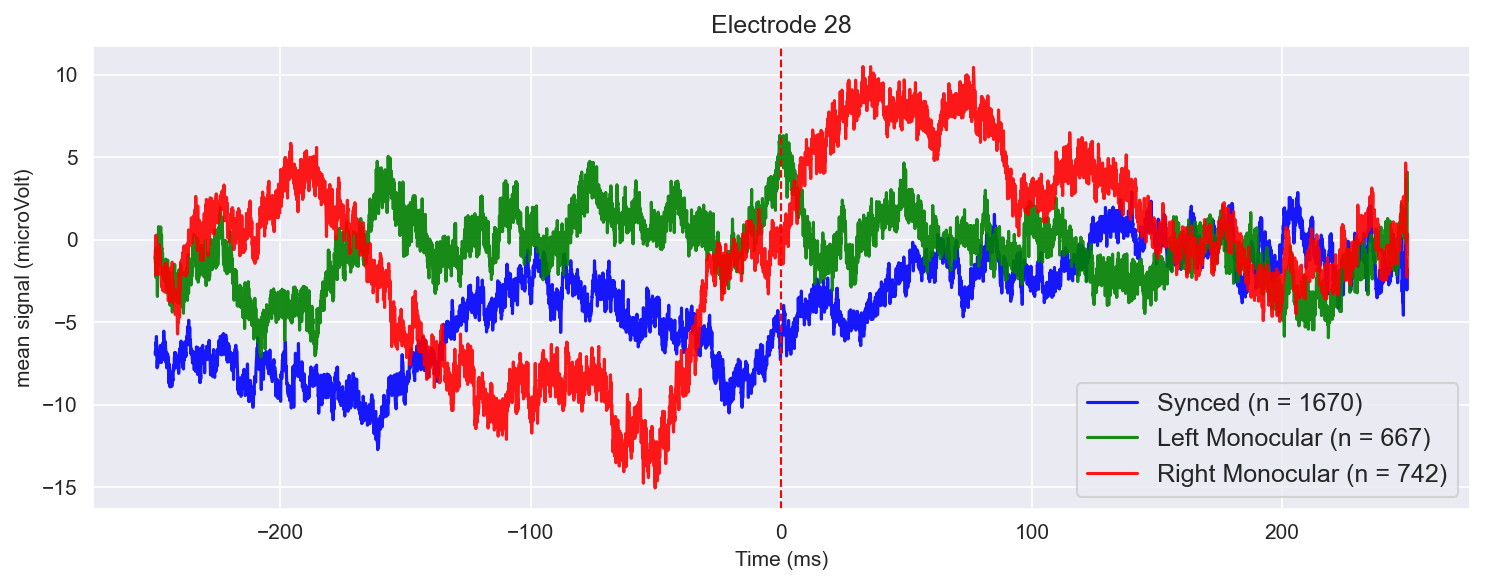

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_electrode_saccade_averages(synced_data_arr, l_non_synced_data, r_non_synced_data, electrode_labels, sampling_rate, export_path=None):
    # Number of electrodes
    num_electrodes = synced_data_arr.shape[0]

    # Create subplots (rows)
    fig, axs = plt.subplots(num_electrodes, 1, figsize=(10, num_electrodes * 4), dpi=150, sharex=True)

    if num_electrodes == 1:
        axs = [axs]  # Ensure axs is iterable when there's only one subplot

    # Define x-axis in milliseconds
    num_samples = synced_data_arr.shape[2]  # Assumes all data arrays have the same number of samples
    x_vals = np.arange(-num_samples // 2, num_samples // 2) * 1000 / sampling_rate

    for i in range(num_electrodes):
        # Calculate means
        synced_mean = np.nanmean(synced_data_arr[i], axis=0)
        l_non_synced_mean = np.nanmean(l_non_synced_data[i], axis=0)
        r_non_synced_mean = np.nanmean(r_non_synced_data[i], axis=0)

        # Plotting
        axs[i].plot(x_vals, synced_mean, label=f'Synced (n = {np.shape(synced_data_arr)[1]})', color='blue', alpha=0.9)
        axs[i].plot(x_vals, l_non_synced_mean, label=f'Left Monocular (n = {np.shape(l_non_synced_data)[1]})', color='green', alpha=0.9)
        axs[i].plot(x_vals, r_non_synced_mean, label=f'Right Monocular (n = {np.shape(r_non_synced_data)[1]})', color='red', alpha=0.9)

        # Plot formatting
        axs[i].axvline(x=0, color='red', linestyle='--', linewidth=1)
        axs[i].set_ylabel('mean signal (microVolt)')
        axs[i].set_title(f'Electrode {electrode_labels[i]}')

        # Add legend only for the first subplot
        if i == 0:
            axs[i].legend(loc='best', fontsize='large')

    axs[-1].set_xlabel('Time (ms)')

    # Improve layout
    plt.tight_layout()
    if export_path:
        plt.savefig(export_path)
    plt.show()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = block.analysis_path / f"{t}_Saccade_avg_LFP_filtered.pdf"
plot_multi_electrode_saccade_averages(filtered_synced_arr[0], filtered_l_arr[0], filtered_r_arr[0], electrode, block.sample_rate, export_path)

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_multi_electrode_saccade_averages_with_global_peth(
    synced_data_arr,
    l_non_synced_data,
    r_non_synced_data,
    electrode_labels,
    lfp_sampling_rate_hz,
    synced_event_ms,
    l_event_ms,
    r_event_ms,
    phy_dir,
    *,
    spike_fs_hz=20000,
    variance_threshold_factor=1.5,
    use_good_clusters=True,
    peth_bin_ms=5.0,
    peth_smooth_sigma_ms=20.0,
    export_path=None,
    figsize_width=10,
    electrode_row_height=3.2,
    peth_row_height=2.6,
):
    """
    Plot per-electrode peri-saccade LFP means (Synced / Left-mono / Right-mono)
    and a GLOBAL (all spikes, regardless of electrode) peri-event spike-rate trace (PETH)
    in an additional panel at the bottom.

    Required assumptions:
      - synced_data_arr, l_non_synced_data, r_non_synced_data have shape (n_electrodes, n_events, n_samples)
      - synced_event_ms, l_event_ms, r_event_ms are 1D arrays of absolute event times in ms,
        in the SAME time origin as the phy/Kilosort spike_times (after conversion to ms).
      - phy_dir contains at least spike_times.npy and spike_clusters.npy

    Notes:
      - High-variance LFP events are replaced with NaN per electrode; we then build a single
        per-condition event-valid mask as: event is valid if NOT all-NaN across electrodes & samples.
      - The global PETH uses the same valid event subset (so counts match your filtered LFP averages).
    """

    # -------------------------
    # Helpers (local)
    # -------------------------
    def remove_high_variance_events(data_array, threshold_factor=1.5):
        electrodes, events, traces = data_array.shape
        filtered = np.array(data_array, copy=True)
        num_invalid = 0
        for e in range(electrodes):
            event_vars = np.nanvar(data_array[e], axis=1)  # (events,)
            med = np.median(event_vars)
            invalid = event_vars > (threshold_factor * med)
            filtered[e, invalid, :] = np.nan
            num_invalid += int(np.sum(invalid))
        return filtered, num_invalid

    def load_phy_folder_ms(phy_dir, spike_fs_hz, use_good_clusters=True):
        phy_dir = Path(phy_dir)
        spike_times_samp = np.load(phy_dir / "spike_times.npy").squeeze().astype(np.int64)
        spike_clusters = np.load(phy_dir / "spike_clusters.npy").squeeze().astype(np.int64)

        spike_times_ms = spike_times_samp.astype(np.float64) * (1000.0 / float(spike_fs_hz))

        cluster_group = None
        cg_path = phy_dir / "cluster_group.tsv"
        if cg_path.exists():
            cluster_group = pd.read_csv(cg_path, sep="\t")

        cluster_info = None
        ci_path = phy_dir / "cluster_info.tsv"
        if ci_path.exists():
            cluster_info = pd.read_csv(ci_path, sep="\t")

        if use_good_clusters and (cluster_group is not None) and {"cluster_id", "group"}.issubset(cluster_group.columns):
            good = cluster_group.loc[
                cluster_group["group"].astype(str).str.lower().eq("good"),
                "cluster_id"
            ].values.astype(np.int64)
            if good.size > 0:
                m = np.isin(spike_clusters, good)
                spike_times_ms = spike_times_ms[m]
                spike_clusters = spike_clusters[m]

        return spike_times_ms, spike_clusters, cluster_group, cluster_info

    def peth_rate_hz_ms(spike_times_ms, event_times_ms, window_ms, bin_ms=5.0, smooth_sigma_ms=20.0):
        spike_times_ms = np.asarray(spike_times_ms, dtype=np.float64)
        event_times_ms = np.asarray(event_times_ms, dtype=np.float64)

        edges = np.arange(-window_ms, window_ms + bin_ms, bin_ms, dtype=np.float64)
        centers = (edges[:-1] + edges[1:]) / 2.0

        counts = np.zeros(len(edges) - 1, dtype=np.float64)
        n_events = max(1, len(event_times_ms))

        for t0 in event_times_ms:
            lo, hi = t0 - window_ms, t0 + window_ms
            rel = spike_times_ms[(spike_times_ms >= lo) & (spike_times_ms < hi)] - t0
            c, _ = np.histogram(rel, bins=edges)
            counts += c

        # spikes/bin/event -> Hz
        rate_hz = (counts / n_events) / (bin_ms / 1000.0)

        if smooth_sigma_ms and smooth_sigma_ms > 0:
            sigma_bins = smooth_sigma_ms / bin_ms
            half = int(np.ceil(4 * sigma_bins))
            x = np.arange(-half, half + 1)
            k = np.exp(-(x**2) / (2 * sigma_bins**2))
            k /= k.sum()
            rate_hz = np.convolve(rate_hz, k, mode="same")

        return centers, rate_hz

    def valid_event_mask(filtered_arr):
        # event valid if not all-NaN across electrodes AND samples
        # filtered_arr shape: (E, N, T)
        return ~np.all(np.isnan(filtered_arr), axis=(0, 2))

    # -------------------------
    # 1) Filter LFP events
    # -------------------------
    synced_filt, synced_nbad = remove_high_variance_events(synced_data_arr, variance_threshold_factor)
    l_filt, l_nbad = remove_high_variance_events(l_non_synced_data, variance_threshold_factor)
    r_filt, r_nbad = remove_high_variance_events(r_non_synced_data, variance_threshold_factor)

    # Build per-condition masks and apply to event times for PETH consistency
    synced_mask = valid_event_mask(synced_filt)
    l_mask = valid_event_mask(l_filt)
    r_mask = valid_event_mask(r_filt)

    synced_event_ms = np.asarray(synced_event_ms, dtype=np.float64)[synced_mask]
    l_event_ms = np.asarray(l_event_ms, dtype=np.float64)[l_mask]
    r_event_ms = np.asarray(r_event_ms, dtype=np.float64)[r_mask]

    # -------------------------
    # 2) Prepare x-axis in ms (from snippet length)
    # -------------------------
    num_electrodes = synced_filt.shape[0]
    num_samples = synced_filt.shape[2]
    x_vals = (np.arange(-num_samples // 2, num_samples // 2) * 1000.0 / float(lfp_sampling_rate_hz))
    window_ms = (num_samples / 2) * 1000.0 / float(lfp_sampling_rate_hz)

    # -------------------------
    # 3) Load phy spikes (ms)
    # -------------------------
    spike_times_ms, spike_clusters, cluster_group, cluster_info = load_phy_folder_ms(
        phy_dir, spike_fs_hz=spike_fs_hz, use_good_clusters=use_good_clusters
    )

    # -------------------------
    # 4) Compute global PETHs (all spikes)
    # -------------------------
    t_ms, rate_sync = peth_rate_hz_ms(spike_times_ms, synced_event_ms, window_ms,
                                      bin_ms=peth_bin_ms, smooth_sigma_ms=peth_smooth_sigma_ms)
    _, rate_l = peth_rate_hz_ms(spike_times_ms, l_event_ms, window_ms,
                                bin_ms=peth_bin_ms, smooth_sigma_ms=peth_smooth_sigma_ms)
    _, rate_r = peth_rate_hz_ms(spike_times_ms, r_event_ms, window_ms,
                                bin_ms=peth_bin_ms, smooth_sigma_ms=peth_smooth_sigma_ms)

    # resample PETH onto x_vals so it shares the same x-grid as LFP traces
    rate_sync_rs = np.interp(x_vals, t_ms, rate_sync, left=np.nan, right=np.nan)
    rate_l_rs = np.interp(x_vals, t_ms, rate_l, left=np.nan, right=np.nan)
    rate_r_rs = np.interp(x_vals, t_ms, rate_r, left=np.nan, right=np.nan)

    # -------------------------
    # 5) Plot: electrodes + bottom PETH panel
    # -------------------------
    total_rows = num_electrodes + 1
    fig_h = num_electrodes * electrode_row_height + peth_row_height
    fig, axs = plt.subplots(total_rows, 1, figsize=(figsize_width, fig_h), dpi=150, sharex=True)

    # Electrode panels
    for i in range(num_electrodes):
        synced_mean = np.nanmean(synced_filt[i], axis=0)
        l_mean = np.nanmean(l_filt[i], axis=0)
        r_mean = np.nanmean(r_filt[i], axis=0)

        axs[i].plot(x_vals, synced_mean, label=f"Synced (n={synced_filt.shape[1]})", color="blue", alpha=0.9)
        axs[i].plot(x_vals, l_mean,      label=f"Left Monocular (n={l_filt.shape[1]})", color="green", alpha=0.9)
        axs[i].plot(x_vals, r_mean,      label=f"Right Monocular (n={r_filt.shape[1]})", color="red", alpha=0.9)

        axs[i].axvline(x=0, color="red", linestyle="--", linewidth=1)
        axs[i].set_ylabel("mean signal (µV)")
        axs[i].set_title(f"Electrode {electrode_labels[i]}")

        if i == 0:
            axs[i].legend(loc="best", fontsize="large")

    # Global PETH panel (bottom)
    axp = axs[-1]
    axp.plot(x_vals, rate_sync_rs, color="blue",  linewidth=2, label=f"Synced spikes (n={synced_event_ms.size})")
    axp.plot(x_vals, rate_l_rs,    color="green", linewidth=2, label=f"Left mono spikes (n={l_event_ms.size})")
    axp.plot(x_vals, rate_r_rs,    color="red",   linewidth=2, label=f"Right mono spikes (n={r_event_ms.size})")
    axp.axvline(x=0, color="red", linestyle="--", linewidth=1)

    axp.set_ylabel("spike rate (Hz)")
    axp.set_xlabel("Time (ms)")
    axp.set_title("Global peri-saccade spike rate (all clusters)")
    axp.legend(loc="best")

    plt.tight_layout()
    if export_path is not None:
        plt.savefig(export_path)
    plt.show()

    # Useful return for QC/logging
    return {
        "synced_invalid_events_total": synced_nbad,
        "l_invalid_events_total": l_nbad,
        "r_invalid_events_total": r_nbad,
        "synced_events_used_for_peth": int(synced_event_ms.size),
        "l_events_used_for_peth": int(l_event_ms.size),
        "r_events_used_for_peth": int(r_event_ms.size),
        "spike_count_used": int(spike_times_ms.size),
    }

export_path = block.analysis_path / f"{t}_Saccade_avg_LFP_filtered_plusSpikes.pdf"
phy_dir = r"Z:\Nimrod\experiments\PV_208\2025_12_14\block_021\oe_files\PV208_d5t4_2025-12-14_13-43-40\Record Node 106\spikeSorting\kilosort4"
out = plot_multi_electrode_saccade_averages_with_global_peth(
    synced_data_arr=filtered_synced_arr[0],      # or your raw arrays; this function filters internally
    l_non_synced_data=filtered_l_arr[0],
    r_non_synced_data=filtered_r_arr[0],
    electrode_labels=electrode,                  # list/array of channel IDs or labels
    lfp_sampling_rate_hz=block.sample_rate,
    synced_event_ms=synced_saccade_collection.saccade_on_ms.values,             # 1D array of event centers (ms)
    l_event_ms=non_synced_saccade_collection.query('eye == "L"').saccade_on_ms.values,
    r_event_ms=non_synced_saccade_collection.query('eye == "R"').saccade_on_ms.values,
    phy_dir=phy_dir,                             # KS/phy output folder
    spike_fs_hz=20000,
    export_path=export_path
)
print(out)




<ipython-input-89-e583d4f49833>:52: RuntimeWarning: Degrees of freedom <= 0 for slice.
  event_vars = np.nanvar(data_array[e], axis=1)  # (events,)


{'synced_invalid_events_total': 0, 'l_invalid_events_total': 0, 'r_invalid_events_total': 0, 'synced_events_used_for_peth': 1012, 'l_events_used_for_peth': 399, 'r_events_used_for_peth': 443, 'spike_count_used': 82377}


<ipython-input-90-230021ea85d6>:54: RuntimeWarning: Degrees of freedom <= 0 for slice.
  event_vars = np.nanvar(data_array[e], axis=1)


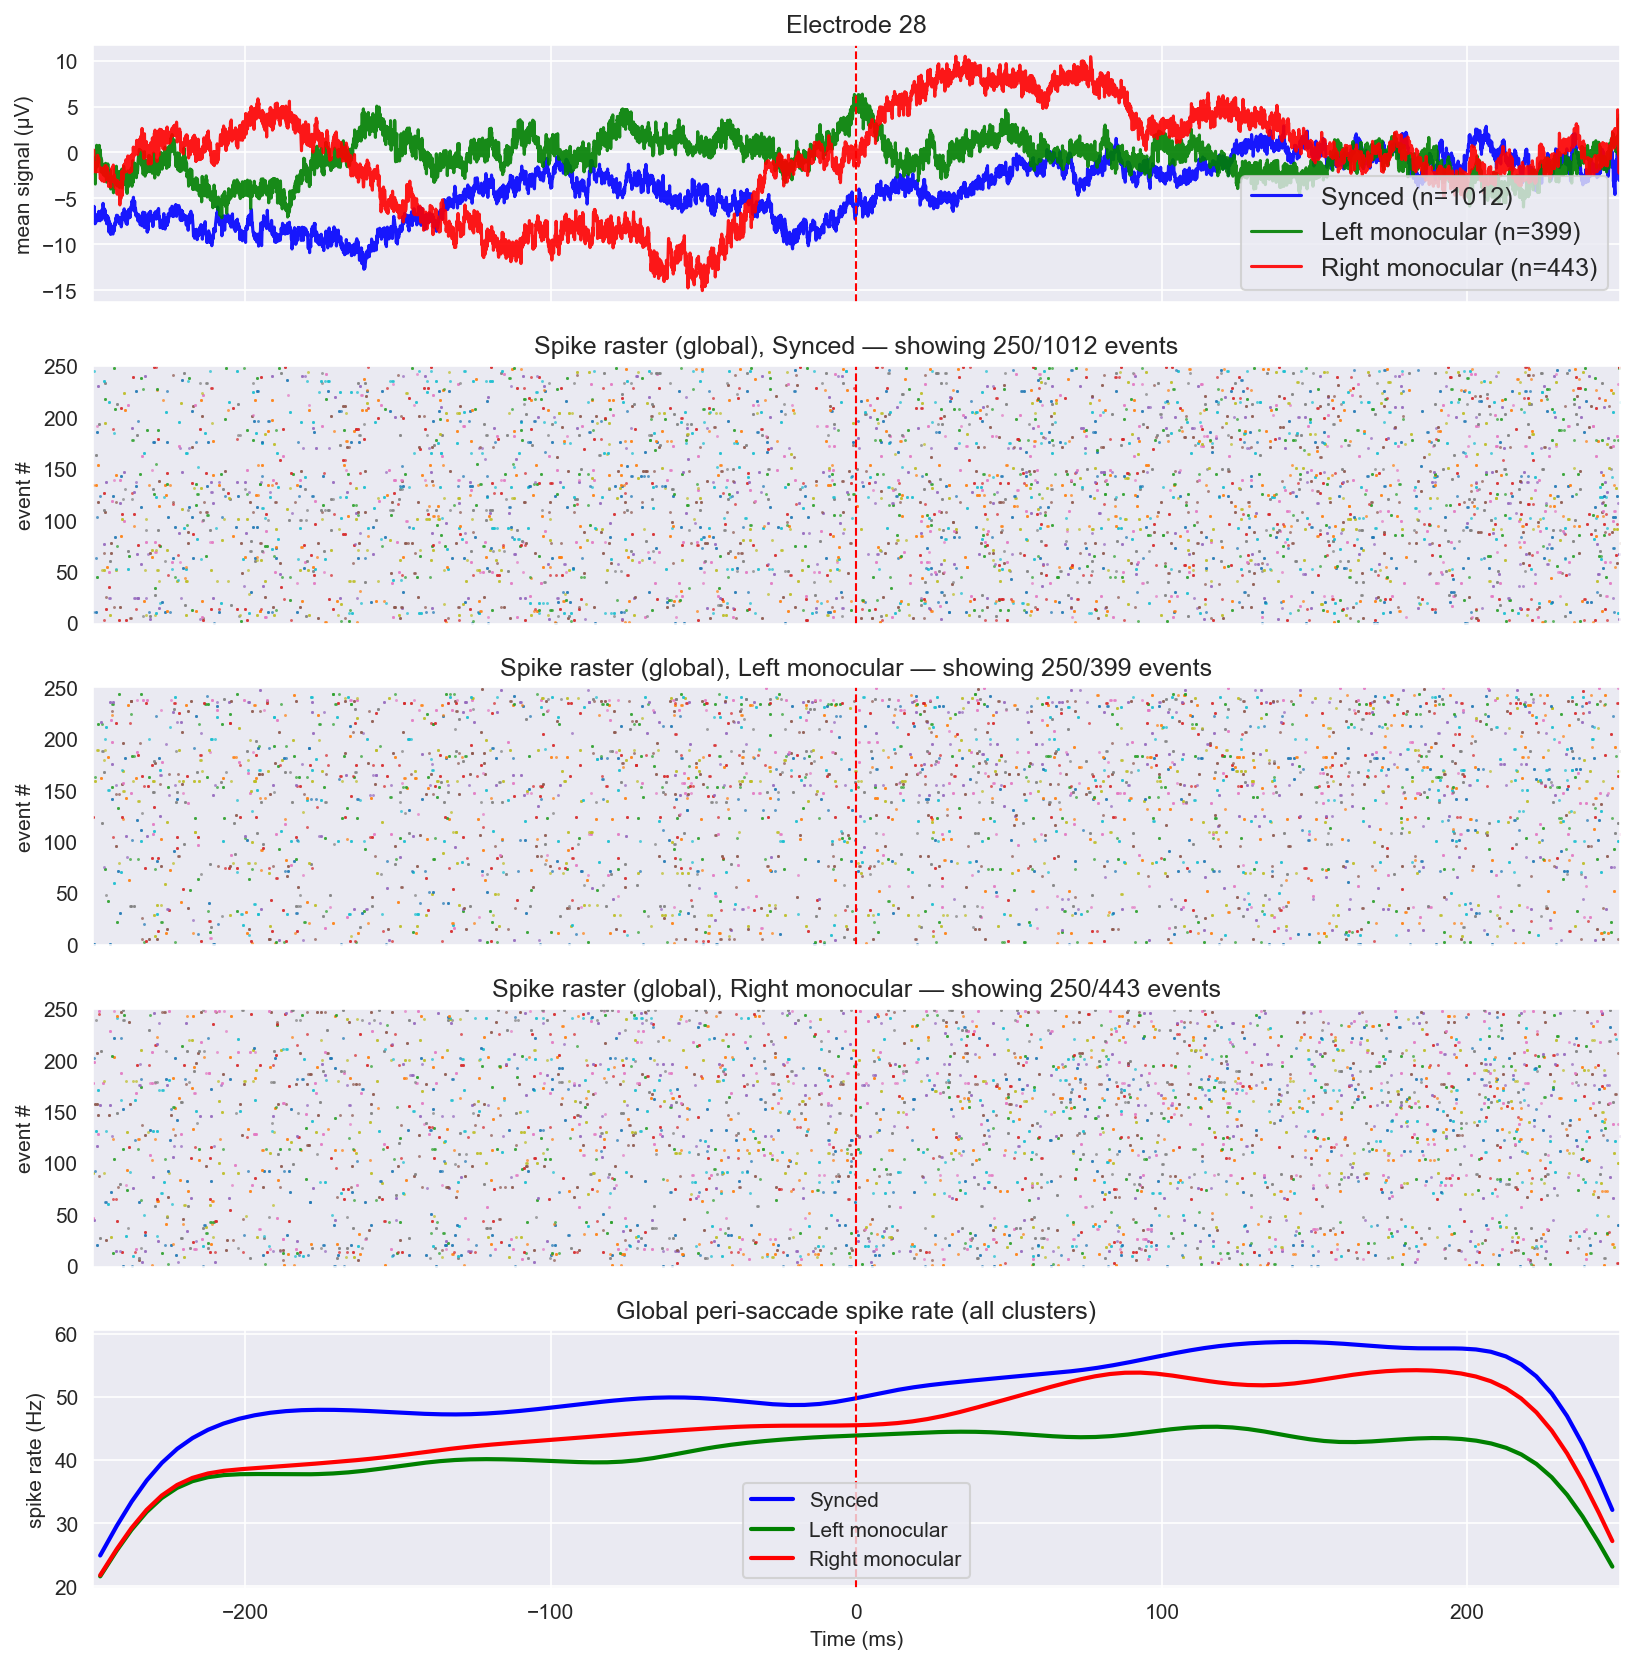

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_multi_electrode_saccade_averages_with_spikes(
    synced_data_arr,
    l_non_synced_data,
    r_non_synced_data,
    electrode_labels,
    lfp_sampling_rate_hz,
    synced_event_ms,
    l_event_ms,
    r_event_ms,
    phy_dir,
    *,
    spike_fs_hz=20000,
    variance_threshold_factor=1.5,
    use_good_clusters=True,
    # PETH params
    peth_bin_ms=5.0,
    peth_smooth_sigma_ms=20.0,
    # Raster params
    raster_max_events=250,         # keep it light; increase if you want
    raster_marker_size=2.0,
    raster_alpha=0.7,
    # Layout
    figsize_width=11,
    electrode_row_height=3.0,
    raster_row_height=2.0,
    peth_row_height=2.2,
    export_path=None,
):
    """
    Per-electrode LFP peri-event means + global spike raster(s) + global PETH.

    Panels:
      - N electrode rows: LFP mean traces (synced / L / R)
      - 3 raster rows: synced, left mono, right mono (global spikes, per-event rows)
      - 1 PETH row: synced, left mono, right mono (global spikes)

    All times are in ms. spike_times are loaded from phy and converted to ms using spike_fs_hz.
    Event times are filtered to match high-variance LFP event removal (per condition).
    """

    # -------------------------
    # Helpers
    # -------------------------
    def remove_high_variance_events(data_array, threshold_factor=1.5):
        electrodes, events, traces = data_array.shape
        filtered = np.array(data_array, copy=True)
        num_invalid = 0
        for e in range(electrodes):
            event_vars = np.nanvar(data_array[e], axis=1)
            med = np.median(event_vars)
            invalid = event_vars > (threshold_factor * med)
            filtered[e, invalid, :] = np.nan
            num_invalid += int(np.sum(invalid))
        return filtered, num_invalid

    def valid_event_mask(filtered_arr):
        # event valid if not all-NaN across electrodes & samples
        return ~np.all(np.isnan(filtered_arr), axis=(0, 2))

    def load_phy_folder_ms(phy_dir, spike_fs_hz, use_good_clusters=True):
        phy_dir = Path(phy_dir)
        spike_times_samp = np.load(phy_dir / "spike_times.npy").squeeze().astype(np.int64)
        spike_clusters = np.load(phy_dir / "spike_clusters.npy").squeeze().astype(np.int64)

        spike_times_ms = spike_times_samp.astype(np.float64) * (1000.0 / float(spike_fs_hz))

        cluster_group = None
        cg_path = phy_dir / "cluster_group.tsv"
        if cg_path.exists():
            cluster_group = pd.read_csv(cg_path, sep="\t")

        if use_good_clusters and (cluster_group is not None) and {"cluster_id", "group"}.issubset(cluster_group.columns):
            good = cluster_group.loc[
                cluster_group["group"].astype(str).str.lower().eq("good"),
                "cluster_id"
            ].values.astype(np.int64)
            if good.size > 0:
                m = np.isin(spike_clusters, good)
                spike_times_ms = spike_times_ms[m]
                spike_clusters = spike_clusters[m]

        return spike_times_ms, spike_clusters

    def peth_rate_hz_ms(spike_times_ms, event_times_ms, window_ms, bin_ms=5.0, smooth_sigma_ms=20.0):
        spike_times_ms = np.asarray(spike_times_ms, dtype=np.float64)
        event_times_ms = np.asarray(event_times_ms, dtype=np.float64)

        edges = np.arange(-window_ms, window_ms + bin_ms, bin_ms, dtype=np.float64)
        centers = (edges[:-1] + edges[1:]) / 2.0

        counts = np.zeros(len(edges) - 1, dtype=np.float64)
        n_events = max(1, len(event_times_ms))

        for t0 in event_times_ms:
            lo, hi = t0 - window_ms, t0 + window_ms
            rel = spike_times_ms[(spike_times_ms >= lo) & (spike_times_ms < hi)] - t0
            c, _ = np.histogram(rel, bins=edges)
            counts += c

        rate_hz = (counts / n_events) / (bin_ms / 1000.0)

        if smooth_sigma_ms and smooth_sigma_ms > 0:
            sigma_bins = smooth_sigma_ms / bin_ms
            half = int(np.ceil(4 * sigma_bins))
            x = np.arange(-half, half + 1)
            k = np.exp(-(x**2) / (2 * sigma_bins**2))
            k /= k.sum()
            rate_hz = np.convolve(rate_hz, k, mode="same")

        return centers, rate_hz

    def compute_raster(spike_times_ms, event_times_ms, window_ms, max_events=None):
        """
        Returns list of arrays, each containing spike times (ms) relative to event.
        """
        event_times_ms = np.asarray(event_times_ms, dtype=np.float64)
        if max_events is not None and len(event_times_ms) > max_events:
            # deterministic subsample: evenly spaced indices
            idx = np.linspace(0, len(event_times_ms) - 1, max_events).astype(int)
            event_times_ms = event_times_ms[idx]

        ras = []
        for t0 in event_times_ms:
            lo, hi = t0 - window_ms, t0 + window_ms
            rel = spike_times_ms[(spike_times_ms >= lo) & (spike_times_ms < hi)] - t0
            ras.append(rel)
        return ras, event_times_ms

    def plot_raster_axis(ax, raster_list, window_ms, title):
        ax.axvline(0, color="red", linestyle="--", linewidth=1)
        for row, rel in enumerate(raster_list):
            if rel.size == 0:
                continue
            y = np.full(rel.shape, row, dtype=np.float64)
            ax.scatter(rel, y, s=raster_marker_size, alpha=raster_alpha, linewidths=0)
        ax.set_xlim(-window_ms, window_ms)
        ax.set_ylim(-1, len(raster_list))
        ax.set_ylabel("event #")
        ax.set_title(title)
        ax.grid(False)

    # -------------------------
    # 1) Filter LFP events (and sync masks to event arrays)
    # -------------------------
    synced_filt, synced_nbad = remove_high_variance_events(synced_data_arr, variance_threshold_factor)
    l_filt, l_nbad = remove_high_variance_events(l_non_synced_data, variance_threshold_factor)
    r_filt, r_nbad = remove_high_variance_events(r_non_synced_data, variance_threshold_factor)

    synced_mask = valid_event_mask(synced_filt)
    l_mask = valid_event_mask(l_filt)
    r_mask = valid_event_mask(r_filt)

    synced_event_ms = np.asarray(synced_event_ms, dtype=np.float64)[synced_mask]
    l_event_ms = np.asarray(l_event_ms, dtype=np.float64)[l_mask]
    r_event_ms = np.asarray(r_event_ms, dtype=np.float64)[r_mask]

    # -------------------------
    # 2) LFP x-axis in ms and window
    # -------------------------
    num_electrodes = synced_filt.shape[0]
    num_samples = synced_filt.shape[2]
    x_vals = (np.arange(-num_samples // 2, num_samples // 2) * 1000.0 / float(lfp_sampling_rate_hz))
    window_ms = (num_samples / 2) * 1000.0 / float(lfp_sampling_rate_hz)

    # -------------------------
    # 3) Load spikes (ms) and build raster + PETH
    # -------------------------
    spike_times_ms, _ = load_phy_folder_ms(phy_dir, spike_fs_hz=spike_fs_hz, use_good_clusters=use_good_clusters)

    # Raster lists (subsample for clarity)
    ras_sync, used_sync = compute_raster(spike_times_ms, synced_event_ms, window_ms, max_events=raster_max_events)
    ras_l, used_l       = compute_raster(spike_times_ms, l_event_ms,      window_ms, max_events=raster_max_events)
    ras_r, used_r       = compute_raster(spike_times_ms, r_event_ms,      window_ms, max_events=raster_max_events)

    # PETH (use all filtered events, not only the subsampled raster events)
    t_ms, rate_sync = peth_rate_hz_ms(spike_times_ms, synced_event_ms, window_ms,
                                      bin_ms=peth_bin_ms, smooth_sigma_ms=peth_smooth_sigma_ms)
    _, rate_l = peth_rate_hz_ms(spike_times_ms, l_event_ms, window_ms,
                                bin_ms=peth_bin_ms, smooth_sigma_ms=peth_smooth_sigma_ms)
    _, rate_r = peth_rate_hz_ms(spike_times_ms, r_event_ms, window_ms,
                                bin_ms=peth_bin_ms, smooth_sigma_ms=peth_smooth_sigma_ms)

    # Resample PETH to LFP x-grid (so bottom panel shares exact x ticks)
    rate_sync_rs = np.interp(x_vals, t_ms, rate_sync, left=np.nan, right=np.nan)
    rate_l_rs = np.interp(x_vals, t_ms, rate_l, left=np.nan, right=np.nan)
    rate_r_rs = np.interp(x_vals, t_ms, rate_r, left=np.nan, right=np.nan)

    # -------------------------
    # 4) Plot layout: electrodes + 3 rasters + 1 PETH
    # -------------------------
    total_rows = num_electrodes + 3 + 1
    fig_h = num_electrodes * electrode_row_height + 3 * raster_row_height + peth_row_height
    fig, axs = plt.subplots(total_rows, 1, figsize=(figsize_width, fig_h), dpi=150, sharex=True)

    # Electrode panels
    for i in range(num_electrodes):
        synced_mean = np.nanmean(synced_filt[i], axis=0)
        l_mean = np.nanmean(l_filt[i], axis=0)
        r_mean = np.nanmean(r_filt[i], axis=0)

        axs[i].plot(x_vals, synced_mean, color="blue",  alpha=0.9, label=f"Synced (n={synced_event_ms.size})")
        axs[i].plot(x_vals, l_mean,      color="green", alpha=0.9, label=f"Left monocular (n={l_event_ms.size})")
        axs[i].plot(x_vals, r_mean,      color="red",   alpha=0.9, label=f"Right monocular (n={r_event_ms.size})")

        axs[i].axvline(0, color="red", linestyle="--", linewidth=1)
        axs[i].set_ylabel("mean signal (µV)")
        axs[i].set_title(f"Electrode {electrode_labels[i]}")

        if i == 0:
            axs[i].legend(loc="best", fontsize="large")

    # Raster panels
    r0 = num_electrodes
    plot_raster_axis(
        axs[r0 + 0], ras_sync, window_ms,
        title=f"Spike raster (global), Synced — showing {len(used_sync)}/{synced_event_ms.size} events"
    )
    plot_raster_axis(
        axs[r0 + 1], ras_l, window_ms,
        title=f"Spike raster (global), Left monocular — showing {len(used_l)}/{l_event_ms.size} events"
    )
    plot_raster_axis(
        axs[r0 + 2], ras_r, window_ms,
        title=f"Spike raster (global), Right monocular — showing {len(used_r)}/{r_event_ms.size} events"
    )

    # PETH panel
    axp = axs[-1]
    axp.plot(x_vals, rate_sync_rs, color="blue",  linewidth=2, label="Synced")
    axp.plot(x_vals, rate_l_rs,    color="green", linewidth=2, label="Left monocular")
    axp.plot(x_vals, rate_r_rs,    color="red",   linewidth=2, label="Right monocular")
    axp.axvline(0, color="red", linestyle="--", linewidth=1)
    axp.set_ylabel("spike rate (Hz)")
    axp.set_xlabel("Time (ms)")
    axp.set_title("Global peri-saccade spike rate (all clusters)")
    axp.legend(loc="best")

    plt.tight_layout()
    if export_path is not None:
        plt.savefig(export_path)
    plt.show()

    return {
        "synced_invalid_events_total": synced_nbad,
        "l_invalid_events_total": l_nbad,
        "r_invalid_events_total": r_nbad,
        "synced_events_used_for_peth": int(synced_event_ms.size),
        "l_events_used_for_peth": int(l_event_ms.size),
        "r_events_used_for_peth": int(r_event_ms.size),
        "raster_events_shown": {
            "synced": int(len(used_sync)),
            "left": int(len(used_l)),
            "right": int(len(used_r)),
        },
        "spike_count_used": int(spike_times_ms.size),
    }

out = plot_multi_electrode_saccade_averages_with_spikes(
    synced_data_arr=filtered_synced_arr[0],      # or your raw arrays; this function filters internally
    l_non_synced_data=filtered_l_arr[0],
    r_non_synced_data=filtered_r_arr[0],
    electrode_labels=electrode,                  # list/array of channel IDs or labels
    lfp_sampling_rate_hz=block.sample_rate,
    synced_event_ms=synced_saccade_collection.saccade_on_ms.values,             # 1D array of event centers (ms)
    l_event_ms=non_synced_saccade_collection.query('eye == "L"').saccade_on_ms.values,
    r_event_ms=non_synced_saccade_collection.query('eye == "R"').saccade_on_ms.values,
    phy_dir=phy_dir,                             # KS/phy output folder
    spike_fs_hz=20000,
    export_path=export_path
)

In [97]:
import numpy as np
import pandas as pd
from scipy.signal import welch
import matplotlib.pyplot as plt


def _get_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"None of these columns found: {candidates}. Available: {list(df.columns)[:30]} ...")


def _contiguous_segments(mask, min_len):
    """
    mask: 1D boolean array
    returns list of (start_idx, end_idx_exclusive) segments where mask is True
    """
    mask = np.asarray(mask, dtype=bool)
    if mask.size == 0:
        return []
    d = np.diff(mask.astype(int))
    starts = np.where(d == 1)[0] + 1
    ends   = np.where(d == -1)[0] + 1
    if mask[0]:
        starts = np.r_[0, starts]
    if mask[-1]:
        ends = np.r_[ends, mask.size]
    segs = [(int(s), int(e)) for s, e in zip(starts, ends) if (e - s) >= int(min_len)]
    return segs


def pupil_conditioned_psd(
    block,
    electrode,
    window_s=2.0,
    step_s=0.5,
    criterion="z",               # "z" or "quantile"
    z_thresh=1.5,                # used if criterion="z"
    q=(0.2, 0.8),                 # used if criterion="quantile"
    min_windows_per_condition=30,
    pupil_z_col_candidates=("pupil_diameter","pupil_z", "pupil_zscore", "pupil_diam_z", "pupil_diameter_z"),
    ms_col_candidates=("ms_axis", "t_ms", "time_ms", "ms"),
    verbose=True,
):
    """
    Computes Welch PSDs of LFP around timepoints classified by pupil size.
    Conditions:
      L_large, L_small, R_large, R_small, Both_large, Both_small

    Assumes:
      - block.left_eye_data and block.right_eye_data are DataFrames
      - both contain timebase column (ms) and pupil z-score column
      - ms_axis is aligned to the OE ms timebase that oe_rec.get_data expects

    Returns:
      results: dict condition -> dict(f, psd_mean, psd_sem, n_windows)
    """
    oe = block.oe_rec
    fs = float(getattr(block, "sample_rate", None) or getattr(oe, "sample_rate", None))
    if not np.isfinite(fs) or fs <= 0:
        raise ValueError("Could not infer sample rate from block or oe_rec.")

    Ldf = block.left_eye_data
    Rdf = block.right_eye_data

    Lz_col = _get_col(Ldf, pupil_z_col_candidates)
    Rz_col = _get_col(Rdf, pupil_z_col_candidates)
    Lms_col = _get_col(Ldf, ms_col_candidates)
    Rms_col = _get_col(Rdf, ms_col_candidates)

    # Merge to a common timebase by ms (nearest merge)
    # Use left as reference; align right by nearest ms
    base = Ldf[[Lms_col, Lz_col]].copy()
    base = base.rename(columns={Lms_col: "ms", Lz_col: "Lz"}).sort_values("ms")
    rtmp = Rdf[[Rms_col, Rz_col]].copy()
    rtmp = rtmp.rename(columns={Rms_col: "ms", Rz_col: "Rz"}).sort_values("ms")

    merged = pd.merge_asof(base, rtmp, on="ms", direction="nearest", tolerance=2.0)  # 2 ms tolerance
    merged = merged.dropna(subset=["Lz", "Rz"])

    if merged.empty:
        raise ValueError("No overlapping L/R pupil data after time alignment. Check ms columns and tolerance.")

    Lz = merged["Lz"].to_numpy(dtype=float)
    Rz = merged["Rz"].to_numpy(dtype=float)
    ms = merged["ms"].to_numpy(dtype=float)

    # Determine thresholds
    if criterion == "z":
        large_L = Lz > z_thresh
        small_L = Lz < -z_thresh
        large_R = Rz > z_thresh
        small_R = Rz < -z_thresh
    elif criterion == "quantile":
        qlow, qhigh = q
        L_lo, L_hi = np.nanquantile(Lz, [qlow, qhigh])
        R_lo, R_hi = np.nanquantile(Rz, [qlow, qhigh])
        large_L = Lz >= L_hi
        small_L = Lz <= L_lo
        large_R = Rz >= R_hi
        small_R = Rz <= R_lo
    else:
        raise ValueError("criterion must be 'z' or 'quantile'")

    cond_masks = {
        "L_large": large_L,
        "L_small": small_L,
        "R_large": large_R,
        "R_small": small_R,
        "Both_large": large_L & large_R,
        "Both_small": small_L & small_R,
    }

    # Windowing in pupil-time domain (ms is in ms)
    win_ms = window_s * 1000.0
    step_ms = step_s * 1000.0

    # We will sample window *centers* at pupil timestamps, then request LFP windows centered there.
    # Using get_data: start_time = center - win/2
    half = win_ms / 2.0

    results = {}
    for name, mask in cond_masks.items():
        mask = np.asarray(mask, dtype=bool)
        if not np.any(mask):
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0)
            continue

        # Choose centers by stepping through ms where mask is True
        # Strategy: take contiguous segments of True, then place centers every step_ms.
        # Need pupil sampling interval estimate to set min segment length.
        dt_est = np.nanmedian(np.diff(ms))
        if not np.isfinite(dt_est) or dt_est <= 0:
            dt_est = 16.67  # fallback
        min_len = int(np.ceil(win_ms / dt_est))  # must at least cover one window in pupil samples

        segs = _contiguous_segments(mask, min_len=min_len)

        centers = []
        for s, e in segs:
            # candidate centers between s and e-1
            t0 = ms[s] + half
            t1 = ms[e - 1] - half
            if t1 <= t0:
                continue
            # grid centers every step_ms
            c = np.arange(t0, t1 + 1e-6, step_ms)
            centers.append(c)

        if len(centers) == 0:
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0)
            continue

        centers_ms = np.concatenate(centers).astype(float)
        start_times_ms = centers_ms - half

        # Pull LFP windows for this electrode
        data, _ = oe.get_data(
            channels=[int(electrode)],
            start_time_ms=start_times_ms,
            window_ms=float(win_ms),
            convert_to_mv=True,
            return_timestamps=True,
            repress_output=True
        )
        if data is None:
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0)
            continue

        x = np.asarray(data, dtype=float)  # [1, n_windows, n_samp]
        x = x[0]                            # [n_windows, n_samp]
        n_win = x.shape[0]

        if n_win < min_windows_per_condition:
            if verbose:
                print(f"{name}: only {n_win} windows (<{min_windows_per_condition}); keeping but interpret cautiously.")

        # Welch PSD per window
        psds = []
        for i in range(n_win):
            f, Pxx = welch(x[i], fs=fs, nperseg=min(1024, x.shape[1]))
            psds.append(Pxx)
        psds = np.vstack(psds)  # [n_win, n_freq]

        psd_mean = np.nanmean(psds, axis=0)
        psd_sem = np.nanstd(psds, axis=0, ddof=1) / np.sqrt(n_win) if n_win >= 2 else np.full_like(psd_mean, np.nan)

        results[name] = dict(f=f, psd_mean=psd_mean, psd_sem=psd_sem, n_windows=int(n_win))

        if verbose:
            print(f"{name}: n_windows={n_win}")

    return results


def plot_psd_conditions(results, title="Pupil-conditioned PSD", fmax=200):
    fig, ax = plt.subplots(figsize=(7.5, 3.5))
    for name, out in results.items():
        if out["f"] is None:
            continue
        f = out["f"]
        m = out["psd_mean"]
        ax.plot(f, m, label=f"{name} (n={out['n_windows']})")
    ax.set_xlim(0, fmax)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("PSD (units^2/Hz)")
    ax.set_title(title)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(frameon=False, fontsize=8)
    fig.tight_layout()
    return fig, ax


import numpy as np
import pandas as pd
from scipy.signal import welch, resample_poly
from fractions import Fraction
import matplotlib.pyplot as plt

def pupil_conditioned_psd_hi_res(
    block,
    electrode,
    window_s=2.0,
    step_s=0.5,
    criterion="z",                 # "z" or "quantile"
    z_thresh=1.5,
    q=(0.2, 0.8),
    pupil_z_col_candidates=("pupil_diameter","pupil_z", "pupil_zscore", "pupil_diam_z", "pupil_diameter_z"),
    ms_col_candidates=("ms_axis", "t_ms", "time_ms", "ms"),
    merge_tol_ms=2.0,

    # --- PSD controls ---
    target_fs_hz=1000.0,           # key: downsample for low-freq resolution (set None to disable)
    nperseg_s=2.0,                 # segment length in seconds (<= window_s)
    noverlap_frac=0.5,             # Welch overlap fraction
    detrend="constant",            # remove DC (helps compare states)
    verbose=True,
):
    """
    Returns dict:
      results[name] = dict(f, psd_mean, psd_sem, n_windows, fs_used)
    where name in: L_large, L_small, R_large, R_small, Both_large, Both_small
    """

    oe = block.oe_rec
    fs_raw = float(getattr(block, "sample_rate", None) or getattr(oe, "sample_rate", None))
    if not np.isfinite(fs_raw) or fs_raw <= 0:
        raise ValueError("Could not infer sample rate from block or oe_rec.")

    Ldf = block.left_eye_data
    Rdf = block.right_eye_data

    def _get_col(df, candidates):
        for c in candidates:
            if c in df.columns:
                return c
        raise ValueError(f"None of these columns found: {candidates}. Available: {list(df.columns)[:30]} ...")

    Lz_col = _get_col(Ldf, pupil_z_col_candidates)
    Rz_col = _get_col(Rdf, pupil_z_col_candidates)
    Lms_col = _get_col(Ldf, ms_col_candidates)
    Rms_col = _get_col(Rdf, ms_col_candidates)

    # Merge to common ms axis
    base = Ldf[[Lms_col, Lz_col]].copy().rename(columns={Lms_col: "ms", Lz_col: "Lz"}).sort_values("ms")
    rtmp = Rdf[[Rms_col, Rz_col]].copy().rename(columns={Rms_col: "ms", Rz_col: "Rz"}).sort_values("ms")
    merged = pd.merge_asof(base, rtmp, on="ms", direction="nearest", tolerance=float(merge_tol_ms))
    merged = merged.dropna(subset=["Lz", "Rz"])
    if merged.empty:
        raise ValueError("No overlapping L/R pupil samples after merge_asof. Check ms columns and tolerance.")

    Lz = merged["Lz"].to_numpy(dtype=float)
    Rz = merged["Rz"].to_numpy(dtype=float)
    ms = merged["ms"].to_numpy(dtype=float)

    # Guard: if user accidentally passed raw diameter column as zscore
    def _ensure_z(x, colname):
        cname = str(colname).lower()
        if "z" in cname:
            return x
        # convert raw to z on the fly (block-level)
        mu = np.nanmean(x); sd = np.nanstd(x)
        if sd == 0 or not np.isfinite(sd):
            raise ValueError(f"Column '{colname}' doesn't look z-scored and can't be z-scored (std invalid).")
        if verbose:
            print(f"Note: '{colname}' doesn't look z-scored; converting to z within this block.")
        return (x - mu) / sd

    Lz = _ensure_z(Lz, Lz_col)
    Rz = _ensure_z(Rz, Rz_col)

    # thresholds
    if criterion == "z":
        large_L = Lz > z_thresh
        small_L = Lz < -z_thresh
        large_R = Rz > z_thresh
        small_R = Rz < -z_thresh
    elif criterion == "quantile":
        qlow, qhigh = q
        L_lo, L_hi = np.nanquantile(Lz, [qlow, qhigh])
        R_lo, R_hi = np.nanquantile(Rz, [qlow, qhigh])
        large_L = Lz >= L_hi
        small_L = Lz <= L_lo
        large_R = Rz >= R_hi
        small_R = Rz <= R_lo
    else:
        raise ValueError("criterion must be 'z' or 'quantile'")

    cond_masks = {
        "L_large": large_L,
        "L_small": small_L,
        "R_large": large_R,
        "R_small": small_R,
        "Both_large": large_L & large_R,
        "Both_small": small_L & small_R,
    }

    # window grid in ms (centers)
    win_ms = float(window_s) * 1000.0
    step_ms = float(step_s) * 1000.0
    half = win_ms / 2.0

    # Resampling factors (once)
    fs_used = fs_raw
    up = down = 1
    if target_fs_hz is not None and fs_raw > float(target_fs_hz):
        frac = Fraction(float(target_fs_hz) / fs_raw).limit_denominator(2000)
        up, down = frac.numerator, frac.denominator
        fs_used = fs_raw * up / down
        if verbose:
            print(f"Downsampling for PSD: fs_raw={fs_raw:.2f} Hz -> fs_used={fs_used:.2f} Hz (up={up}, down={down})")

    # Welch params
    # true frequency resolution ~ 1 / nperseg_s (after downsampling)
    nperseg = int(round(fs_used * min(float(nperseg_s), float(window_s))))
    noverlap = int(round(noverlap_frac * nperseg))
    if noverlap >= nperseg:
        noverlap = nperseg // 2

    results = {}
    for name, mask in cond_masks.items():
        mask = np.asarray(mask, dtype=bool)
        if not np.any(mask):
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0, fs_used=fs_used)
            continue

        # contiguous True segments in pupil time, then place centers every step_ms
        dt_est = np.nanmedian(np.diff(ms))
        if not np.isfinite(dt_est) or dt_est <= 0:
            dt_est = 16.67
        min_len = int(np.ceil(win_ms / dt_est))

        # find segments
        d = np.diff(mask.astype(int))
        starts = np.where(d == 1)[0] + 1
        ends = np.where(d == -1)[0] + 1
        if mask[0]: starts = np.r_[0, starts]
        if mask[-1]: ends = np.r_[ends, mask.size]

        centers = []
        for s, e in zip(starts, ends):
            if (e - s) < min_len:
                continue
            t0 = ms[s] + half
            t1 = ms[e - 1] - half
            if t1 <= t0:
                continue
            centers.append(np.arange(t0, t1 + 1e-6, step_ms))

        if len(centers) == 0:
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0, fs_used=fs_used)
            continue

        centers_ms = np.concatenate(centers).astype(float)
        start_times_ms = centers_ms - half

        # Pull LFP windows (return_timestamps=False saves overhead)
        data = oe.get_data(
            channels=[int(electrode)],
            start_time_ms=start_times_ms,
            window_ms=win_ms,
            convert_to_mv=True,
            return_timestamps=False,
            repress_output=True
        )
        if data is None:
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0, fs_used=fs_used)
            continue

        x = np.asarray(data, dtype=float)[0]  # [n_win, n_samp_raw]
        n_win = x.shape[0]

        # downsample each window if needed
        if up != 1 or down != 1:
            x = resample_poly(x, up, down, axis=1)

        # Welch per window
        psds = []
        f = None
        for i in range(n_win):
            f, Pxx = welch(
                x[i],
                fs=fs_used,
                nperseg=min(nperseg, x.shape[1]),
                noverlap=min(noverlap, max(0, min(nperseg, x.shape[1]) - 1)),
                detrend=detrend
            )
            psds.append(Pxx)
        psds = np.vstack(psds)

        psd_mean = np.nanmean(psds, axis=0)
        psd_sem = np.nanstd(psds, axis=0, ddof=1) / np.sqrt(n_win) if n_win >= 2 else np.full_like(psd_mean, np.nan)

        results[name] = dict(f=f, psd_mean=psd_mean, psd_sem=psd_sem, n_windows=int(n_win), fs_used=fs_used)

        if verbose:
            df = f[1] - f[0] if (f is not None and len(f) > 1) else np.nan
            print(f"{name}: n_windows={n_win}, df≈{df:.3f} Hz")

    return results


def plot_psd_split(results, fmax=40, show_sem=False, title=None):
    """
    3 panels: Left, Right, Both. Each shows large vs small.
    """
    groups = [
        ("Left pupil",  ["L_large", "L_small"]),
        ("Right pupil", ["R_large", "R_small"]),
        ("Both pupils", ["Both_large", "Both_small"]),
    ]

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.2), sharey=True)
    for ax, (gtitle, keys) in zip(axs, groups):
        for k in keys:
            out = results.get(k, None)
            if out is None or out["f"] is None:
                continue
            f = out["f"]
            m = out["psd_mean"]
            ax.plot(f, m, lw=1.8, label=f"{k} (n={out['n_windows']})")
            if show_sem and out["psd_sem"] is not None:
                s = out["psd_sem"]
                ax.fill_between(f, m - s, m + s, alpha=0.2)
        ax.set_xlim(0, fmax)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_title(gtitle)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.legend(frameon=False, fontsize=8)
        ax.set_yscale('log')

    axs[0].set_ylabel("PSD (units$^2$/Hz)")
    if title:
        fig.suptitle(title, y=1.03)
    fig.tight_layout()
    return fig, axs


In [81]:
res = pupil_conditioned_psd(
    block=block,
    electrode=28,
    window_s=2.0,
    step_s=0.5,
    criterion="quantile",      # or "quantile"
    q=(0.2,0.8),
    verbose=True
)
fig, ax = plot_psd_conditions(res, title="Electrode 28: pupil-conditioned PSD", fmax=200)
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
fig.savefig(block.analysis_path / f"{t}_pupil_conditioned_psd_e28.pdf")
plt.show()


L_large: n_windows=526
L_small: n_windows=452
R_large: n_windows=430
R_small: n_windows=690
Both_large: n_windows=54
Both_small: n_windows=70


Downsampling: fs_raw=20000.00 Hz -> fs_used=1000.00 Hz (up=1, down=20)
L_large: n_windows=526, df≈0.500 Hz
L_small: n_windows=452, df≈0.500 Hz
R_large: n_windows=430, df≈0.500 Hz
R_small: n_windows=690, df≈0.500 Hz
Both_large: n_windows=54, df≈0.500 Hz
Both_small: n_windows=70, df≈0.500 Hz


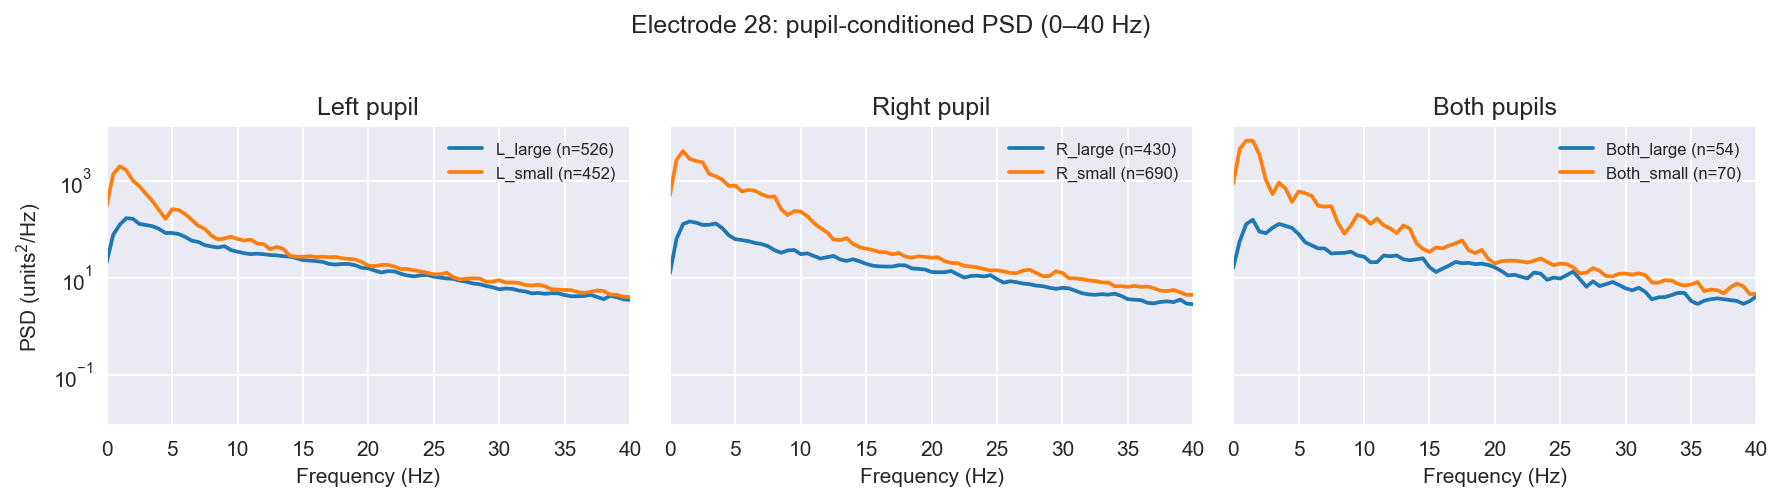

In [99]:
import numpy as np
import pandas as pd
from scipy.signal import welch, resample_poly
from fractions import Fraction

def pupil_conditioned_psd_from_diameter(
    block,
    electrode,
    window_s=2.0,
    step_s=0.5,

    # classification
    criterion="z",           # "z" or "quantile"
    z_thresh=1.5,            # used if criterion="z"
    q=(0.2, 0.8),            # used if criterion="quantile"

    # time alignment
    ms_col="ms_axis",        # must exist in left_eye_data and right_eye_data
    merge_tol_ms=2.0,

    # PSD controls
    target_fs_hz=1000.0,     # downsample for good low-freq resolution (None disables)
    nperseg_s=2.0,           # segment length in seconds (<= window_s)
    noverlap_frac=0.5,
    detrend="constant",

    # data quality
    min_windows_per_condition=30,
    verbose=True,
):
    """
    Compute pupil-conditioned PSDs using RAW pupil diameter from both eyes.
    ALWAYS uses column 'pupil_diameter' and computes z-scores internally.

    Conditions:
      L_large, L_small, R_large, R_small, Both_large, Both_small

    Returns:
      results: dict condition -> dict(f, psd_mean, psd_sem, n_windows, fs_used, z_params)
    """
    # --- sanity: required columns ---
    for side, df in (("left", block.left_eye_data), ("right", block.right_eye_data)):
        if "pupil_diameter" not in df.columns:
            raise ValueError(f"{side}_eye_data is missing required column 'pupil_diameter'.")
        if ms_col not in df.columns:
            raise ValueError(f"{side}_eye_data is missing required time column '{ms_col}'.")

    oe = block.oe_rec
    fs_raw = float(getattr(block, "sample_rate", None) or getattr(oe, "sample_rate", None))
    if not np.isfinite(fs_raw) or fs_raw <= 0:
        raise ValueError("Could not infer sample rate from block or oe_rec.")

    # --- align L/R pupil samples on a common ms axis (use left as reference) ---
    Ldf = block.left_eye_data[[ms_col, "pupil_diameter"]].copy()
    Rdf = block.right_eye_data[[ms_col, "pupil_diameter"]].copy()
    Ldf = Ldf.rename(columns={ms_col: "ms", "pupil_diameter": "Ldiam"}).sort_values("ms")
    Rdf = Rdf.rename(columns={ms_col: "ms", "pupil_diameter": "Rdiam"}).sort_values("ms")

    merged = pd.merge_asof(Ldf, Rdf, on="ms", direction="nearest", tolerance=float(merge_tol_ms))
    merged = merged.dropna(subset=["Ldiam", "Rdiam"])
    if merged.empty:
        raise ValueError("No overlapping L/R pupil samples after merge_asof. Check ms_col and merge_tol_ms.")

    ms = merged["ms"].to_numpy(dtype=float)
    Ld = merged["Ldiam"].to_numpy(dtype=float)
    Rd = merged["Rdiam"].to_numpy(dtype=float)

    # --- compute z-scores internally (block-level) ---
    def zscore(x):
        mu = np.nanmean(x)
        sd = np.nanstd(x)
        if not np.isfinite(mu) or not np.isfinite(sd) or sd == 0:
            raise ValueError("Cannot z-score pupil_diameter (mean/std invalid).")
        return (x - mu) / sd, float(mu), float(sd)

    Lz, L_mu, L_sd = zscore(Ld)
    Rz, R_mu, R_sd = zscore(Rd)

    # --- thresholds ---
    if criterion == "z":
        large_L = Lz > float(z_thresh)
        small_L = Lz < -float(z_thresh)
        large_R = Rz > float(z_thresh)
        small_R = Rz < -float(z_thresh)
    elif criterion == "quantile":
        qlow, qhigh = q
        L_lo, L_hi = np.nanquantile(Lz, [qlow, qhigh])
        R_lo, R_hi = np.nanquantile(Rz, [qlow, qhigh])
        large_L = Lz >= L_hi
        small_L = Lz <= L_lo
        large_R = Rz >= R_hi
        small_R = Rz <= R_lo
    else:
        raise ValueError("criterion must be 'z' or 'quantile'")

    cond_masks = {
        "L_large": large_L,
        "L_small": small_L,
        "R_large": large_R,
        "R_small": small_R,
        "Both_large": large_L & large_R,
        "Both_small": small_L & small_R,
    }

    # --- windowing (center times in ms) ---
    win_ms = float(window_s) * 1000.0
    step_ms = float(step_s) * 1000.0
    half = win_ms / 2.0

    # --- downsample factors for PSD resolution ---
    fs_used = fs_raw
    up = down = 1
    if target_fs_hz is not None and fs_raw > float(target_fs_hz):
        frac = Fraction(float(target_fs_hz) / fs_raw).limit_denominator(2000)
        up, down = frac.numerator, frac.denominator
        fs_used = fs_raw * up / down
        if verbose:
            print(f"Downsampling: fs_raw={fs_raw:.2f} Hz -> fs_used={fs_used:.2f} Hz (up={up}, down={down})")

    # Welch params (frequency resolution ~ 1/nperseg_s)
    nperseg = int(round(fs_used * min(float(nperseg_s), float(window_s))))
    noverlap = int(round(float(noverlap_frac) * nperseg))
    if noverlap >= nperseg:
        noverlap = nperseg // 2

    # helper: contiguous True segments
    def contiguous_segments(mask, min_len):
        mask = np.asarray(mask, dtype=bool)
        if mask.size == 0:
            return []
        d = np.diff(mask.astype(int))
        starts = np.where(d == 1)[0] + 1
        ends = np.where(d == -1)[0] + 1
        if mask[0]:
            starts = np.r_[0, starts]
        if mask[-1]:
            ends = np.r_[ends, mask.size]
        segs = [(int(s), int(e)) for s, e in zip(starts, ends) if (e - s) >= int(min_len)]
        return segs

    # pupil sampling interval estimate
    dt_est = np.nanmedian(np.diff(ms))
    if not np.isfinite(dt_est) or dt_est <= 0:
        dt_est = 16.67
    min_len = int(np.ceil(win_ms / dt_est))

    results = {}
    for name, mask in cond_masks.items():
        if not np.any(mask):
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0, fs_used=fs_used,
                                 z_params=dict(L_mu=L_mu, L_sd=L_sd, R_mu=R_mu, R_sd=R_sd))
            continue

        segs = contiguous_segments(mask, min_len=min_len)
        centers = []
        for s, e in segs:
            t0 = ms[s] + half
            t1 = ms[e - 1] - half
            if t1 <= t0:
                continue
            centers.append(np.arange(t0, t1 + 1e-6, step_ms))

        if len(centers) == 0:
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0, fs_used=fs_used,
                                 z_params=dict(L_mu=L_mu, L_sd=L_sd, R_mu=R_mu, R_sd=R_sd))
            continue

        centers_ms = np.concatenate(centers).astype(float)
        start_times_ms = centers_ms - half

        # pull LFP windows
        data = oe.get_data(
            channels=[int(electrode)],
            start_time_ms=start_times_ms,
            window_ms=win_ms,
            convert_to_mv=True,
            return_timestamps=False,
            repress_output=True
        )
        if data is None:
            results[name] = dict(f=None, psd_mean=None, psd_sem=None, n_windows=0, fs_used=fs_used,
                                 z_params=dict(L_mu=L_mu, L_sd=L_sd, R_mu=R_mu, R_sd=R_sd))
            continue

        x = np.asarray(data, dtype=float)[0]  # [n_win, n_samp_raw]
        n_win = x.shape[0]

        if verbose and n_win < int(min_windows_per_condition):
            print(f"{name}: only {n_win} windows (<{min_windows_per_condition}); interpret cautiously.")

        # downsample
        if up != 1 or down != 1:
            x = resample_poly(x, up, down, axis=1)

        # Welch per window
        psds = []
        f = None
        for i in range(n_win):
            f, Pxx = welch(
                x[i],
                fs=fs_used,
                nperseg=min(nperseg, x.shape[1]),
                noverlap=min(noverlap, max(0, min(nperseg, x.shape[1]) - 1)),
                detrend=detrend
            )
            psds.append(Pxx)

        psds = np.vstack(psds)
        psd_mean = np.nanmean(psds, axis=0)
        psd_sem = np.nanstd(psds, axis=0, ddof=1) / np.sqrt(n_win) if n_win >= 2 else np.full_like(psd_mean, np.nan)

        df = (f[1] - f[0]) if (f is not None and len(f) > 1) else np.nan
        if verbose:
            print(f"{name}: n_windows={n_win}, df≈{df:.3f} Hz")

        results[name] = dict(
            f=f,
            psd_mean=psd_mean,
            psd_sem=psd_sem,
            n_windows=int(n_win),
            fs_used=fs_used,
            z_params=dict(L_mu=L_mu, L_sd=L_sd, R_mu=R_mu, R_sd=R_sd),
        )

    return results

res = pupil_conditioned_psd_from_diameter(
    block=block,
    electrode=28,
    window_s=2.0,
    step_s=0.5,
    criterion="quantile",
    q=(0.2,0.8),
    target_fs_hz=1000.0,   # <-- key for 0–40Hz resolution
    nperseg_s=2.0,          # uses whole 2s window => df ~0.5 Hz
    verbose=True
)

fig, axs = plot_psd_split(res, fmax=80, show_sem=False, title="Electrode 28: pupil-conditioned PSD (0–40 Hz)")
fig.savefig(block.analysis_path / "pupil_conditioned_psd_e28_0_40Hz_split.pdf")
plt.show()


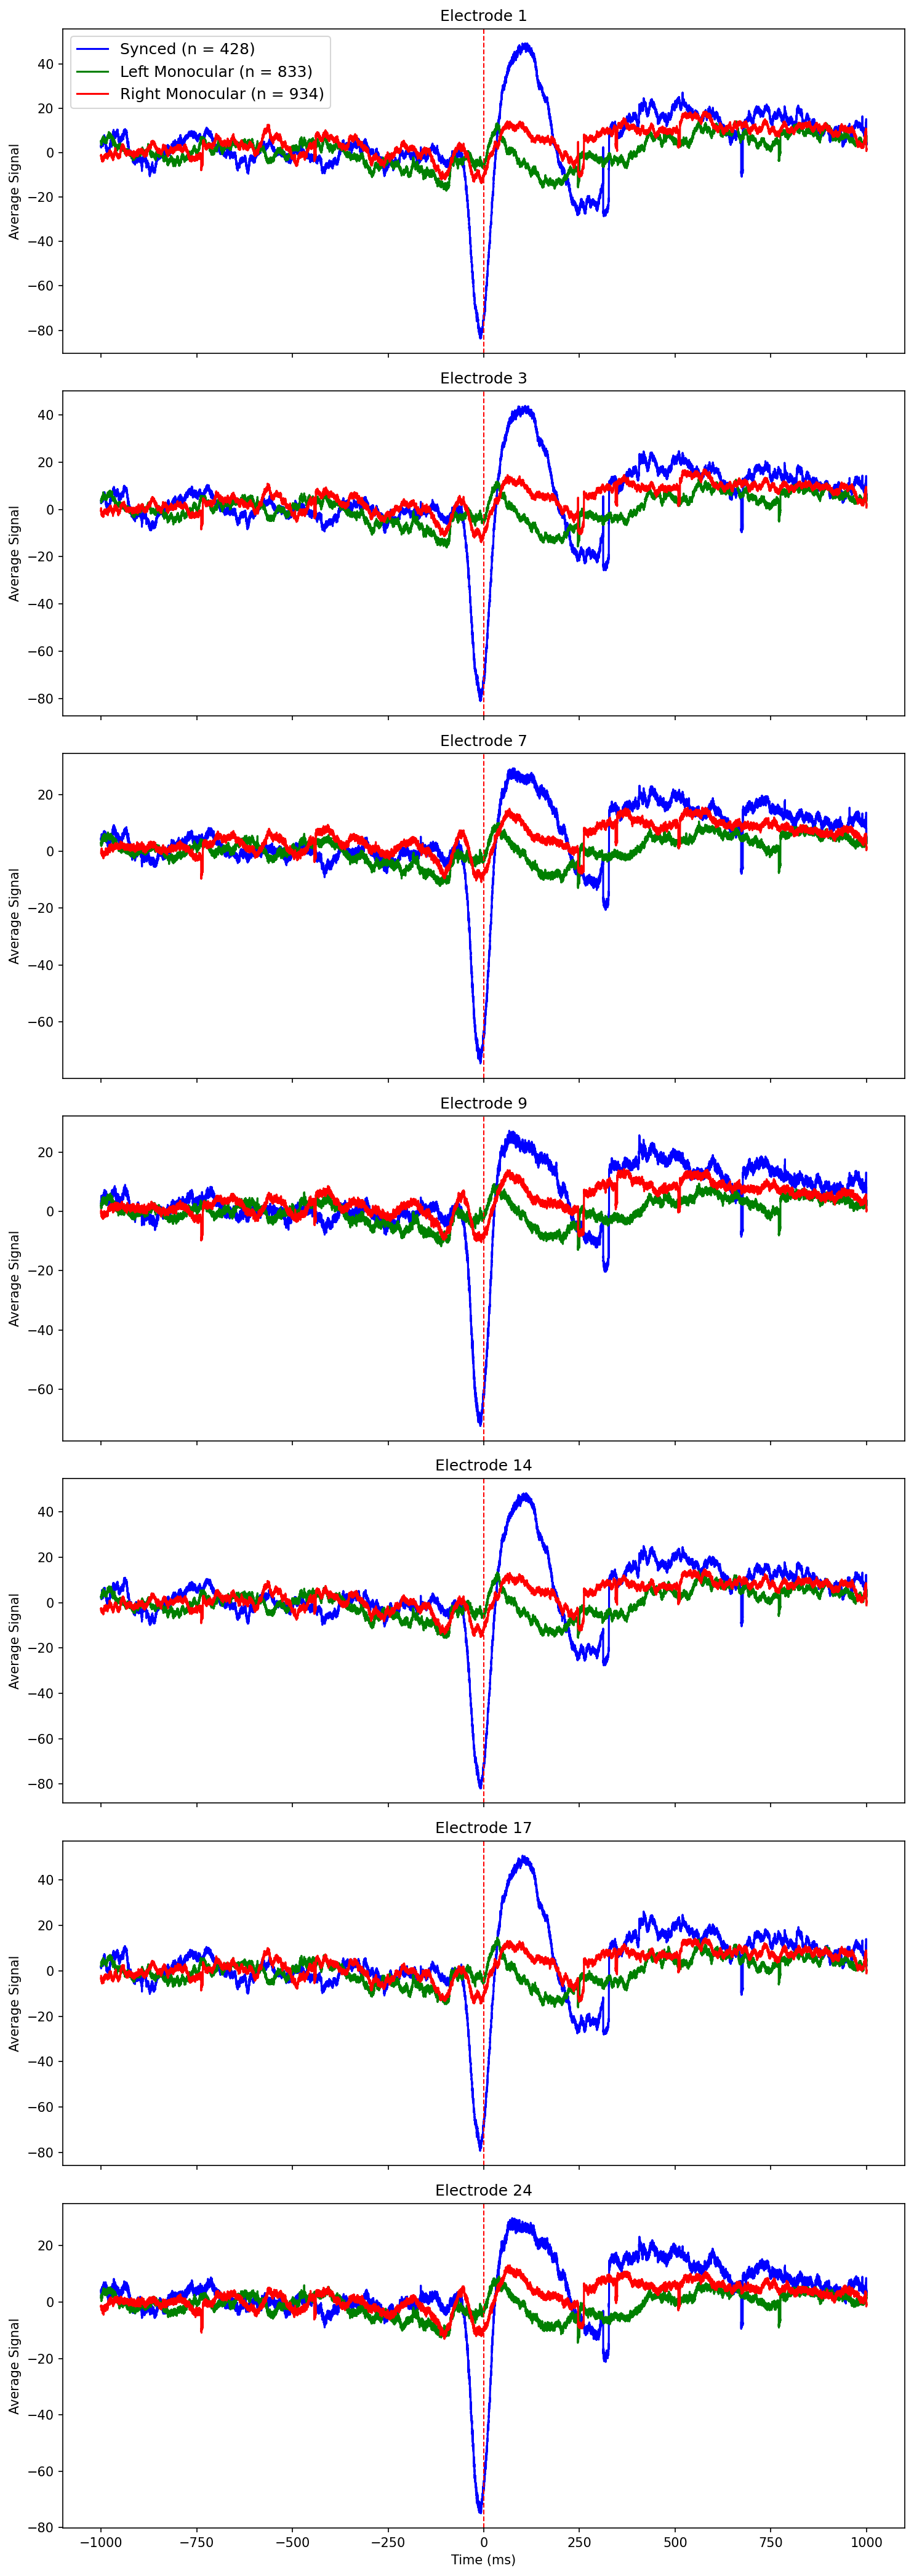

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_electrode_saccade_averages(synced_data_arr, l_non_synced_data, r_non_synced_data, electrode_labels, sampling_rate, export_path=None):
    # Number of electrodes
    num_electrodes = synced_data_arr.shape[0]

    # Create subplots (rows)
    fig, axs = plt.subplots(num_electrodes, 1, figsize=(10, num_electrodes * 4), dpi=150, sharex=True)

    if num_electrodes == 1:
        axs = [axs]  # Ensure axs is iterable when there's only one subplot

    # Define x-axis in milliseconds
    num_samples = synced_data_arr.shape[2]  # Assumes all data arrays have the same number of samples
    x_vals = np.arange(-num_samples // 2, num_samples // 2) * 1000 / sampling_rate

    for i in range(num_electrodes):
        # Calculate means
        synced_mean = np.nanmean(synced_data_arr[i], axis=0)
        l_non_synced_mean = np.nanmean(l_non_synced_data[i], axis=0)
        r_non_synced_mean = np.nanmean(r_non_synced_data[i], axis=0)

        # Plotting
        axs[i].plot(x_vals, synced_mean, label=f'Synced (n = {np.shape(synced_data_arr)[1]})', color='blue')
        axs[i].plot(x_vals, l_non_synced_mean, label=f'Left Monocular (n = {np.shape(l_non_synced_data)[1]})', color='green')
        axs[i].plot(x_vals, r_non_synced_mean, label=f'Right Monocular (n = {np.shape(r_non_synced_data)[1]})', color='red')

        # Plot formatting
        axs[i].axvline(x=0, color='red', linestyle='--', linewidth=1)
        axs[i].set_ylabel('Average Signal')
        axs[i].set_title(f'Electrode {electrode_labels[i]}')

        # Add legend only for the first subplot
        if i == 0:
            axs[i].legend(loc='best', fontsize='large')

    axs[-1].set_xlabel('Time (ms)')

    # Improve layout
    plt.tight_layout()
    if export_path:
        plt.savefig(export_path)
    plt.show()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_Saccade_avg_LFP.pdf'
plot_multi_electrode_saccade_averages(synced_data_arr, l_non_synced_data, r_non_synced_data, electrode, block.sample_rate,export_path)